# 14장 - 모델 성능 향상시키기

### 데이터 확인, 검증셋 나눠서 모델 학습하기

In [ ]:
import pandas as pd
!git clone https://github.com/taehojo/data.git

# 데이터 불러오기
df = pd.read_csv('./data/wine.csv', header=None)

df

fatal: destination path 'data' already exists and is not an empty directory.


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,0


In [ ]:
# 0~11번째 열에 해당하는 속성 12개 : X
# 13번째 열 : y

X = df.iloc[:, 0:12]
y = df.iloc[:, 12]

- 검증셋 : 최적의 학습 파라미터를 찾기 위해 학습 과정에서 사용
- `model.fit()` 함수 내 `validation_split` 옵션 적용
- 전체의 80%를 학습셋으로 만들고, 그 중 25%를 검증셋으로 하면 학습:검증:테스트의 비율이 60:20:20이 됨

In [ ]:
# 학습셋 60%, 검증셋 20%, 테스트셋 20%
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

!git clone https://github.com/taehojo/data.git

df = pd.read_csv('./data/wine.csv', header=None)

# 와인의 속성
X = df.iloc[:, 0:12]
# 와인의 분류
y = df.iloc[:, 12]

# 학습셋과 테스트셋 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

fatal: destination path 'data' already exists and is not an empty directory.


In [ ]:
# 모델 구조 설정
model = Sequential()
model.add(Dense(30, input_dim=12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 실행
history = model.fit(X_train, y_train, epochs=50, batch_size=500, validation_split=0.25)
# 0.8*0.25 = 0.3

# 테스트 결과 출력
score = model.evaluate(X_test, y_test)
print('Test accuracy:', score[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                390       
                                                                 
 dense_1 (Dense)             (None, 12)                372       
                                                                 
 dense_2 (Dense)             (None, 8)                 104       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 875 (3.42 KB)
Trainable params: 875 (3.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
8/8 [==============================] - 1s 26ms/step - loss: 5.4565 - accuracy: 0.2494 - val_loss: 4.2379 - val_accuracy: 0.2500
Epoch 2/50
8/8 [===

### 모델 업데이트하기

- epochs : 학습을 몇 번 반복할 것인지 설정
- epochs = 50 ; 순전파와 역전파를 50번 실시
  - 학습을 많이 반복한다고 해서 모델 성능이 지속적으로 좋아지는 것이 아니므로, 50번의 에포크 중 최적학습이 40번째에 이루어졌다면, 50번째 모델을 불러와 사용하도록 해야 함!
- 학습 중인 모델 저장하는 함수 : 케라스 API의 `ModelCheckpoint()`

In [ ]:
# 모델 저장 방법 정하기
modelpath = "./data/model/all/{epoch:02d}-{val_accuracy:.4f}.hdf5"
# 50번째 에포크의 검증셋 정확도가 0.9346이라면 50-0.9346.hdf5로 저장됨

# 학습 중인 모델 저장하기, 현황 모니터링할 수 있도록 verbose=1(TRUE)
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath=modelpath, verbose=1)

### 그래프로 과적합 확인하기

In [ ]:
# 긴 학습을 통해 결과를 그래프로 확인한 후 적절한 학습 횟수 정하기
history = model.fit(X_train, y_train, epochs=2000, batch_size=500, validation_split=0.25)

Epoch 1/2000
8/8 [==============================] - 0s 12ms/step - loss: 0.1634 - accuracy: 0.9435 - val_loss: 0.1643 - val_accuracy: 0.9438
Epoch 2/2000
8/8 [==============================] - 0s 5ms/step - loss: 0.1612 - accuracy: 0.9446 - val_loss: 0.1620 - val_accuracy: 0.9438
Epoch 3/2000
8/8 [==============================] - 0s 16ms/step - loss: 0.1595 - accuracy: 0.9448 - val_loss: 0.1603 - val_accuracy: 0.9438
Epoch 4/2000
8/8 [==============================] - 0s 9ms/step - loss: 0.1575 - accuracy: 0.9456 - val_loss: 0.1578 - val_accuracy: 0.9438
Epoch 5/2000
8/8 [==============================] - 0s 9ms/step - loss: 0.1554 - accuracy: 0.9456 - val_loss: 0.1554 - val_accuracy: 0.9462
Epoch 6/2000
8/8 [==============================] - 0s 6ms/step - loss: 0.1531 - accuracy: 0.9461 - val_loss: 0.1534 - val_accuracy: 0.9431
Epoch 7/2000
8/8 [==============================] - 0s 6ms/step - loss: 0.1503 - accuracy: 0.9479 - val_loss: 0.1510 - val_accuracy: 0.9462
Epoch 8/2000
8/8 [

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.163369,0.943546,0.164309,0.943846
1,0.161166,0.944573,0.161969,0.943846
2,0.159509,0.944829,0.160313,0.943846
3,0.157546,0.945599,0.157765,0.943846
4,0.155440,0.945599,0.155378,0.946154
...,...,...,...,...
1995,0.016552,0.996151,0.053891,0.986154
1996,0.019238,0.994355,0.052335,0.986923
1997,0.017872,0.995124,0.058082,0.988462
1998,0.019169,0.994355,0.056084,0.986923


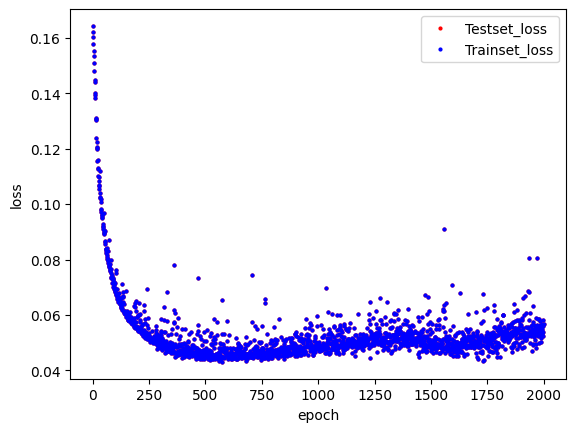

In [ ]:
# val_loss ; 학습한 모델을 검증셋에 적용해 얻은 오차 (y_vloss에 저장)
# loss ; 학습셋에서 얻은 오차 (y_loss에 저장)

y_vloss = hist_df['val_loss']
y_loss = hist_df['val_loss']

# 그래프로 표시하기
import matplotlib.pyplot as plt
import numpy as np
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, "o", c="red", markersize=2, label='Testset_loss')
plt.plot(x_len, y_loss, "o", c="blue", markersize=2, label='Trainset_loss')

plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 학습의 자동 중단
- keras API `EarlyStopping()`
- 학습이 진행되어도 테스트셋 오차가 줄어들지 않으면 학습을 자동으로 멈춤

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor='var_loss', patience=20)

In [ ]:
modelpath = "./data/model/ch14-4-bestmodel.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose = 0, save_best_only=True)

# 모델 실행, 자동으로 최적의 에포크를 찾아 멈추므로 넉넉히 2000
history = model.fit(X_train, y_train, epochs=2000, batch_size=500, validation_split=0.25, verbose=1, callbacks=[early_stopping_callback, checkpointer])

# 확인
score = model.evaluate(X_test, y_test)
print('Test accuracy: ', score[1])

Epoch 1/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

8/8 [==============================] - 0s 15ms/step - loss: 0.0184 - accuracy: 0.9949 - val_loss: 0.0555 - val_accuracy: 0.9892
Epoch 2/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0262 - accuracy: 0.9940

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 5ms/step - loss: 0.0190 - accuracy: 0.9944 - val_loss: 0.0661 - val_accuracy: 0.9838
Epoch 3/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0147 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0167 - accuracy: 0.9954 - val_loss: 0.0524 - val_accuracy: 0.9892
Epoch 4/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9900

8/8 [==============================] - 0s 5ms/step - loss: 0.0174 - accuracy: 0.9951 - val_loss: 0.0545 - val_accuracy: 0.9892
Epoch 5/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0396 - accuracy: 0.9900

8/8 [==============================] - 0s 5ms/step - loss: 0.0190 - accuracy: 0.9951 - val_loss: 0.0592 - val_accuracy: 0.9877
Epoch 6/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0224 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0178 - accuracy: 0.9949 - val_loss: 0.0546 - val_accuracy: 0.9862
Epoch 7/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0193 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0188 - accuracy: 0.9954 - val_loss: 0.0550 - val_accuracy: 0.9854
Epoch 8/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0193 - accuracy: 0.9951 - val_loss: 0.0540 - val_accuracy: 0.9892
Epoch 9/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0095 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0178 - accuracy: 0.9951 - val_loss: 0.0605 - val_accuracy: 0.9885
Epoch 10/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0221 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0184 - accuracy: 0.9956 - val_loss: 0.0552 - val_accuracy: 0.9892
Epoch 11/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0226 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0172 - accuracy: 0.9956 - val_loss: 0.0548 - val_accuracy: 0.9869
Epoch 12/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0336 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0184 - accuracy: 0.9946 - val_loss: 0.0525 - val_accuracy: 0.9869
Epoch 13/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0048 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0175 - accuracy: 0.9956 - val_loss: 0.0540 - val_accuracy: 0.9862
Epoch 14/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0148 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0170 - accuracy: 0.9959 - val_loss: 0.0553 - val_accuracy: 0.9877
Epoch 15/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0150 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0166 - accuracy: 0.9959 - val_loss: 0.0549 - val_accuracy: 0.9885
Epoch 16/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0115 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0182 - accuracy: 0.9956 - val_loss: 0.0541 - val_accuracy: 0.9862
Epoch 17/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0109 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0192 - accuracy: 0.9944 - val_loss: 0.0527 - val_accuracy: 0.9877
Epoch 18/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0160 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0225 - accuracy: 0.9928 - val_loss: 0.0691 - val_accuracy: 0.9838
Epoch 19/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0211 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0250 - accuracy: 0.9923 - val_loss: 0.0523 - val_accuracy: 0.9885
Epoch 20/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0200 - accuracy: 0.9900

8/8 [==============================] - 0s 5ms/step - loss: 0.0212 - accuracy: 0.9936 - val_loss: 0.0572 - val_accuracy: 0.9846
Epoch 21/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0195 - accuracy: 0.9941 - val_loss: 0.0551 - val_accuracy: 0.9862
Epoch 22/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0148 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 0.0575 - val_accuracy: 0.9838
Epoch 23/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0210 - accuracy: 0.9880

8/8 [==============================] - 0s 5ms/step - loss: 0.0224 - accuracy: 0.9931 - val_loss: 0.0540 - val_accuracy: 0.9877
Epoch 24/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0192 - accuracy: 0.9954 - val_loss: 0.0547 - val_accuracy: 0.9854
Epoch 25/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0109 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0178 - accuracy: 0.9951 - val_loss: 0.0581 - val_accuracy: 0.9877
Epoch 26/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0234 - accuracy: 0.9923 - val_loss: 0.0610 - val_accuracy: 0.9854
Epoch 27/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0070 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0224 - accuracy: 0.9931 - val_loss: 0.0543 - val_accuracy: 0.9846
Epoch 28/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0171 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0207 - accuracy: 0.9938 - val_loss: 0.0540 - val_accuracy: 0.9877
Epoch 29/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0085 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0188 - accuracy: 0.9954 - val_loss: 0.0546 - val_accuracy: 0.9877
Epoch 30/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0168 - accuracy: 0.9962 - val_loss: 0.0516 - val_accuracy: 0.9854
Epoch 31/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0172 - accuracy: 0.9964 - val_loss: 0.0556 - val_accuracy: 0.9877
Epoch 32/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0223 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0174 - accuracy: 0.9959 - val_loss: 0.0576 - val_accuracy: 0.9885
Epoch 33/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0141 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0175 - accuracy: 0.9949 - val_loss: 0.0552 - val_accuracy: 0.9885
Epoch 34/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0199 - accuracy: 0.9949 - val_loss: 0.0538 - val_accuracy: 0.9862
Epoch 35/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0256 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0183 - accuracy: 0.9956 - val_loss: 0.0531 - val_accuracy: 0.9885
Epoch 36/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0175 - accuracy: 0.9954 - val_loss: 0.0521 - val_accuracy: 0.9877
Epoch 37/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0133 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0217 - accuracy: 0.9944 - val_loss: 0.0547 - val_accuracy: 0.9869
Epoch 38/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0087 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0205 - accuracy: 0.9936 - val_loss: 0.0529 - val_accuracy: 0.9885
Epoch 39/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0205 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0176 - accuracy: 0.9946 - val_loss: 0.0546 - val_accuracy: 0.9877
Epoch 40/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0271 - accuracy: 0.9920

8/8 [==============================] - 0s 5ms/step - loss: 0.0168 - accuracy: 0.9959 - val_loss: 0.0535 - val_accuracy: 0.9869
Epoch 41/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0145 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0192 - accuracy: 0.9944 - val_loss: 0.0548 - val_accuracy: 0.9862
Epoch 42/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0158 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0186 - accuracy: 0.9951 - val_loss: 0.0538 - val_accuracy: 0.9885
Epoch 43/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0400 - accuracy: 0.9880

8/8 [==============================] - 0s 5ms/step - loss: 0.0168 - accuracy: 0.9951 - val_loss: 0.0557 - val_accuracy: 0.9885
Epoch 44/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0363 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0167 - accuracy: 0.9956 - val_loss: 0.0543 - val_accuracy: 0.9869
Epoch 45/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0060 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0170 - accuracy: 0.9951 - val_loss: 0.0537 - val_accuracy: 0.9877
Epoch 46/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0076 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0174 - accuracy: 0.9959 - val_loss: 0.0542 - val_accuracy: 0.9862
Epoch 47/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0326 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0167 - accuracy: 0.9969 - val_loss: 0.0537 - val_accuracy: 0.9885
Epoch 48/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0270 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0176 - accuracy: 0.9951 - val_loss: 0.0566 - val_accuracy: 0.9885
Epoch 49/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0332 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0182 - accuracy: 0.9956 - val_loss: 0.0565 - val_accuracy: 0.9877
Epoch 50/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0175 - accuracy: 0.9954 - val_loss: 0.0633 - val_accuracy: 0.9869
Epoch 51/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0206 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0189 - accuracy: 0.9946 - val_loss: 0.0557 - val_accuracy: 0.9869
Epoch 52/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0140 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0186 - accuracy: 0.9954 - val_loss: 0.0581 - val_accuracy: 0.9862
Epoch 53/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0061 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0191 - accuracy: 0.9946 - val_loss: 0.0509 - val_accuracy: 0.9869
Epoch 54/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0254 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0201 - accuracy: 0.9944 - val_loss: 0.0640 - val_accuracy: 0.9877
Epoch 55/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0384 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0206 - accuracy: 0.9946 - val_loss: 0.0580 - val_accuracy: 0.9869
Epoch 56/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0253 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.0585 - val_accuracy: 0.9885
Epoch 57/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0225 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0181 - accuracy: 0.9956 - val_loss: 0.0594 - val_accuracy: 0.9877
Epoch 58/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0290 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0182 - accuracy: 0.9949 - val_loss: 0.0592 - val_accuracy: 0.9862
Epoch 59/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0137 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0184 - accuracy: 0.9946 - val_loss: 0.0574 - val_accuracy: 0.9877
Epoch 60/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0069 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0214 - accuracy: 0.9920 - val_loss: 0.0571 - val_accuracy: 0.9892
Epoch 61/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0194 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0188 - accuracy: 0.9954 - val_loss: 0.0528 - val_accuracy: 0.9869
Epoch 62/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0118 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0164 - accuracy: 0.9964 - val_loss: 0.0564 - val_accuracy: 0.9885
Epoch 63/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0175 - accuracy: 0.9954 - val_loss: 0.0553 - val_accuracy: 0.9892
Epoch 64/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0174 - accuracy: 0.9956 - val_loss: 0.0620 - val_accuracy: 0.9885
Epoch 65/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0085 - accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0184 - accuracy: 0.9951 - val_loss: 0.0549 - val_accuracy: 0.9892
Epoch 66/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0118 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9956 - val_loss: 0.0579 - val_accuracy: 0.9854
Epoch 67/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0278 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0211 - accuracy: 0.9933 - val_loss: 0.0565 - val_accuracy: 0.9846
Epoch 68/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0358 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0252 - accuracy: 0.9920 - val_loss: 0.0544 - val_accuracy: 0.9869
Epoch 69/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0432 - accuracy: 0.9879 - val_loss: 0.0599 - val_accuracy: 0.9846
Epoch 70/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0198 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0374 - accuracy: 0.9895 - val_loss: 0.1280 - val_accuracy: 0.9662
Epoch 71/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0949 - accuracy: 0.9760

8/8 [==============================] - 0s 5ms/step - loss: 0.0456 - accuracy: 0.9877 - val_loss: 0.0614 - val_accuracy: 0.9862
Epoch 72/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0266 - accuracy: 0.9920

8/8 [==============================] - 0s 5ms/step - loss: 0.0299 - accuracy: 0.9920 - val_loss: 0.0532 - val_accuracy: 0.9862
Epoch 73/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0204 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0254 - accuracy: 0.9928 - val_loss: 0.0505 - val_accuracy: 0.9877
Epoch 74/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0282 - accuracy: 0.9920

8/8 [==============================] - 0s 5ms/step - loss: 0.0219 - accuracy: 0.9938 - val_loss: 0.0566 - val_accuracy: 0.9869
Epoch 75/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0186 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0205 - accuracy: 0.9949 - val_loss: 0.0515 - val_accuracy: 0.9877
Epoch 76/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0156 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0186 - accuracy: 0.9944 - val_loss: 0.0549 - val_accuracy: 0.9885
Epoch 77/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0172 - accuracy: 0.9959 - val_loss: 0.0604 - val_accuracy: 0.9885
Epoch 78/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0158 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 0.9951 - val_loss: 0.0552 - val_accuracy: 0.9862
Epoch 79/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0095 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0172 - accuracy: 0.9956 - val_loss: 0.0552 - val_accuracy: 0.9877
Epoch 80/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0179 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0166 - accuracy: 0.9967 - val_loss: 0.0566 - val_accuracy: 0.9854
Epoch 81/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0117 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0173 - accuracy: 0.9959 - val_loss: 0.0531 - val_accuracy: 0.9885
Epoch 82/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0099 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0172 - accuracy: 0.9959 - val_loss: 0.0507 - val_accuracy: 0.9885
Epoch 83/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0073 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0185 - accuracy: 0.9949 - val_loss: 0.0600 - val_accuracy: 0.9877
Epoch 84/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0214 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0584 - val_accuracy: 0.9892
Epoch 85/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0086 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0187 - accuracy: 0.9944 - val_loss: 0.0589 - val_accuracy: 0.9885
Epoch 86/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0174 - accuracy: 0.9959 - val_loss: 0.0576 - val_accuracy: 0.9885
Epoch 87/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0069 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0169 - accuracy: 0.9967 - val_loss: 0.0543 - val_accuracy: 0.9877
Epoch 88/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0432 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0164 - accuracy: 0.9962 - val_loss: 0.0562 - val_accuracy: 0.9885
Epoch 89/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0164 - accuracy: 0.9962 - val_loss: 0.0550 - val_accuracy: 0.9877
Epoch 90/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0241 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0165 - accuracy: 0.9962 - val_loss: 0.0528 - val_accuracy: 0.9885
Epoch 91/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0094 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0173 - accuracy: 0.9941 - val_loss: 0.0622 - val_accuracy: 0.9877
Epoch 92/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0190 - accuracy: 0.9949 - val_loss: 0.0570 - val_accuracy: 0.9892
Epoch 93/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0315 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0236 - accuracy: 0.9923 - val_loss: 0.0577 - val_accuracy: 0.9885
Epoch 94/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0238 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0208 - accuracy: 0.9938 - val_loss: 0.0573 - val_accuracy: 0.9862
Epoch 95/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0197 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.0550 - val_accuracy: 0.9869
Epoch 96/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0222 - accuracy: 0.9920

8/8 [==============================] - 0s 5ms/step - loss: 0.0166 - accuracy: 0.9962 - val_loss: 0.0545 - val_accuracy: 0.9885
Epoch 97/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0231 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 0.0532 - val_accuracy: 0.9885
Epoch 98/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0252 - accuracy: 0.9920

8/8 [==============================] - 0s 5ms/step - loss: 0.0195 - accuracy: 0.9931 - val_loss: 0.0731 - val_accuracy: 0.9846
Epoch 99/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0320 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0198 - accuracy: 0.9938 - val_loss: 0.0538 - val_accuracy: 0.9862
Epoch 100/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0335 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0178 - accuracy: 0.9962 - val_loss: 0.0552 - val_accuracy: 0.9885
Epoch 101/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0061 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0535 - val_accuracy: 0.9877
Epoch 102/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0206 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0175 - accuracy: 0.9954 - val_loss: 0.0649 - val_accuracy: 0.9862
Epoch 103/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0229 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0181 - accuracy: 0.9944 - val_loss: 0.0529 - val_accuracy: 0.9862
Epoch 104/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0283 - accuracy: 0.9880

8/8 [==============================] - 0s 7ms/step - loss: 0.0189 - accuracy: 0.9933 - val_loss: 0.0561 - val_accuracy: 0.9854
Epoch 105/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0107 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0179 - accuracy: 0.9954 - val_loss: 0.0536 - val_accuracy: 0.9892
Epoch 106/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0217 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.0557 - val_accuracy: 0.9862
Epoch 107/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0171 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0261 - accuracy: 0.9920 - val_loss: 0.0544 - val_accuracy: 0.9900
Epoch 108/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0292 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0200 - accuracy: 0.9944 - val_loss: 0.0586 - val_accuracy: 0.9862
Epoch 109/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0216 - accuracy: 0.9920

8/8 [==============================] - 0s 5ms/step - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.0555 - val_accuracy: 0.9885
Epoch 110/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0207 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0208 - accuracy: 0.9946 - val_loss: 0.0557 - val_accuracy: 0.9869
Epoch 111/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0266 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0192 - accuracy: 0.9951 - val_loss: 0.0487 - val_accuracy: 0.9869
Epoch 112/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0195 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0203 - accuracy: 0.9938 - val_loss: 0.0599 - val_accuracy: 0.9885
Epoch 113/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0143 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0186 - accuracy: 0.9938 - val_loss: 0.0534 - val_accuracy: 0.9877
Epoch 114/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0145 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0167 - accuracy: 0.9959 - val_loss: 0.0565 - val_accuracy: 0.9877
Epoch 115/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0142 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0174 - accuracy: 0.9956 - val_loss: 0.0558 - val_accuracy: 0.9885
Epoch 116/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0183 - accuracy: 0.9946 - val_loss: 0.0534 - val_accuracy: 0.9877
Epoch 117/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0149 - accuracy: 0.9920

8/8 [==============================] - 0s 5ms/step - loss: 0.0162 - accuracy: 0.9964 - val_loss: 0.0551 - val_accuracy: 0.9885
Epoch 118/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0216 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0175 - accuracy: 0.9956 - val_loss: 0.0568 - val_accuracy: 0.9892
Epoch 119/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0125 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0171 - accuracy: 0.9956 - val_loss: 0.0538 - val_accuracy: 0.9885
Epoch 120/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0130 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0162 - accuracy: 0.9962 - val_loss: 0.0547 - val_accuracy: 0.9885
Epoch 121/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0195 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0165 - accuracy: 0.9962 - val_loss: 0.0575 - val_accuracy: 0.9885
Epoch 122/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0200 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0165 - accuracy: 0.9959 - val_loss: 0.0549 - val_accuracy: 0.9900
Epoch 123/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0164 - accuracy: 0.9967 - val_loss: 0.0534 - val_accuracy: 0.9885
Epoch 124/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0139 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0168 - accuracy: 0.9962 - val_loss: 0.0529 - val_accuracy: 0.9862
Epoch 125/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0170 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0171 - accuracy: 0.9959 - val_loss: 0.0581 - val_accuracy: 0.9862
Epoch 126/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0055 - accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0203 - accuracy: 0.9938 - val_loss: 0.0487 - val_accuracy: 0.9877
Epoch 127/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0274 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0210 - accuracy: 0.9933 - val_loss: 0.0587 - val_accuracy: 0.9838
Epoch 128/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0387 - accuracy: 0.9920

8/8 [==============================] - 0s 5ms/step - loss: 0.0206 - accuracy: 0.9946 - val_loss: 0.0489 - val_accuracy: 0.9877
Epoch 129/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0098 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0168 - accuracy: 0.9962 - val_loss: 0.0572 - val_accuracy: 0.9846
Epoch 130/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0401 - accuracy: 0.9860

8/8 [==============================] - 0s 5ms/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 0.0562 - val_accuracy: 0.9885
Epoch 131/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0184 - accuracy: 0.9944 - val_loss: 0.0575 - val_accuracy: 0.9838
Epoch 132/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0118 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0199 - accuracy: 0.9946 - val_loss: 0.0588 - val_accuracy: 0.9854
Epoch 133/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0169 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0197 - accuracy: 0.9944 - val_loss: 0.0527 - val_accuracy: 0.9862
Epoch 134/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0539 - accuracy: 0.9820

8/8 [==============================] - 0s 6ms/step - loss: 0.0206 - accuracy: 0.9933 - val_loss: 0.0567 - val_accuracy: 0.9846
Epoch 135/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0245 - accuracy: 0.9915 - val_loss: 0.0560 - val_accuracy: 0.9846
Epoch 136/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0074 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0222 - accuracy: 0.9938 - val_loss: 0.0646 - val_accuracy: 0.9862
Epoch 137/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0166 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0281 - accuracy: 0.9926 - val_loss: 0.0647 - val_accuracy: 0.9869
Epoch 138/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0215 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0199 - accuracy: 0.9946 - val_loss: 0.0578 - val_accuracy: 0.9854
Epoch 139/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0156 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0215 - accuracy: 0.9941 - val_loss: 0.0544 - val_accuracy: 0.9877
Epoch 140/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0221 - accuracy: 0.9926 - val_loss: 0.0579 - val_accuracy: 0.9862
Epoch 141/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0086 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0182 - accuracy: 0.9949 - val_loss: 0.0565 - val_accuracy: 0.9846
Epoch 142/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0265 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0212 - accuracy: 0.9938 - val_loss: 0.0595 - val_accuracy: 0.9892
Epoch 143/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0293 - accuracy: 0.9920

8/8 [==============================] - 0s 5ms/step - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0536 - val_accuracy: 0.9908
Epoch 144/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0195 - accuracy: 0.9946 - val_loss: 0.0573 - val_accuracy: 0.9877
Epoch 145/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0250 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0181 - accuracy: 0.9954 - val_loss: 0.0515 - val_accuracy: 0.9869
Epoch 146/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0209 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0170 - accuracy: 0.9954 - val_loss: 0.0515 - val_accuracy: 0.9862
Epoch 147/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0172 - accuracy: 0.9964 - val_loss: 0.0556 - val_accuracy: 0.9877
Epoch 148/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0244 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0195 - accuracy: 0.9941 - val_loss: 0.0503 - val_accuracy: 0.9862
Epoch 149/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0180 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0201 - accuracy: 0.9936 - val_loss: 0.0561 - val_accuracy: 0.9862
Epoch 150/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0305 - accuracy: 0.9900

8/8 [==============================] - 0s 5ms/step - loss: 0.0185 - accuracy: 0.9951 - val_loss: 0.0503 - val_accuracy: 0.9869
Epoch 151/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0243 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0195 - accuracy: 0.9946 - val_loss: 0.0566 - val_accuracy: 0.9862
Epoch 152/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0236 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0201 - accuracy: 0.9946 - val_loss: 0.0523 - val_accuracy: 0.9877
Epoch 153/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0176 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0222 - accuracy: 0.9938 - val_loss: 0.0548 - val_accuracy: 0.9877
Epoch 154/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0145 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0191 - accuracy: 0.9946 - val_loss: 0.0493 - val_accuracy: 0.9838
Epoch 155/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0206 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0189 - accuracy: 0.9954 - val_loss: 0.0549 - val_accuracy: 0.9877
Epoch 156/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0285 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0178 - accuracy: 0.9954 - val_loss: 0.0488 - val_accuracy: 0.9885
Epoch 157/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0075 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0169 - accuracy: 0.9962 - val_loss: 0.0552 - val_accuracy: 0.9892
Epoch 158/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0068 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0165 - accuracy: 0.9959 - val_loss: 0.0495 - val_accuracy: 0.9869
Epoch 159/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0212 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0176 - accuracy: 0.9959 - val_loss: 0.0523 - val_accuracy: 0.9885
Epoch 160/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0164 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0168 - accuracy: 0.9959 - val_loss: 0.0504 - val_accuracy: 0.9885
Epoch 161/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0350 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0184 - accuracy: 0.9938 - val_loss: 0.0721 - val_accuracy: 0.9854
Epoch 162/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0314 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0219 - accuracy: 0.9941 - val_loss: 0.0517 - val_accuracy: 0.9854
Epoch 163/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0206 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0177 - accuracy: 0.9951 - val_loss: 0.0544 - val_accuracy: 0.9869
Epoch 164/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0168 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0173 - accuracy: 0.9954 - val_loss: 0.0518 - val_accuracy: 0.9885
Epoch 165/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0178 - accuracy: 0.9949 - val_loss: 0.0572 - val_accuracy: 0.9877
Epoch 166/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0253 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0174 - accuracy: 0.9954 - val_loss: 0.0547 - val_accuracy: 0.9862
Epoch 167/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0090 - accuracy: 0.9980

8/8 [==============================] - 0s 12ms/step - loss: 0.0170 - accuracy: 0.9959 - val_loss: 0.0477 - val_accuracy: 0.9885
Epoch 168/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0173 - accuracy: 0.9959 - val_loss: 0.0528 - val_accuracy: 0.9854
Epoch 169/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0241 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0169 - accuracy: 0.9949 - val_loss: 0.0558 - val_accuracy: 0.9885
Epoch 170/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0174 - accuracy: 0.9954 - val_loss: 0.0584 - val_accuracy: 0.9892
Epoch 171/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0177 - accuracy: 0.9956 - val_loss: 0.0555 - val_accuracy: 0.9846
Epoch 172/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0139 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0168 - accuracy: 0.9954 - val_loss: 0.0572 - val_accuracy: 0.9885
Epoch 173/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0360 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0167 - accuracy: 0.9962 - val_loss: 0.0546 - val_accuracy: 0.9869
Epoch 174/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0127 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 0.9956 - val_loss: 0.0536 - val_accuracy: 0.9877
Epoch 175/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0179 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0173 - accuracy: 0.9954 - val_loss: 0.0573 - val_accuracy: 0.9892
Epoch 176/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0204 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0169 - accuracy: 0.9962 - val_loss: 0.0580 - val_accuracy: 0.9892
Epoch 177/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0081 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0165 - accuracy: 0.9962 - val_loss: 0.0562 - val_accuracy: 0.9885
Epoch 178/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0259 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0169 - accuracy: 0.9951 - val_loss: 0.0578 - val_accuracy: 0.9885
Epoch 179/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0313 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0166 - accuracy: 0.9962 - val_loss: 0.0541 - val_accuracy: 0.9869
Epoch 180/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0163 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0174 - accuracy: 0.9962 - val_loss: 0.0544 - val_accuracy: 0.9877
Epoch 181/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0287 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0162 - accuracy: 0.9959 - val_loss: 0.0609 - val_accuracy: 0.9885
Epoch 182/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0167 - accuracy: 0.9954 - val_loss: 0.0557 - val_accuracy: 0.9877
Epoch 183/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0305 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0181 - accuracy: 0.9944 - val_loss: 0.0538 - val_accuracy: 0.9892
Epoch 184/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0163 - accuracy: 0.9962 - val_loss: 0.0541 - val_accuracy: 0.9869
Epoch 185/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0110 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0170 - accuracy: 0.9956 - val_loss: 0.0555 - val_accuracy: 0.9869
Epoch 186/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0260 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0164 - accuracy: 0.9959 - val_loss: 0.0534 - val_accuracy: 0.9877
Epoch 187/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0162 - accuracy: 0.9956 - val_loss: 0.0635 - val_accuracy: 0.9877
Epoch 188/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0207 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0170 - accuracy: 0.9951 - val_loss: 0.0581 - val_accuracy: 0.9869
Epoch 189/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0232 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0175 - accuracy: 0.9964 - val_loss: 0.0608 - val_accuracy: 0.9869
Epoch 190/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0283 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0183 - accuracy: 0.9951 - val_loss: 0.0529 - val_accuracy: 0.9869
Epoch 191/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0161 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0167 - accuracy: 0.9954 - val_loss: 0.0556 - val_accuracy: 0.9869
Epoch 192/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0170 - accuracy: 0.9964 - val_loss: 0.0545 - val_accuracy: 0.9877
Epoch 193/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0125 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0174 - accuracy: 0.9949 - val_loss: 0.0572 - val_accuracy: 0.9877
Epoch 194/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0174 - accuracy: 0.9956 - val_loss: 0.0556 - val_accuracy: 0.9862
Epoch 195/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0211 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0169 - accuracy: 0.9956 - val_loss: 0.0563 - val_accuracy: 0.9892
Epoch 196/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0180 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0162 - accuracy: 0.9956 - val_loss: 0.0549 - val_accuracy: 0.9877
Epoch 197/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0285 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0165 - accuracy: 0.9956 - val_loss: 0.0566 - val_accuracy: 0.9877
Epoch 198/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0166 - accuracy: 0.9959 - val_loss: 0.0560 - val_accuracy: 0.9892
Epoch 199/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0275 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.0688 - val_accuracy: 0.9877
Epoch 200/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0303 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0181 - accuracy: 0.9949 - val_loss: 0.0588 - val_accuracy: 0.9892
Epoch 201/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0146 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0198 - accuracy: 0.9936 - val_loss: 0.0562 - val_accuracy: 0.9869
Epoch 202/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0194 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0220 - accuracy: 0.9938 - val_loss: 0.0550 - val_accuracy: 0.9892
Epoch 203/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0398 - accuracy: 0.9880

8/8 [==============================] - 0s 6ms/step - loss: 0.0331 - accuracy: 0.9908 - val_loss: 0.0712 - val_accuracy: 0.9846
Epoch 204/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0046 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0240 - accuracy: 0.9920 - val_loss: 0.0556 - val_accuracy: 0.9862
Epoch 205/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0215 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0232 - accuracy: 0.9933 - val_loss: 0.0567 - val_accuracy: 0.9869
Epoch 206/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0212 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0201 - accuracy: 0.9946 - val_loss: 0.0542 - val_accuracy: 0.9885
Epoch 207/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0195 - accuracy: 0.9946 - val_loss: 0.0669 - val_accuracy: 0.9869
Epoch 208/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0408 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0208 - accuracy: 0.9941 - val_loss: 0.0599 - val_accuracy: 0.9862
Epoch 209/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0373 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0192 - accuracy: 0.9951 - val_loss: 0.0579 - val_accuracy: 0.9862
Epoch 210/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0274 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0171 - accuracy: 0.9959 - val_loss: 0.0519 - val_accuracy: 0.9877
Epoch 211/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0088 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0164 - accuracy: 0.9969 - val_loss: 0.0559 - val_accuracy: 0.9877
Epoch 212/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0104 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0186 - accuracy: 0.9933 - val_loss: 0.0519 - val_accuracy: 0.9877
Epoch 213/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0109 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0161 - accuracy: 0.9962 - val_loss: 0.0569 - val_accuracy: 0.9892
Epoch 214/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0164 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0174 - accuracy: 0.9949 - val_loss: 0.0562 - val_accuracy: 0.9838
Epoch 215/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0059 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0173 - accuracy: 0.9954 - val_loss: 0.0532 - val_accuracy: 0.9885
Epoch 216/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0057 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0170 - accuracy: 0.9959 - val_loss: 0.0570 - val_accuracy: 0.9862
Epoch 217/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0081 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0180 - accuracy: 0.9949 - val_loss: 0.0645 - val_accuracy: 0.9869
Epoch 218/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0079 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0209 - accuracy: 0.9928 - val_loss: 0.0575 - val_accuracy: 0.9892
Epoch 219/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0120 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0192 - accuracy: 0.9938 - val_loss: 0.0591 - val_accuracy: 0.9838
Epoch 220/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0098 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0225 - accuracy: 0.9915 - val_loss: 0.0560 - val_accuracy: 0.9862
Epoch 221/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0200 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0233 - accuracy: 0.9936 - val_loss: 0.0615 - val_accuracy: 0.9869
Epoch 222/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0191 - accuracy: 0.9920

8/8 [==============================] - 0s 5ms/step - loss: 0.0207 - accuracy: 0.9931 - val_loss: 0.0569 - val_accuracy: 0.9854
Epoch 223/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0306 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0184 - accuracy: 0.9951 - val_loss: 0.0539 - val_accuracy: 0.9885
Epoch 224/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0202 - accuracy: 0.9941 - val_loss: 0.0561 - val_accuracy: 0.9885
Epoch 225/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0161 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0176 - accuracy: 0.9941 - val_loss: 0.0596 - val_accuracy: 0.9885
Epoch 226/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0447 - accuracy: 0.9860

8/8 [==============================] - 0s 5ms/step - loss: 0.0173 - accuracy: 0.9959 - val_loss: 0.0601 - val_accuracy: 0.9885
Epoch 227/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0176 - accuracy: 0.9949 - val_loss: 0.0554 - val_accuracy: 0.9885
Epoch 228/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0065 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0161 - accuracy: 0.9962 - val_loss: 0.0544 - val_accuracy: 0.9885
Epoch 229/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0152 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0166 - accuracy: 0.9956 - val_loss: 0.0649 - val_accuracy: 0.9869
Epoch 230/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0170 - accuracy: 0.9949 - val_loss: 0.0593 - val_accuracy: 0.9892
Epoch 231/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0273 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0195 - accuracy: 0.9931 - val_loss: 0.0568 - val_accuracy: 0.9885
Epoch 232/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0176 - accuracy: 0.9956 - val_loss: 0.0571 - val_accuracy: 0.9862
Epoch 233/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0161 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 0.9951 - val_loss: 0.0570 - val_accuracy: 0.9862
Epoch 234/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0192 - accuracy: 0.9941 - val_loss: 0.0584 - val_accuracy: 0.9877
Epoch 235/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0239 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0239 - accuracy: 0.9928 - val_loss: 0.0536 - val_accuracy: 0.9885
Epoch 236/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0231 - accuracy: 0.9926 - val_loss: 0.0553 - val_accuracy: 0.9877
Epoch 237/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0206 - accuracy: 0.9938 - val_loss: 0.0605 - val_accuracy: 0.9877
Epoch 238/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0200 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0174 - accuracy: 0.9949 - val_loss: 0.0576 - val_accuracy: 0.9892
Epoch 239/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0187 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0173 - accuracy: 0.9954 - val_loss: 0.0582 - val_accuracy: 0.9854
Epoch 240/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0281 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 0.0557 - val_accuracy: 0.9877
Epoch 241/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0097 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0234 - accuracy: 0.9928 - val_loss: 0.0574 - val_accuracy: 0.9885
Epoch 242/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0118 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9941 - val_loss: 0.0556 - val_accuracy: 0.9885
Epoch 243/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0133 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0171 - accuracy: 0.9951 - val_loss: 0.0550 - val_accuracy: 0.9885
Epoch 244/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0095 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0162 - accuracy: 0.9962 - val_loss: 0.0552 - val_accuracy: 0.9885
Epoch 245/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0074 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0167 - accuracy: 0.9956 - val_loss: 0.0555 - val_accuracy: 0.9877
Epoch 246/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0172 - accuracy: 0.9956 - val_loss: 0.0529 - val_accuracy: 0.9885
Epoch 247/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0103 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0171 - accuracy: 0.9964 - val_loss: 0.0554 - val_accuracy: 0.9862
Epoch 248/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0182 - accuracy: 0.9941 - val_loss: 0.0586 - val_accuracy: 0.9869
Epoch 249/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0079 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9941 - val_loss: 0.0617 - val_accuracy: 0.9869
Epoch 250/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0327 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0189 - accuracy: 0.9933 - val_loss: 0.0611 - val_accuracy: 0.9892
Epoch 251/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0092 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0183 - accuracy: 0.9951 - val_loss: 0.0592 - val_accuracy: 0.9885
Epoch 252/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0215 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0191 - accuracy: 0.9946 - val_loss: 0.0548 - val_accuracy: 0.9900
Epoch 253/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0176 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0221 - accuracy: 0.9923 - val_loss: 0.0686 - val_accuracy: 0.9862
Epoch 254/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0397 - accuracy: 0.9880

8/8 [==============================] - 0s 6ms/step - loss: 0.0210 - accuracy: 0.9926 - val_loss: 0.0631 - val_accuracy: 0.9869
Epoch 255/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0224 - accuracy: 0.9931 - val_loss: 0.0597 - val_accuracy: 0.9877
Epoch 256/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0120 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0241 - accuracy: 0.9923 - val_loss: 0.0536 - val_accuracy: 0.9869
Epoch 257/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0139 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 0.9949 - val_loss: 0.0587 - val_accuracy: 0.9869
Epoch 258/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0073 - accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0178 - accuracy: 0.9951 - val_loss: 0.0563 - val_accuracy: 0.9877
Epoch 259/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0405 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0193 - accuracy: 0.9949 - val_loss: 0.0566 - val_accuracy: 0.9885
Epoch 260/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0187 - accuracy: 0.9946 - val_loss: 0.0578 - val_accuracy: 0.9892
Epoch 261/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0074 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0175 - accuracy: 0.9951 - val_loss: 0.0585 - val_accuracy: 0.9885
Epoch 262/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0114 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0164 - accuracy: 0.9967 - val_loss: 0.0565 - val_accuracy: 0.9869
Epoch 263/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0171 - accuracy: 0.9956 - val_loss: 0.0547 - val_accuracy: 0.9869
Epoch 264/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0137 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0196 - accuracy: 0.9946 - val_loss: 0.0585 - val_accuracy: 0.9854
Epoch 265/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0137 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0200 - accuracy: 0.9946 - val_loss: 0.0547 - val_accuracy: 0.9846
Epoch 266/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0359 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0205 - accuracy: 0.9941 - val_loss: 0.0593 - val_accuracy: 0.9869
Epoch 267/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0080 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0183 - accuracy: 0.9946 - val_loss: 0.0648 - val_accuracy: 0.9877
Epoch 268/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0154 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0178 - accuracy: 0.9951 - val_loss: 0.0613 - val_accuracy: 0.9885
Epoch 269/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0566 - accuracy: 0.9840

8/8 [==============================] - 0s 6ms/step - loss: 0.0174 - accuracy: 0.9956 - val_loss: 0.0556 - val_accuracy: 0.9869
Epoch 270/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0218 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0169 - accuracy: 0.9956 - val_loss: 0.0571 - val_accuracy: 0.9885
Epoch 271/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0212 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0167 - accuracy: 0.9956 - val_loss: 0.0586 - val_accuracy: 0.9838
Epoch 272/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0347 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0183 - accuracy: 0.9949 - val_loss: 0.0575 - val_accuracy: 0.9854
Epoch 273/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0224 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0185 - accuracy: 0.9951 - val_loss: 0.0560 - val_accuracy: 0.9877
Epoch 274/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0093 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0176 - accuracy: 0.9954 - val_loss: 0.0579 - val_accuracy: 0.9869
Epoch 275/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0343 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0182 - accuracy: 0.9951 - val_loss: 0.0550 - val_accuracy: 0.9862
Epoch 276/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0171 - accuracy: 0.9940

8/8 [==============================] - 0s 5ms/step - loss: 0.0199 - accuracy: 0.9944 - val_loss: 0.0577 - val_accuracy: 0.9862
Epoch 277/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0191 - accuracy: 0.9946 - val_loss: 0.0639 - val_accuracy: 0.9869
Epoch 278/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0108 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0203 - accuracy: 0.9946 - val_loss: 0.0599 - val_accuracy: 0.9877
Epoch 279/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0191 - accuracy: 0.9941 - val_loss: 0.0547 - val_accuracy: 0.9854
Epoch 280/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0257 - accuracy: 0.9900

8/8 [==============================] - 0s 5ms/step - loss: 0.0202 - accuracy: 0.9938 - val_loss: 0.0582 - val_accuracy: 0.9862
Epoch 281/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0152 - accuracy: 0.9900

8/8 [==============================] - 0s 5ms/step - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0501 - val_accuracy: 0.9869
Epoch 282/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0263 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0175 - accuracy: 0.9954 - val_loss: 0.0608 - val_accuracy: 0.9854
Epoch 283/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0064 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0201 - accuracy: 0.9933 - val_loss: 0.0642 - val_accuracy: 0.9854
Epoch 284/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0333 - accuracy: 0.9840

8/8 [==============================] - 0s 9ms/step - loss: 0.0225 - accuracy: 0.9933 - val_loss: 0.0579 - val_accuracy: 0.9877
Epoch 285/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0215 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0196 - accuracy: 0.9933 - val_loss: 0.0720 - val_accuracy: 0.9862
Epoch 286/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0151 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0216 - accuracy: 0.9941 - val_loss: 0.0598 - val_accuracy: 0.9885
Epoch 287/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0071 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0184 - accuracy: 0.9951 - val_loss: 0.0592 - val_accuracy: 0.9846
Epoch 288/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0261 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0169 - accuracy: 0.9956 - val_loss: 0.0540 - val_accuracy: 0.9877
Epoch 289/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0100 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0172 - accuracy: 0.9956 - val_loss: 0.0603 - val_accuracy: 0.9877
Epoch 290/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0166 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0172 - accuracy: 0.9954 - val_loss: 0.0546 - val_accuracy: 0.9877
Epoch 291/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0185 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0174 - accuracy: 0.9951 - val_loss: 0.0590 - val_accuracy: 0.9869
Epoch 292/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0318 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0182 - accuracy: 0.9946 - val_loss: 0.0540 - val_accuracy: 0.9877
Epoch 293/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0092 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0188 - accuracy: 0.9931 - val_loss: 0.0582 - val_accuracy: 0.9877
Epoch 294/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0306 - accuracy: 0.9880

8/8 [==============================] - 0s 6ms/step - loss: 0.0250 - accuracy: 0.9920 - val_loss: 0.0761 - val_accuracy: 0.9838
Epoch 295/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0145 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0218 - accuracy: 0.9933 - val_loss: 0.0745 - val_accuracy: 0.9854
Epoch 296/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0102 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0247 - accuracy: 0.9918 - val_loss: 0.0681 - val_accuracy: 0.9854
Epoch 297/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0178 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0258 - accuracy: 0.9920 - val_loss: 0.0536 - val_accuracy: 0.9877
Epoch 298/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0141 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0323 - accuracy: 0.9900 - val_loss: 0.0617 - val_accuracy: 0.9854
Epoch 299/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0163 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0228 - accuracy: 0.9933 - val_loss: 0.0515 - val_accuracy: 0.9869
Epoch 300/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0195 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0184 - accuracy: 0.9946 - val_loss: 0.0587 - val_accuracy: 0.9869
Epoch 301/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0210 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0172 - accuracy: 0.9956 - val_loss: 0.0550 - val_accuracy: 0.9869
Epoch 302/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0127 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0168 - accuracy: 0.9956 - val_loss: 0.0554 - val_accuracy: 0.9885
Epoch 303/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0174 - accuracy: 0.9951 - val_loss: 0.0594 - val_accuracy: 0.9892
Epoch 304/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0061 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0161 - accuracy: 0.9964 - val_loss: 0.0546 - val_accuracy: 0.9869
Epoch 305/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - accuracy: 0.9967 - val_loss: 0.0572 - val_accuracy: 0.9854
Epoch 306/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0248 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0160 - accuracy: 0.9964 - val_loss: 0.0577 - val_accuracy: 0.9854
Epoch 307/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0242 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0171 - accuracy: 0.9949 - val_loss: 0.0559 - val_accuracy: 0.9862
Epoch 308/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0206 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0199 - accuracy: 0.9928 - val_loss: 0.0559 - val_accuracy: 0.9877
Epoch 309/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0215 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0199 - accuracy: 0.9941 - val_loss: 0.0705 - val_accuracy: 0.9854
Epoch 310/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0078 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0178 - accuracy: 0.9946 - val_loss: 0.0579 - val_accuracy: 0.9869
Epoch 311/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0048 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0226 - accuracy: 0.9936 - val_loss: 0.0567 - val_accuracy: 0.9854
Epoch 312/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0068 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0310 - accuracy: 0.9938 - val_loss: 0.0628 - val_accuracy: 0.9838
Epoch 313/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0249 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0454 - accuracy: 0.9869 - val_loss: 0.0644 - val_accuracy: 0.9846
Epoch 314/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0620 - accuracy: 0.9800

8/8 [==============================] - 0s 6ms/step - loss: 0.0417 - accuracy: 0.9864 - val_loss: 0.0640 - val_accuracy: 0.9877
Epoch 315/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0246 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0390 - accuracy: 0.9900 - val_loss: 0.0595 - val_accuracy: 0.9854
Epoch 316/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0216 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0393 - accuracy: 0.9892 - val_loss: 0.0578 - val_accuracy: 0.9846
Epoch 317/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0232 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0217 - accuracy: 0.9928 - val_loss: 0.0683 - val_accuracy: 0.9846
Epoch 318/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0263 - accuracy: 0.9880

8/8 [==============================] - 0s 6ms/step - loss: 0.0239 - accuracy: 0.9913 - val_loss: 0.0643 - val_accuracy: 0.9892
Epoch 319/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0330 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0232 - accuracy: 0.9936 - val_loss: 0.0516 - val_accuracy: 0.9838
Epoch 320/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0093 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0209 - accuracy: 0.9941 - val_loss: 0.0533 - val_accuracy: 0.9854
Epoch 321/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0175 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0188 - accuracy: 0.9949 - val_loss: 0.0566 - val_accuracy: 0.9885
Epoch 322/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0075 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0186 - accuracy: 0.9949 - val_loss: 0.0527 - val_accuracy: 0.9877
Epoch 323/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0194 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0170 - accuracy: 0.9956 - val_loss: 0.0550 - val_accuracy: 0.9885
Epoch 324/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0213 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0195 - accuracy: 0.9951 - val_loss: 0.0499 - val_accuracy: 0.9862
Epoch 325/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0182 - accuracy: 0.9954 - val_loss: 0.0571 - val_accuracy: 0.9869
Epoch 326/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0167 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.0538 - val_accuracy: 0.9885
Epoch 327/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0068 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0172 - accuracy: 0.9954 - val_loss: 0.0569 - val_accuracy: 0.9877
Epoch 328/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0093 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0171 - accuracy: 0.9951 - val_loss: 0.0545 - val_accuracy: 0.9885
Epoch 329/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0219 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0156 - accuracy: 0.9967 - val_loss: 0.0550 - val_accuracy: 0.9885
Epoch 330/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0102 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0165 - accuracy: 0.9951 - val_loss: 0.0553 - val_accuracy: 0.9885
Epoch 331/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0069 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0163 - accuracy: 0.9959 - val_loss: 0.0544 - val_accuracy: 0.9869
Epoch 332/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0156 - accuracy: 0.9969 - val_loss: 0.0544 - val_accuracy: 0.9877
Epoch 333/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0162 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0188 - accuracy: 0.9949 - val_loss: 0.0581 - val_accuracy: 0.9877
Epoch 334/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.0632 - val_accuracy: 0.9877
Epoch 335/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0166 - accuracy: 0.9951 - val_loss: 0.0549 - val_accuracy: 0.9877
Epoch 336/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0235 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0191 - accuracy: 0.9931 - val_loss: 0.0600 - val_accuracy: 0.9854
Epoch 337/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0325 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0194 - accuracy: 0.9941 - val_loss: 0.0534 - val_accuracy: 0.9862
Epoch 338/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0141 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0164 - accuracy: 0.9954 - val_loss: 0.0539 - val_accuracy: 0.9885
Epoch 339/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0062 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0169 - accuracy: 0.9951 - val_loss: 0.0661 - val_accuracy: 0.9862
Epoch 340/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0184 - accuracy: 0.9949 - val_loss: 0.0540 - val_accuracy: 0.9892
Epoch 341/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0137 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 0.9946 - val_loss: 0.0568 - val_accuracy: 0.9869
Epoch 342/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0103 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0169 - accuracy: 0.9959 - val_loss: 0.0546 - val_accuracy: 0.9846
Epoch 343/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0104 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0168 - accuracy: 0.9956 - val_loss: 0.0567 - val_accuracy: 0.9862
Epoch 344/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0349 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0162 - accuracy: 0.9964 - val_loss: 0.0529 - val_accuracy: 0.9869
Epoch 345/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0049 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.0574 - val_accuracy: 0.9892
Epoch 346/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0155 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0157 - accuracy: 0.9964 - val_loss: 0.0546 - val_accuracy: 0.9892
Epoch 347/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9960

8/8 [==============================] - 0s 5ms/step - loss: 0.0154 - accuracy: 0.9969 - val_loss: 0.0567 - val_accuracy: 0.9869
Epoch 348/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0172 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - accuracy: 0.9962 - val_loss: 0.0529 - val_accuracy: 0.9877
Epoch 349/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0080 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0166 - accuracy: 0.9959 - val_loss: 0.0572 - val_accuracy: 0.9869
Epoch 350/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0108 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0165 - accuracy: 0.9962 - val_loss: 0.0541 - val_accuracy: 0.9885
Epoch 351/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0151 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0164 - accuracy: 0.9954 - val_loss: 0.0544 - val_accuracy: 0.9869
Epoch 352/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0334 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0166 - accuracy: 0.9956 - val_loss: 0.0578 - val_accuracy: 0.9862
Epoch 353/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0166 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0164 - accuracy: 0.9959 - val_loss: 0.0546 - val_accuracy: 0.9885
Epoch 354/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0314 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0182 - accuracy: 0.9941 - val_loss: 0.0575 - val_accuracy: 0.9877
Epoch 355/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0183 - accuracy: 0.9954 - val_loss: 0.0518 - val_accuracy: 0.9862
Epoch 356/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0149 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0151 - accuracy: 0.9972 - val_loss: 0.0566 - val_accuracy: 0.9885
Epoch 357/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0150 - accuracy: 0.9967 - val_loss: 0.0539 - val_accuracy: 0.9877
Epoch 358/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0054 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0153 - accuracy: 0.9964 - val_loss: 0.0639 - val_accuracy: 0.9877
Epoch 359/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0154 - accuracy: 0.9967 - val_loss: 0.0563 - val_accuracy: 0.9892
Epoch 360/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0161 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0165 - accuracy: 0.9954 - val_loss: 0.0547 - val_accuracy: 0.9885
Epoch 361/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0158 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0195 - accuracy: 0.9941 - val_loss: 0.0556 - val_accuracy: 0.9877
Epoch 362/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0330 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0194 - accuracy: 0.9936 - val_loss: 0.0561 - val_accuracy: 0.9869
Epoch 363/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0109 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0166 - accuracy: 0.9951 - val_loss: 0.0566 - val_accuracy: 0.9885
Epoch 364/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0078 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0170 - accuracy: 0.9954 - val_loss: 0.0599 - val_accuracy: 0.9869
Epoch 365/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0156 - accuracy: 0.9972 - val_loss: 0.0540 - val_accuracy: 0.9869
Epoch 366/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0101 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0163 - accuracy: 0.9962 - val_loss: 0.0556 - val_accuracy: 0.9877
Epoch 367/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0117 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0169 - accuracy: 0.9949 - val_loss: 0.0653 - val_accuracy: 0.9885
Epoch 368/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0204 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0178 - accuracy: 0.9949 - val_loss: 0.0616 - val_accuracy: 0.9885
Epoch 369/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0170 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.0551 - val_accuracy: 0.9885
Epoch 370/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0090 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0170 - accuracy: 0.9956 - val_loss: 0.0542 - val_accuracy: 0.9885
Epoch 371/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0192 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0161 - accuracy: 0.9967 - val_loss: 0.0569 - val_accuracy: 0.9892
Epoch 372/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0114 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 0.9954 - val_loss: 0.0604 - val_accuracy: 0.9854
Epoch 373/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0147 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.0550 - val_accuracy: 0.9885
Epoch 374/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0172 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0188 - accuracy: 0.9946 - val_loss: 0.0583 - val_accuracy: 0.9877
Epoch 375/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0137 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - accuracy: 0.9962 - val_loss: 0.0576 - val_accuracy: 0.9892
Epoch 376/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0280 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0153 - accuracy: 0.9962 - val_loss: 0.0567 - val_accuracy: 0.9885
Epoch 377/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0104 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0153 - accuracy: 0.9962 - val_loss: 0.0571 - val_accuracy: 0.9877
Epoch 378/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0124 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0154 - accuracy: 0.9962 - val_loss: 0.0576 - val_accuracy: 0.9885
Epoch 379/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0172 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0152 - accuracy: 0.9959 - val_loss: 0.0638 - val_accuracy: 0.9885
Epoch 380/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0253 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0174 - accuracy: 0.9944 - val_loss: 0.0577 - val_accuracy: 0.9892
Epoch 381/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0082 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0163 - accuracy: 0.9962 - val_loss: 0.0666 - val_accuracy: 0.9854
Epoch 382/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0110 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0194 - accuracy: 0.9941 - val_loss: 0.0598 - val_accuracy: 0.9846
Epoch 383/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0099 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0225 - accuracy: 0.9923 - val_loss: 0.0586 - val_accuracy: 0.9862
Epoch 384/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0233 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0212 - accuracy: 0.9931 - val_loss: 0.0568 - val_accuracy: 0.9862
Epoch 385/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0386 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0223 - accuracy: 0.9933 - val_loss: 0.0579 - val_accuracy: 0.9877
Epoch 386/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0175 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0188 - accuracy: 0.9951 - val_loss: 0.0690 - val_accuracy: 0.9846
Epoch 387/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0374 - accuracy: 0.9880

8/8 [==============================] - 0s 10ms/step - loss: 0.0217 - accuracy: 0.9926 - val_loss: 0.0620 - val_accuracy: 0.9862
Epoch 388/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0265 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0191 - accuracy: 0.9941 - val_loss: 0.0597 - val_accuracy: 0.9862
Epoch 389/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0217 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0201 - accuracy: 0.9946 - val_loss: 0.0609 - val_accuracy: 0.9838
Epoch 390/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0227 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0597 - val_accuracy: 0.9838
Epoch 391/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0517 - accuracy: 0.9820

8/8 [==============================] - 0s 9ms/step - loss: 0.0291 - accuracy: 0.9905 - val_loss: 0.0521 - val_accuracy: 0.9877
Epoch 392/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0488 - accuracy: 0.9840

8/8 [==============================] - 0s 9ms/step - loss: 0.0318 - accuracy: 0.9895 - val_loss: 0.0679 - val_accuracy: 0.9846
Epoch 393/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0436 - accuracy: 0.9880

8/8 [==============================] - 0s 10ms/step - loss: 0.0329 - accuracy: 0.9874 - val_loss: 0.0585 - val_accuracy: 0.9885
Epoch 394/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0217 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.0702 - val_accuracy: 0.9862
Epoch 395/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0213 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0534 - val_accuracy: 0.9885
Epoch 396/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0199 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0230 - accuracy: 0.9920 - val_loss: 0.0542 - val_accuracy: 0.9885
Epoch 397/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0084 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0200 - accuracy: 0.9936 - val_loss: 0.0597 - val_accuracy: 0.9869
Epoch 398/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0233 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0226 - accuracy: 0.9931 - val_loss: 0.0548 - val_accuracy: 0.9877
Epoch 399/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0444 - accuracy: 0.9880

8/8 [==============================] - 0s 6ms/step - loss: 0.0178 - accuracy: 0.9951 - val_loss: 0.0571 - val_accuracy: 0.9900
Epoch 400/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0395 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0179 - accuracy: 0.9949 - val_loss: 0.0562 - val_accuracy: 0.9900
Epoch 401/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0382 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0168 - accuracy: 0.9959 - val_loss: 0.0544 - val_accuracy: 0.9869
Epoch 402/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0152 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0162 - accuracy: 0.9959 - val_loss: 0.0563 - val_accuracy: 0.9854
Epoch 403/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0049 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 0.9949 - val_loss: 0.0587 - val_accuracy: 0.9885
Epoch 404/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0192 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0156 - accuracy: 0.9962 - val_loss: 0.0586 - val_accuracy: 0.9877
Epoch 405/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0070 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0164 - accuracy: 0.9956 - val_loss: 0.0585 - val_accuracy: 0.9854
Epoch 406/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0076 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0168 - accuracy: 0.9959 - val_loss: 0.0556 - val_accuracy: 0.9877
Epoch 407/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0155 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - accuracy: 0.9962 - val_loss: 0.0570 - val_accuracy: 0.9885
Epoch 408/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0417 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0171 - accuracy: 0.9962 - val_loss: 0.0577 - val_accuracy: 0.9877
Epoch 409/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0141 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0163 - accuracy: 0.9959 - val_loss: 0.0540 - val_accuracy: 0.9869
Epoch 410/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0082 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0156 - accuracy: 0.9962 - val_loss: 0.0586 - val_accuracy: 0.9877
Epoch 411/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0209 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0153 - accuracy: 0.9964 - val_loss: 0.0581 - val_accuracy: 0.9892
Epoch 412/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0103 - accuracy: 0.9980

8/8 [==============================] - 0s 5ms/step - loss: 0.0153 - accuracy: 0.9964 - val_loss: 0.0568 - val_accuracy: 0.9877
Epoch 413/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0300 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0160 - accuracy: 0.9956 - val_loss: 0.0572 - val_accuracy: 0.9877
Epoch 414/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0166 - accuracy: 0.9951 - val_loss: 0.0612 - val_accuracy: 0.9892
Epoch 415/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0167 - accuracy: 0.9959 - val_loss: 0.0627 - val_accuracy: 0.9885
Epoch 416/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - accuracy: 0.9956 - val_loss: 0.0558 - val_accuracy: 0.9885
Epoch 417/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0270 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - accuracy: 0.9967 - val_loss: 0.0584 - val_accuracy: 0.9892
Epoch 418/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0127 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0170 - accuracy: 0.9954 - val_loss: 0.0633 - val_accuracy: 0.9877
Epoch 419/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0104 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0174 - accuracy: 0.9949 - val_loss: 0.0609 - val_accuracy: 0.9892
Epoch 420/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0304 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0167 - accuracy: 0.9959 - val_loss: 0.0584 - val_accuracy: 0.9885
Epoch 421/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0191 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0191 - accuracy: 0.9944 - val_loss: 0.0577 - val_accuracy: 0.9862
Epoch 422/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0170 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0190 - accuracy: 0.9936 - val_loss: 0.0657 - val_accuracy: 0.9854
Epoch 423/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0182 - accuracy: 0.9951 - val_loss: 0.0554 - val_accuracy: 0.9877
Epoch 424/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0204 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0172 - accuracy: 0.9959 - val_loss: 0.0598 - val_accuracy: 0.9862
Epoch 425/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0284 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0191 - accuracy: 0.9954 - val_loss: 0.0597 - val_accuracy: 0.9877
Epoch 426/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0073 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0173 - accuracy: 0.9956 - val_loss: 0.0559 - val_accuracy: 0.9869
Epoch 427/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0167 - accuracy: 0.9962 - val_loss: 0.0557 - val_accuracy: 0.9838
Epoch 428/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0110 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0184 - accuracy: 0.9946 - val_loss: 0.0609 - val_accuracy: 0.9854
Epoch 429/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0331 - accuracy: 0.9860

8/8 [==============================] - 0s 7ms/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 0.0511 - val_accuracy: 0.9869
Epoch 430/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0130 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0162 - accuracy: 0.9956 - val_loss: 0.0578 - val_accuracy: 0.9885
Epoch 431/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0064 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0186 - accuracy: 0.9938 - val_loss: 0.0569 - val_accuracy: 0.9877
Epoch 432/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0170 - accuracy: 0.9954 - val_loss: 0.0589 - val_accuracy: 0.9877
Epoch 433/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0183 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0169 - accuracy: 0.9954 - val_loss: 0.0565 - val_accuracy: 0.9892
Epoch 434/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0228 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0178 - accuracy: 0.9956 - val_loss: 0.0582 - val_accuracy: 0.9877
Epoch 435/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0117 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0172 - accuracy: 0.9949 - val_loss: 0.0568 - val_accuracy: 0.9854
Epoch 436/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0081 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0175 - accuracy: 0.9954 - val_loss: 0.0590 - val_accuracy: 0.9862
Epoch 437/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0189 - accuracy: 0.9941 - val_loss: 0.0529 - val_accuracy: 0.9900
Epoch 438/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0050 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0151 - accuracy: 0.9964 - val_loss: 0.0578 - val_accuracy: 0.9885
Epoch 439/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0246 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0153 - accuracy: 0.9967 - val_loss: 0.0558 - val_accuracy: 0.9869
Epoch 440/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0192 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0150 - accuracy: 0.9964 - val_loss: 0.0615 - val_accuracy: 0.9892
Epoch 441/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0157 - accuracy: 0.9951 - val_loss: 0.0561 - val_accuracy: 0.9892
Epoch 442/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0147 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0151 - accuracy: 0.9969 - val_loss: 0.0567 - val_accuracy: 0.9885
Epoch 443/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.0603 - val_accuracy: 0.9892
Epoch 444/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0248 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0168 - accuracy: 0.9956 - val_loss: 0.0590 - val_accuracy: 0.9885
Epoch 445/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0143 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0156 - accuracy: 0.9962 - val_loss: 0.0557 - val_accuracy: 0.9885
Epoch 446/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0096 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0158 - accuracy: 0.9964 - val_loss: 0.0569 - val_accuracy: 0.9862
Epoch 447/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0105 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0160 - accuracy: 0.9956 - val_loss: 0.0573 - val_accuracy: 0.9885
Epoch 448/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0151 - accuracy: 0.9964 - val_loss: 0.0576 - val_accuracy: 0.9869
Epoch 449/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0151 - accuracy: 0.9967 - val_loss: 0.0563 - val_accuracy: 0.9869
Epoch 450/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - accuracy: 0.9967 - val_loss: 0.0569 - val_accuracy: 0.9869
Epoch 451/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0141 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0168 - accuracy: 0.9946 - val_loss: 0.0586 - val_accuracy: 0.9892
Epoch 452/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0429 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 0.9949 - val_loss: 0.0778 - val_accuracy: 0.9854
Epoch 453/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0316 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9938 - val_loss: 0.0544 - val_accuracy: 0.9854
Epoch 454/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0096 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0172 - accuracy: 0.9959 - val_loss: 0.0645 - val_accuracy: 0.9877
Epoch 455/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0115 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0162 - accuracy: 0.9951 - val_loss: 0.0558 - val_accuracy: 0.9892
Epoch 456/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0168 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0172 - accuracy: 0.9949 - val_loss: 0.0607 - val_accuracy: 0.9892
Epoch 457/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0170 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0161 - accuracy: 0.9959 - val_loss: 0.0567 - val_accuracy: 0.9854
Epoch 458/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0067 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0153 - accuracy: 0.9962 - val_loss: 0.0575 - val_accuracy: 0.9869
Epoch 459/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0130 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0153 - accuracy: 0.9956 - val_loss: 0.0580 - val_accuracy: 0.9862
Epoch 460/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0059 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0161 - accuracy: 0.9959 - val_loss: 0.0584 - val_accuracy: 0.9892
Epoch 461/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0246 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0154 - accuracy: 0.9964 - val_loss: 0.0577 - val_accuracy: 0.9885
Epoch 462/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0158 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0163 - accuracy: 0.9959 - val_loss: 0.0562 - val_accuracy: 0.9846
Epoch 463/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0292 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0168 - accuracy: 0.9959 - val_loss: 0.0595 - val_accuracy: 0.9869
Epoch 464/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0166 - accuracy: 0.9954 - val_loss: 0.0552 - val_accuracy: 0.9877
Epoch 465/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0261 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0148 - accuracy: 0.9967 - val_loss: 0.0612 - val_accuracy: 0.9892
Epoch 466/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0109 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0170 - accuracy: 0.9954 - val_loss: 0.0672 - val_accuracy: 0.9877
Epoch 467/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0502 - accuracy: 0.9860

8/8 [==============================] - 0s 6ms/step - loss: 0.0192 - accuracy: 0.9931 - val_loss: 0.0640 - val_accuracy: 0.9892
Epoch 468/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0220 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0171 - accuracy: 0.9959 - val_loss: 0.0615 - val_accuracy: 0.9892
Epoch 469/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0228 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0165 - accuracy: 0.9956 - val_loss: 0.0595 - val_accuracy: 0.9885
Epoch 470/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0235 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0160 - accuracy: 0.9964 - val_loss: 0.0632 - val_accuracy: 0.9892
Epoch 471/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0124 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0167 - accuracy: 0.9941 - val_loss: 0.0610 - val_accuracy: 0.9892
Epoch 472/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0231 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0162 - accuracy: 0.9962 - val_loss: 0.0614 - val_accuracy: 0.9862
Epoch 473/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0184 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0164 - accuracy: 0.9959 - val_loss: 0.0587 - val_accuracy: 0.9869
Epoch 474/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0172 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0155 - accuracy: 0.9956 - val_loss: 0.0601 - val_accuracy: 0.9892
Epoch 475/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0155 - accuracy: 0.9959 - val_loss: 0.0610 - val_accuracy: 0.9892
Epoch 476/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0074 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0154 - accuracy: 0.9964 - val_loss: 0.0578 - val_accuracy: 0.9885
Epoch 477/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0191 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 0.0574 - val_accuracy: 0.9862
Epoch 478/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0138 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0164 - accuracy: 0.9962 - val_loss: 0.0607 - val_accuracy: 0.9869
Epoch 479/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0116 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0180 - accuracy: 0.9951 - val_loss: 0.0541 - val_accuracy: 0.9869
Epoch 480/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0074 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0154 - accuracy: 0.9964 - val_loss: 0.0698 - val_accuracy: 0.9862
Epoch 481/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0073 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0175 - accuracy: 0.9946 - val_loss: 0.0582 - val_accuracy: 0.9885
Epoch 482/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0071 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0164 - accuracy: 0.9967 - val_loss: 0.0574 - val_accuracy: 0.9885
Epoch 483/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0060 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0173 - accuracy: 0.9954 - val_loss: 0.0537 - val_accuracy: 0.9869
Epoch 484/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0199 - accuracy: 0.9944 - val_loss: 0.0601 - val_accuracy: 0.9885
Epoch 485/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0157 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0187 - accuracy: 0.9951 - val_loss: 0.0664 - val_accuracy: 0.9900
Epoch 486/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0116 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0200 - accuracy: 0.9936 - val_loss: 0.0887 - val_accuracy: 0.9792
Epoch 487/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0289 - accuracy: 0.9920 - val_loss: 0.0606 - val_accuracy: 0.9900
Epoch 488/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0057 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0195 - accuracy: 0.9949 - val_loss: 0.0649 - val_accuracy: 0.9854
Epoch 489/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0278 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0193 - accuracy: 0.9944 - val_loss: 0.0548 - val_accuracy: 0.9892
Epoch 490/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0173 - accuracy: 0.9944 - val_loss: 0.0584 - val_accuracy: 0.9892
Epoch 491/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0170 - accuracy: 0.9949 - val_loss: 0.0619 - val_accuracy: 0.9877
Epoch 492/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0258 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0187 - accuracy: 0.9941 - val_loss: 0.0695 - val_accuracy: 0.9877
Epoch 493/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0098 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0244 - accuracy: 0.9918 - val_loss: 0.0739 - val_accuracy: 0.9862
Epoch 494/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0245 - accuracy: 0.9920 - val_loss: 0.0597 - val_accuracy: 0.9892
Epoch 495/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0213 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0243 - accuracy: 0.9926 - val_loss: 0.0581 - val_accuracy: 0.9869
Epoch 496/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0145 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0157 - accuracy: 0.9959 - val_loss: 0.0567 - val_accuracy: 0.9846
Epoch 497/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0162 - accuracy: 0.9956 - val_loss: 0.0591 - val_accuracy: 0.9892
Epoch 498/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0058 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0167 - accuracy: 0.9954 - val_loss: 0.0590 - val_accuracy: 0.9862
Epoch 499/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0207 - accuracy: 0.9938 - val_loss: 0.0597 - val_accuracy: 0.9862
Epoch 500/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0154 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0169 - accuracy: 0.9949 - val_loss: 0.0599 - val_accuracy: 0.9869
Epoch 501/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0397 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0199 - accuracy: 0.9936 - val_loss: 0.0566 - val_accuracy: 0.9877
Epoch 502/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0061 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0223 - accuracy: 0.9915 - val_loss: 0.0585 - val_accuracy: 0.9877
Epoch 503/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0200 - accuracy: 0.9946 - val_loss: 0.0807 - val_accuracy: 0.9785
Epoch 504/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0307 - accuracy: 0.9880

8/8 [==============================] - 0s 6ms/step - loss: 0.0238 - accuracy: 0.9920 - val_loss: 0.0616 - val_accuracy: 0.9885
Epoch 505/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0085 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0217 - accuracy: 0.9931 - val_loss: 0.0639 - val_accuracy: 0.9869
Epoch 506/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0061 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0189 - accuracy: 0.9949 - val_loss: 0.0690 - val_accuracy: 0.9831
Epoch 507/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 0.9956 - val_loss: 0.0561 - val_accuracy: 0.9862
Epoch 508/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0124 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0179 - accuracy: 0.9941 - val_loss: 0.0657 - val_accuracy: 0.9892
Epoch 509/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0176 - accuracy: 0.9954 - val_loss: 0.0608 - val_accuracy: 0.9862
Epoch 510/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0245 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - accuracy: 0.9959 - val_loss: 0.0619 - val_accuracy: 0.9892
Epoch 511/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - accuracy: 0.9956 - val_loss: 0.0583 - val_accuracy: 0.9892
Epoch 512/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0148 - accuracy: 0.9969 - val_loss: 0.0583 - val_accuracy: 0.9885
Epoch 513/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0057 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0148 - accuracy: 0.9967 - val_loss: 0.0585 - val_accuracy: 0.9892
Epoch 514/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0223 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0160 - accuracy: 0.9962 - val_loss: 0.0611 - val_accuracy: 0.9892
Epoch 515/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0205 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0154 - accuracy: 0.9962 - val_loss: 0.0579 - val_accuracy: 0.9877
Epoch 516/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0160 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0154 - accuracy: 0.9959 - val_loss: 0.0570 - val_accuracy: 0.9877
Epoch 517/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0113 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0152 - accuracy: 0.9969 - val_loss: 0.0575 - val_accuracy: 0.9862
Epoch 518/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0345 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0147 - accuracy: 0.9974 - val_loss: 0.0651 - val_accuracy: 0.9892
Epoch 519/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0167 - accuracy: 0.9954 - val_loss: 0.0613 - val_accuracy: 0.9892
Epoch 520/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0215 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0154 - accuracy: 0.9962 - val_loss: 0.0589 - val_accuracy: 0.9892
Epoch 521/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0151 - accuracy: 0.9969 - val_loss: 0.0608 - val_accuracy: 0.9892
Epoch 522/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0148 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0157 - accuracy: 0.9959 - val_loss: 0.0575 - val_accuracy: 0.9869
Epoch 523/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0148 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0144 - accuracy: 0.9969 - val_loss: 0.0585 - val_accuracy: 0.9885
Epoch 524/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0150 - accuracy: 0.9964 - val_loss: 0.0681 - val_accuracy: 0.9885
Epoch 525/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0093 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0172 - accuracy: 0.9941 - val_loss: 0.0599 - val_accuracy: 0.9869
Epoch 526/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0168 - accuracy: 0.9946 - val_loss: 0.0571 - val_accuracy: 0.9892
Epoch 527/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0287 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0193 - accuracy: 0.9938 - val_loss: 0.0669 - val_accuracy: 0.9869
Epoch 528/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0105 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0184 - accuracy: 0.9941 - val_loss: 0.0581 - val_accuracy: 0.9885
Epoch 529/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0192 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0154 - accuracy: 0.9964 - val_loss: 0.0583 - val_accuracy: 0.9877
Epoch 530/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0123 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0154 - accuracy: 0.9967 - val_loss: 0.0603 - val_accuracy: 0.9892
Epoch 531/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0143 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0152 - accuracy: 0.9964 - val_loss: 0.0585 - val_accuracy: 0.9877
Epoch 532/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0152 - accuracy: 0.9964 - val_loss: 0.0564 - val_accuracy: 0.9877
Epoch 533/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0064 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0152 - accuracy: 0.9964 - val_loss: 0.0593 - val_accuracy: 0.9869
Epoch 534/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0095 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0145 - accuracy: 0.9964 - val_loss: 0.0578 - val_accuracy: 0.9869
Epoch 535/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0056 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0146 - accuracy: 0.9962 - val_loss: 0.0626 - val_accuracy: 0.9892
Epoch 536/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0186 - accuracy: 0.9941 - val_loss: 0.0611 - val_accuracy: 0.9892
Epoch 537/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0338 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0169 - accuracy: 0.9951 - val_loss: 0.0588 - val_accuracy: 0.9862
Epoch 538/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0325 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0156 - accuracy: 0.9959 - val_loss: 0.0588 - val_accuracy: 0.9892
Epoch 539/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0119 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0161 - accuracy: 0.9956 - val_loss: 0.0566 - val_accuracy: 0.9885
Epoch 540/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0155 - accuracy: 0.9962 - val_loss: 0.0586 - val_accuracy: 0.9885
Epoch 541/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0147 - accuracy: 0.9969 - val_loss: 0.0596 - val_accuracy: 0.9877
Epoch 542/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0234 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0156 - accuracy: 0.9959 - val_loss: 0.0566 - val_accuracy: 0.9869
Epoch 543/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0156 - accuracy: 0.9964 - val_loss: 0.0579 - val_accuracy: 0.9877
Epoch 544/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0192 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0153 - accuracy: 0.9956 - val_loss: 0.0583 - val_accuracy: 0.9892
Epoch 545/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0090 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0171 - accuracy: 0.9949 - val_loss: 0.0638 - val_accuracy: 0.9862
Epoch 546/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0245 - accuracy: 0.9860

8/8 [==============================] - 0s 6ms/step - loss: 0.0181 - accuracy: 0.9949 - val_loss: 0.0590 - val_accuracy: 0.9885
Epoch 547/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0061 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0195 - accuracy: 0.9944 - val_loss: 0.0595 - val_accuracy: 0.9877
Epoch 548/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0263 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0167 - accuracy: 0.9944 - val_loss: 0.0681 - val_accuracy: 0.9892
Epoch 549/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0207 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0171 - accuracy: 0.9949 - val_loss: 0.0682 - val_accuracy: 0.9892
Epoch 550/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0245 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0184 - accuracy: 0.9944 - val_loss: 0.0640 - val_accuracy: 0.9877
Epoch 551/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0214 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0177 - accuracy: 0.9951 - val_loss: 0.0591 - val_accuracy: 0.9877
Epoch 552/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0098 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0153 - accuracy: 0.9956 - val_loss: 0.0586 - val_accuracy: 0.9885
Epoch 553/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0111 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0155 - accuracy: 0.9956 - val_loss: 0.0605 - val_accuracy: 0.9892
Epoch 554/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0125 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0154 - accuracy: 0.9956 - val_loss: 0.0680 - val_accuracy: 0.9877
Epoch 555/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0120 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0160 - accuracy: 0.9959 - val_loss: 0.0564 - val_accuracy: 0.9885
Epoch 556/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0055 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0156 - accuracy: 0.9962 - val_loss: 0.0580 - val_accuracy: 0.9877
Epoch 557/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0104 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0163 - accuracy: 0.9951 - val_loss: 0.0582 - val_accuracy: 0.9885
Epoch 558/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0270 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0160 - accuracy: 0.9956 - val_loss: 0.0640 - val_accuracy: 0.9877
Epoch 559/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0127 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0183 - accuracy: 0.9951 - val_loss: 0.0601 - val_accuracy: 0.9862
Epoch 560/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0268 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0206 - accuracy: 0.9931 - val_loss: 0.0587 - val_accuracy: 0.9885
Epoch 561/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0282 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0156 - accuracy: 0.9964 - val_loss: 0.0571 - val_accuracy: 0.9854
Epoch 562/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0399 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - accuracy: 0.9954 - val_loss: 0.0640 - val_accuracy: 0.9892
Epoch 563/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0215 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0153 - accuracy: 0.9964 - val_loss: 0.0582 - val_accuracy: 0.9877
Epoch 564/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0197 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0154 - accuracy: 0.9964 - val_loss: 0.0604 - val_accuracy: 0.9877
Epoch 565/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0063 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0152 - accuracy: 0.9967 - val_loss: 0.0589 - val_accuracy: 0.9877
Epoch 566/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0084 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0143 - accuracy: 0.9969 - val_loss: 0.0581 - val_accuracy: 0.9885
Epoch 567/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0151 - accuracy: 0.9964 - val_loss: 0.0571 - val_accuracy: 0.9862
Epoch 568/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0098 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0169 - accuracy: 0.9951 - val_loss: 0.0690 - val_accuracy: 0.9869
Epoch 569/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0068 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0180 - accuracy: 0.9951 - val_loss: 0.0568 - val_accuracy: 0.9885
Epoch 570/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0245 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0175 - accuracy: 0.9944 - val_loss: 0.0592 - val_accuracy: 0.9892
Epoch 571/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0271 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0149 - accuracy: 0.9967 - val_loss: 0.0602 - val_accuracy: 0.9877
Epoch 572/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0198 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0147 - accuracy: 0.9962 - val_loss: 0.0596 - val_accuracy: 0.9877
Epoch 573/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0146 - accuracy: 0.9969 - val_loss: 0.0603 - val_accuracy: 0.9877
Epoch 574/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0232 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0156 - accuracy: 0.9964 - val_loss: 0.0623 - val_accuracy: 0.9892
Epoch 575/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0270 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0148 - accuracy: 0.9964 - val_loss: 0.0648 - val_accuracy: 0.9892
Epoch 576/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0161 - accuracy: 0.9962 - val_loss: 0.0665 - val_accuracy: 0.9877
Epoch 577/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0179 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0148 - accuracy: 0.9964 - val_loss: 0.0602 - val_accuracy: 0.9885
Epoch 578/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0238 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0152 - accuracy: 0.9964 - val_loss: 0.0589 - val_accuracy: 0.9892
Epoch 579/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0319 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0148 - accuracy: 0.9967 - val_loss: 0.0606 - val_accuracy: 0.9869
Epoch 580/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0113 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0149 - accuracy: 0.9964 - val_loss: 0.0594 - val_accuracy: 0.9885
Epoch 581/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0239 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.0629 - val_accuracy: 0.9892
Epoch 582/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0152 - accuracy: 0.9964 - val_loss: 0.0641 - val_accuracy: 0.9885
Epoch 583/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0144 - accuracy: 0.9964 - val_loss: 0.0587 - val_accuracy: 0.9892
Epoch 584/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0154 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.0578 - val_accuracy: 0.9885
Epoch 585/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0241 - accuracy: 0.9918 - val_loss: 0.0635 - val_accuracy: 0.9838
Epoch 586/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

8/8 [==============================] - 0s 15ms/step - loss: 0.0327 - accuracy: 0.9905 - val_loss: 0.0656 - val_accuracy: 0.9846
Epoch 587/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0237 - accuracy: 0.9880

8/8 [==============================] - 0s 12ms/step - loss: 0.0228 - accuracy: 0.9920 - val_loss: 0.0626 - val_accuracy: 0.9869
Epoch 588/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0201 - accuracy: 0.9900

8/8 [==============================] - 0s 12ms/step - loss: 0.0226 - accuracy: 0.9913 - val_loss: 0.0550 - val_accuracy: 0.9885
Epoch 589/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0287 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0238 - accuracy: 0.9931 - val_loss: 0.0648 - val_accuracy: 0.9885
Epoch 590/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0094 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0189 - accuracy: 0.9946 - val_loss: 0.0644 - val_accuracy: 0.9862
Epoch 591/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0229 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0204 - accuracy: 0.9941 - val_loss: 0.0670 - val_accuracy: 0.9862
Epoch 592/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0157 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.0607 - val_accuracy: 0.9838
Epoch 593/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0314 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0198 - accuracy: 0.9946 - val_loss: 0.0644 - val_accuracy: 0.9846
Epoch 594/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0152 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0176 - accuracy: 0.9951 - val_loss: 0.0670 - val_accuracy: 0.9877
Epoch 595/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0279 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0168 - accuracy: 0.9951 - val_loss: 0.0581 - val_accuracy: 0.9892
Epoch 596/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0069 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0175 - accuracy: 0.9946 - val_loss: 0.0658 - val_accuracy: 0.9877
Epoch 597/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0297 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0172 - accuracy: 0.9954 - val_loss: 0.0582 - val_accuracy: 0.9862
Epoch 598/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0180 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0172 - accuracy: 0.9956 - val_loss: 0.0587 - val_accuracy: 0.9885
Epoch 599/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0238 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0160 - accuracy: 0.9951 - val_loss: 0.0683 - val_accuracy: 0.9885
Epoch 600/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0340 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 0.9949 - val_loss: 0.0663 - val_accuracy: 0.9877
Epoch 601/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0156 - accuracy: 0.9964 - val_loss: 0.0617 - val_accuracy: 0.9892
Epoch 602/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0096 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0146 - accuracy: 0.9969 - val_loss: 0.0591 - val_accuracy: 0.9877
Epoch 603/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0089 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0156 - accuracy: 0.9962 - val_loss: 0.0601 - val_accuracy: 0.9877
Epoch 604/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0328 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0150 - accuracy: 0.9967 - val_loss: 0.0640 - val_accuracy: 0.9885
Epoch 605/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0101 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0161 - accuracy: 0.9964 - val_loss: 0.0569 - val_accuracy: 0.9877
Epoch 606/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0178 - accuracy: 0.9946 - val_loss: 0.0601 - val_accuracy: 0.9869
Epoch 607/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0181 - accuracy: 0.9956 - val_loss: 0.0612 - val_accuracy: 0.9885
Epoch 608/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0217 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0157 - accuracy: 0.9956 - val_loss: 0.0672 - val_accuracy: 0.9885
Epoch 609/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - accuracy: 0.9946 - val_loss: 0.0625 - val_accuracy: 0.9877
Epoch 610/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0381 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0167 - accuracy: 0.9956 - val_loss: 0.0575 - val_accuracy: 0.9862
Epoch 611/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0149 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.0625 - val_accuracy: 0.9885
Epoch 612/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0063 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0176 - accuracy: 0.9954 - val_loss: 0.0646 - val_accuracy: 0.9877
Epoch 613/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0157 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.0655 - val_accuracy: 0.9877
Epoch 614/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0067 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0212 - accuracy: 0.9944 - val_loss: 0.0634 - val_accuracy: 0.9862
Epoch 615/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0099 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0154 - accuracy: 0.9967 - val_loss: 0.0597 - val_accuracy: 0.9854
Epoch 616/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0221 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0150 - accuracy: 0.9964 - val_loss: 0.0631 - val_accuracy: 0.9885
Epoch 617/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0068 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0173 - accuracy: 0.9946 - val_loss: 0.0671 - val_accuracy: 0.9892
Epoch 618/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0117 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 0.9951 - val_loss: 0.0814 - val_accuracy: 0.9838
Epoch 619/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0273 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0226 - accuracy: 0.9941 - val_loss: 0.0669 - val_accuracy: 0.9885
Epoch 620/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0351 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0172 - accuracy: 0.9951 - val_loss: 0.0592 - val_accuracy: 0.9877
Epoch 621/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0338 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0160 - accuracy: 0.9964 - val_loss: 0.0598 - val_accuracy: 0.9885
Epoch 622/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0152 - accuracy: 0.9964 - val_loss: 0.0591 - val_accuracy: 0.9885
Epoch 623/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0138 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.0610 - val_accuracy: 0.9892
Epoch 624/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0162 - accuracy: 0.9962 - val_loss: 0.0608 - val_accuracy: 0.9892
Epoch 625/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0166 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0152 - accuracy: 0.9962 - val_loss: 0.0652 - val_accuracy: 0.9892
Epoch 626/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0160 - accuracy: 0.9959 - val_loss: 0.0612 - val_accuracy: 0.9862
Epoch 627/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0051 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0148 - accuracy: 0.9964 - val_loss: 0.0625 - val_accuracy: 0.9877
Epoch 628/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0244 - accuracy: 0.9880

8/8 [==============================] - 0s 10ms/step - loss: 0.0160 - accuracy: 0.9956 - val_loss: 0.0589 - val_accuracy: 0.9869
Epoch 629/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0142 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0155 - accuracy: 0.9956 - val_loss: 0.0578 - val_accuracy: 0.9869
Epoch 630/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0161 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0146 - accuracy: 0.9967 - val_loss: 0.0618 - val_accuracy: 0.9892
Epoch 631/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0149 - accuracy: 0.9969 - val_loss: 0.0613 - val_accuracy: 0.9877
Epoch 632/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0105 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0154 - accuracy: 0.9959 - val_loss: 0.0614 - val_accuracy: 0.9892
Epoch 633/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0388 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0156 - accuracy: 0.9964 - val_loss: 0.0618 - val_accuracy: 0.9869
Epoch 634/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0093 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0146 - accuracy: 0.9964 - val_loss: 0.0600 - val_accuracy: 0.9877
Epoch 635/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0147 - accuracy: 0.9967 - val_loss: 0.0598 - val_accuracy: 0.9877
Epoch 636/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0158 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0148 - accuracy: 0.9964 - val_loss: 0.0632 - val_accuracy: 0.9869
Epoch 637/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0154 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0149 - accuracy: 0.9964 - val_loss: 0.0589 - val_accuracy: 0.9877
Epoch 638/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0092 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - accuracy: 0.9959 - val_loss: 0.0604 - val_accuracy: 0.9892
Epoch 639/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0205 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0150 - accuracy: 0.9959 - val_loss: 0.0656 - val_accuracy: 0.9892
Epoch 640/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0089 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0150 - accuracy: 0.9962 - val_loss: 0.0611 - val_accuracy: 0.9892
Epoch 641/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0107 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0149 - accuracy: 0.9967 - val_loss: 0.0600 - val_accuracy: 0.9869
Epoch 642/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0350 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0145 - accuracy: 0.9967 - val_loss: 0.0625 - val_accuracy: 0.9869
Epoch 643/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0075 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0146 - accuracy: 0.9969 - val_loss: 0.0606 - val_accuracy: 0.9885
Epoch 644/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0085 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0147 - accuracy: 0.9962 - val_loss: 0.0636 - val_accuracy: 0.9885
Epoch 645/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0180 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0158 - accuracy: 0.9959 - val_loss: 0.0614 - val_accuracy: 0.9885
Epoch 646/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0223 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - accuracy: 0.9954 - val_loss: 0.0591 - val_accuracy: 0.9877
Epoch 647/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0367 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0152 - accuracy: 0.9959 - val_loss: 0.0636 - val_accuracy: 0.9862
Epoch 648/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0148 - accuracy: 0.9967 - val_loss: 0.0605 - val_accuracy: 0.9869
Epoch 649/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - accuracy: 0.9956 - val_loss: 0.0592 - val_accuracy: 0.9885
Epoch 650/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0073 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0147 - accuracy: 0.9969 - val_loss: 0.0640 - val_accuracy: 0.9892
Epoch 651/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0178 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0159 - accuracy: 0.9954 - val_loss: 0.0584 - val_accuracy: 0.9877
Epoch 652/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0152 - accuracy: 0.9964 - val_loss: 0.0638 - val_accuracy: 0.9877
Epoch 653/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0056 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0165 - accuracy: 0.9967 - val_loss: 0.0580 - val_accuracy: 0.9877
Epoch 654/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0151 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0171 - accuracy: 0.9956 - val_loss: 0.0599 - val_accuracy: 0.9877
Epoch 655/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0079 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0168 - accuracy: 0.9962 - val_loss: 0.0613 - val_accuracy: 0.9892
Epoch 656/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0209 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0163 - accuracy: 0.9956 - val_loss: 0.0628 - val_accuracy: 0.9892
Epoch 657/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0095 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0150 - accuracy: 0.9956 - val_loss: 0.0631 - val_accuracy: 0.9885
Epoch 658/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0065 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0160 - accuracy: 0.9951 - val_loss: 0.0628 - val_accuracy: 0.9885
Epoch 659/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.0629 - val_accuracy: 0.9869
Epoch 660/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0179 - accuracy: 0.9949 - val_loss: 0.0617 - val_accuracy: 0.9862
Epoch 661/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0124 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - accuracy: 0.9959 - val_loss: 0.0566 - val_accuracy: 0.9862
Epoch 662/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0214 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0236 - accuracy: 0.9928 - val_loss: 0.0678 - val_accuracy: 0.9869
Epoch 663/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0312 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0236 - accuracy: 0.9923 - val_loss: 0.0787 - val_accuracy: 0.9846
Epoch 664/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0160 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0270 - accuracy: 0.9905 - val_loss: 0.0662 - val_accuracy: 0.9846
Epoch 665/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0243 - accuracy: 0.9938 - val_loss: 0.0603 - val_accuracy: 0.9862
Epoch 666/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0190 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0167 - accuracy: 0.9951 - val_loss: 0.0550 - val_accuracy: 0.9892
Epoch 667/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0115 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - accuracy: 0.9956 - val_loss: 0.0603 - val_accuracy: 0.9869
Epoch 668/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0277 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0163 - accuracy: 0.9954 - val_loss: 0.0604 - val_accuracy: 0.9862
Epoch 669/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0098 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0157 - accuracy: 0.9962 - val_loss: 0.0622 - val_accuracy: 0.9892
Epoch 670/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0102 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0152 - accuracy: 0.9972 - val_loss: 0.0617 - val_accuracy: 0.9877
Epoch 671/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0093 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0148 - accuracy: 0.9962 - val_loss: 0.0588 - val_accuracy: 0.9862
Epoch 672/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0261 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0171 - accuracy: 0.9946 - val_loss: 0.0615 - val_accuracy: 0.9885
Epoch 673/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0380 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - accuracy: 0.9962 - val_loss: 0.0624 - val_accuracy: 0.9892
Epoch 674/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0158 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0144 - accuracy: 0.9962 - val_loss: 0.0608 - val_accuracy: 0.9885
Epoch 675/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0107 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0142 - accuracy: 0.9967 - val_loss: 0.0651 - val_accuracy: 0.9885
Epoch 676/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0050 - accuracy: 1.0000

8/8 [==============================] - 0s 15ms/step - loss: 0.0151 - accuracy: 0.9964 - val_loss: 0.0703 - val_accuracy: 0.9885
Epoch 677/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0191 - accuracy: 0.9940

8/8 [==============================] - 0s 24ms/step - loss: 0.0153 - accuracy: 0.9959 - val_loss: 0.0655 - val_accuracy: 0.9892
Epoch 678/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

8/8 [==============================] - 0s 30ms/step - loss: 0.0160 - accuracy: 0.9946 - val_loss: 0.0631 - val_accuracy: 0.9877
Epoch 679/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0214 - accuracy: 0.9980

8/8 [==============================] - 0s 19ms/step - loss: 0.0154 - accuracy: 0.9964 - val_loss: 0.0625 - val_accuracy: 0.9838
Epoch 680/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0081 - accuracy: 0.9980

8/8 [==============================] - 0s 20ms/step - loss: 0.0151 - accuracy: 0.9954 - val_loss: 0.0640 - val_accuracy: 0.9885
Epoch 681/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9960

8/8 [==============================] - 0s 14ms/step - loss: 0.0154 - accuracy: 0.9959 - val_loss: 0.0612 - val_accuracy: 0.9892
Epoch 682/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0370 - accuracy: 0.9920

8/8 [==============================] - 0s 24ms/step - loss: 0.0146 - accuracy: 0.9967 - val_loss: 0.0608 - val_accuracy: 0.9869
Epoch 683/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0047 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0146 - accuracy: 0.9959 - val_loss: 0.0659 - val_accuracy: 0.9892
Epoch 684/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0116 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0157 - accuracy: 0.9962 - val_loss: 0.0700 - val_accuracy: 0.9877
Epoch 685/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0166 - accuracy: 0.9956 - val_loss: 0.0648 - val_accuracy: 0.9892
Epoch 686/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0051 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0153 - accuracy: 0.9962 - val_loss: 0.0643 - val_accuracy: 0.9877
Epoch 687/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0249 - accuracy: 0.9880

8/8 [==============================] - 0s 7ms/step - loss: 0.0163 - accuracy: 0.9959 - val_loss: 0.0612 - val_accuracy: 0.9892
Epoch 688/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0252 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0146 - accuracy: 0.9967 - val_loss: 0.0623 - val_accuracy: 0.9869
Epoch 689/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0100 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0143 - accuracy: 0.9964 - val_loss: 0.0646 - val_accuracy: 0.9892
Epoch 690/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0186 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0140 - accuracy: 0.9967 - val_loss: 0.0610 - val_accuracy: 0.9869
Epoch 691/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0148 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0143 - accuracy: 0.9962 - val_loss: 0.0627 - val_accuracy: 0.9885
Epoch 692/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0095 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0154 - accuracy: 0.9956 - val_loss: 0.0602 - val_accuracy: 0.9869
Epoch 693/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0344 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.0657 - val_accuracy: 0.9892
Epoch 694/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0072 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0161 - accuracy: 0.9959 - val_loss: 0.0631 - val_accuracy: 0.9854
Epoch 695/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0220 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0151 - accuracy: 0.9964 - val_loss: 0.0630 - val_accuracy: 0.9892
Epoch 696/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0114 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0159 - accuracy: 0.9962 - val_loss: 0.0582 - val_accuracy: 0.9885
Epoch 697/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0081 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0147 - accuracy: 0.9964 - val_loss: 0.0671 - val_accuracy: 0.9877
Epoch 698/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0144 - accuracy: 0.9969 - val_loss: 0.0624 - val_accuracy: 0.9877
Epoch 699/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0152 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0152 - accuracy: 0.9959 - val_loss: 0.0630 - val_accuracy: 0.9900
Epoch 700/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0118 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0153 - accuracy: 0.9962 - val_loss: 0.0733 - val_accuracy: 0.9862
Epoch 701/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0137 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0166 - accuracy: 0.9951 - val_loss: 0.0660 - val_accuracy: 0.9892
Epoch 702/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0162 - accuracy: 0.9962 - val_loss: 0.0623 - val_accuracy: 0.9892
Epoch 703/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0316 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0154 - accuracy: 0.9956 - val_loss: 0.0631 - val_accuracy: 0.9869
Epoch 704/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0167 - accuracy: 0.9949 - val_loss: 0.0624 - val_accuracy: 0.9869
Epoch 705/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0108 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0177 - accuracy: 0.9951 - val_loss: 0.0656 - val_accuracy: 0.9869
Epoch 706/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0202 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0264 - accuracy: 0.9926 - val_loss: 0.0966 - val_accuracy: 0.9808
Epoch 707/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0335 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0242 - accuracy: 0.9928 - val_loss: 0.0745 - val_accuracy: 0.9877
Epoch 708/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0174 - accuracy: 0.9944 - val_loss: 0.0661 - val_accuracy: 0.9892
Epoch 709/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0115 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0169 - accuracy: 0.9949 - val_loss: 0.0624 - val_accuracy: 0.9846
Epoch 710/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0122 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0168 - accuracy: 0.9956 - val_loss: 0.0697 - val_accuracy: 0.9869
Epoch 711/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0185 - accuracy: 0.9938 - val_loss: 0.0601 - val_accuracy: 0.9885
Epoch 712/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0174 - accuracy: 0.9949 - val_loss: 0.0666 - val_accuracy: 0.9862
Epoch 713/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0200 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0201 - accuracy: 0.9944 - val_loss: 0.0635 - val_accuracy: 0.9877
Epoch 714/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0111 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0143 - accuracy: 0.9967 - val_loss: 0.0660 - val_accuracy: 0.9885
Epoch 715/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0259 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0160 - accuracy: 0.9954 - val_loss: 0.0671 - val_accuracy: 0.9846
Epoch 716/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0100 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0186 - accuracy: 0.9941 - val_loss: 0.0668 - val_accuracy: 0.9846
Epoch 717/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0180 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - accuracy: 0.9949 - val_loss: 0.0797 - val_accuracy: 0.9869
Epoch 718/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0193 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0159 - accuracy: 0.9949 - val_loss: 0.0623 - val_accuracy: 0.9877
Epoch 719/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0064 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0139 - accuracy: 0.9967 - val_loss: 0.0651 - val_accuracy: 0.9892
Epoch 720/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0088 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0153 - accuracy: 0.9962 - val_loss: 0.0642 - val_accuracy: 0.9892
Epoch 721/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0185 - accuracy: 0.9938 - val_loss: 0.0639 - val_accuracy: 0.9877
Epoch 722/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0180 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0146 - accuracy: 0.9969 - val_loss: 0.0624 - val_accuracy: 0.9877
Epoch 723/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0060 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0198 - accuracy: 0.9938 - val_loss: 0.0738 - val_accuracy: 0.9885
Epoch 724/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0158 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0177 - accuracy: 0.9954 - val_loss: 0.0878 - val_accuracy: 0.9823
Epoch 725/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0337 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0195 - accuracy: 0.9941 - val_loss: 0.0564 - val_accuracy: 0.9869
Epoch 726/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0179 - accuracy: 0.9949 - val_loss: 0.0621 - val_accuracy: 0.9877
Epoch 727/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0161 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0160 - accuracy: 0.9964 - val_loss: 0.0623 - val_accuracy: 0.9854
Epoch 728/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0164 - accuracy: 0.9949 - val_loss: 0.0652 - val_accuracy: 0.9869
Epoch 729/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0207 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - accuracy: 0.9959 - val_loss: 0.0631 - val_accuracy: 0.9854
Epoch 730/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0057 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0169 - accuracy: 0.9946 - val_loss: 0.0615 - val_accuracy: 0.9869
Epoch 731/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.0635 - val_accuracy: 0.9877
Epoch 732/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0157 - accuracy: 0.9959 - val_loss: 0.0602 - val_accuracy: 0.9892
Epoch 733/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0305 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0151 - accuracy: 0.9964 - val_loss: 0.0582 - val_accuracy: 0.9877
Epoch 734/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0147 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0165 - accuracy: 0.9951 - val_loss: 0.0661 - val_accuracy: 0.9900
Epoch 735/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0120 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0169 - accuracy: 0.9946 - val_loss: 0.0728 - val_accuracy: 0.9862
Epoch 736/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0309 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - accuracy: 0.9956 - val_loss: 0.0633 - val_accuracy: 0.9877
Epoch 737/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0103 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0151 - accuracy: 0.9959 - val_loss: 0.0635 - val_accuracy: 0.9885
Epoch 738/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0073 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0146 - accuracy: 0.9964 - val_loss: 0.0618 - val_accuracy: 0.9869
Epoch 739/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0105 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0151 - accuracy: 0.9959 - val_loss: 0.0634 - val_accuracy: 0.9869
Epoch 740/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0183 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0153 - accuracy: 0.9962 - val_loss: 0.0635 - val_accuracy: 0.9877
Epoch 741/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0168 - accuracy: 0.9951 - val_loss: 0.0697 - val_accuracy: 0.9869
Epoch 742/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0075 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0172 - accuracy: 0.9949 - val_loss: 0.0656 - val_accuracy: 0.9892
Epoch 743/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0147 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0188 - accuracy: 0.9938 - val_loss: 0.0604 - val_accuracy: 0.9885
Epoch 744/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0302 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0147 - accuracy: 0.9964 - val_loss: 0.0602 - val_accuracy: 0.9885
Epoch 745/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0258 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0143 - accuracy: 0.9969 - val_loss: 0.0625 - val_accuracy: 0.9877
Epoch 746/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0106 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0150 - accuracy: 0.9962 - val_loss: 0.0623 - val_accuracy: 0.9885
Epoch 747/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0140 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0140 - accuracy: 0.9964 - val_loss: 0.0661 - val_accuracy: 0.9885
Epoch 748/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0102 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0152 - accuracy: 0.9959 - val_loss: 0.0596 - val_accuracy: 0.9892
Epoch 749/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0094 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0170 - accuracy: 0.9944 - val_loss: 0.0633 - val_accuracy: 0.9877
Epoch 750/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9980

8/8 [==============================] - 0s 14ms/step - loss: 0.0154 - accuracy: 0.9967 - val_loss: 0.0592 - val_accuracy: 0.9877
Epoch 751/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0110 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0143 - accuracy: 0.9962 - val_loss: 0.0616 - val_accuracy: 0.9869
Epoch 752/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0225 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0148 - accuracy: 0.9967 - val_loss: 0.0646 - val_accuracy: 0.9885
Epoch 753/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0116 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0154 - accuracy: 0.9962 - val_loss: 0.0629 - val_accuracy: 0.9877
Epoch 754/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0085 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0148 - accuracy: 0.9959 - val_loss: 0.0644 - val_accuracy: 0.9877
Epoch 755/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0140 - accuracy: 0.9972 - val_loss: 0.0646 - val_accuracy: 0.9877
Epoch 756/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0241 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0152 - accuracy: 0.9956 - val_loss: 0.0612 - val_accuracy: 0.9885
Epoch 757/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0150 - accuracy: 0.9951 - val_loss: 0.0667 - val_accuracy: 0.9892
Epoch 758/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0099 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0144 - accuracy: 0.9959 - val_loss: 0.0665 - val_accuracy: 0.9892
Epoch 759/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0277 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0143 - accuracy: 0.9964 - val_loss: 0.0675 - val_accuracy: 0.9854
Epoch 760/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0222 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0153 - accuracy: 0.9964 - val_loss: 0.0610 - val_accuracy: 0.9877
Epoch 761/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0222 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0144 - accuracy: 0.9962 - val_loss: 0.0653 - val_accuracy: 0.9854
Epoch 762/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0155 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.0593 - val_accuracy: 0.9885
Epoch 763/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0161 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0169 - accuracy: 0.9941 - val_loss: 0.0653 - val_accuracy: 0.9869
Epoch 764/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0255 - accuracy: 0.9900

8/8 [==============================] - 0s 11ms/step - loss: 0.0159 - accuracy: 0.9954 - val_loss: 0.0643 - val_accuracy: 0.9854
Epoch 765/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0279 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0157 - accuracy: 0.9956 - val_loss: 0.0672 - val_accuracy: 0.9877
Epoch 766/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0275 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0162 - accuracy: 0.9946 - val_loss: 0.0677 - val_accuracy: 0.9877
Epoch 767/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0155 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0152 - accuracy: 0.9954 - val_loss: 0.0605 - val_accuracy: 0.9900
Epoch 768/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0152 - accuracy: 0.9962 - val_loss: 0.0627 - val_accuracy: 0.9900
Epoch 769/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0140 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0164 - accuracy: 0.9954 - val_loss: 0.0603 - val_accuracy: 0.9885
Epoch 770/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0155 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0163 - accuracy: 0.9954 - val_loss: 0.0650 - val_accuracy: 0.9885
Epoch 771/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0200 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0156 - accuracy: 0.9969 - val_loss: 0.0695 - val_accuracy: 0.9869
Epoch 772/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0220 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0177 - accuracy: 0.9949 - val_loss: 0.0746 - val_accuracy: 0.9877
Epoch 773/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0201 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0193 - accuracy: 0.9949 - val_loss: 0.0634 - val_accuracy: 0.9885
Epoch 774/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.0667 - val_accuracy: 0.9854
Epoch 775/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0102 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - accuracy: 0.9956 - val_loss: 0.0656 - val_accuracy: 0.9877
Epoch 776/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0339 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0174 - accuracy: 0.9949 - val_loss: 0.0670 - val_accuracy: 0.9885
Epoch 777/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0242 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0174 - accuracy: 0.9951 - val_loss: 0.0900 - val_accuracy: 0.9838
Epoch 778/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0212 - accuracy: 0.9920

8/8 [==============================] - 0s 11ms/step - loss: 0.0198 - accuracy: 0.9933 - val_loss: 0.0611 - val_accuracy: 0.9900
Epoch 779/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0502 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0172 - accuracy: 0.9946 - val_loss: 0.0600 - val_accuracy: 0.9846
Epoch 780/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0155 - accuracy: 0.9959 - val_loss: 0.0646 - val_accuracy: 0.9862
Epoch 781/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0224 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0153 - accuracy: 0.9956 - val_loss: 0.0706 - val_accuracy: 0.9892
Epoch 782/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0184 - accuracy: 0.9949 - val_loss: 0.0804 - val_accuracy: 0.9854
Epoch 783/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0446 - accuracy: 0.9840

8/8 [==============================] - 0s 8ms/step - loss: 0.0215 - accuracy: 0.9928 - val_loss: 0.0694 - val_accuracy: 0.9838
Epoch 784/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0079 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0183 - accuracy: 0.9941 - val_loss: 0.0632 - val_accuracy: 0.9885
Epoch 785/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0059 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.0603 - val_accuracy: 0.9885
Epoch 786/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0090 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0167 - accuracy: 0.9949 - val_loss: 0.0621 - val_accuracy: 0.9869
Epoch 787/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0097 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - accuracy: 0.9959 - val_loss: 0.0618 - val_accuracy: 0.9877
Epoch 788/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0196 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0189 - accuracy: 0.9949 - val_loss: 0.0597 - val_accuracy: 0.9869
Epoch 789/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0227 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.0659 - val_accuracy: 0.9885
Epoch 790/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0360 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0175 - accuracy: 0.9951 - val_loss: 0.0647 - val_accuracy: 0.9877
Epoch 791/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0109 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0150 - accuracy: 0.9964 - val_loss: 0.0593 - val_accuracy: 0.9900
Epoch 792/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0142 - accuracy: 0.9962 - val_loss: 0.0618 - val_accuracy: 0.9869
Epoch 793/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0143 - accuracy: 0.9964 - val_loss: 0.0575 - val_accuracy: 0.9862
Epoch 794/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0497 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0153 - accuracy: 0.9962 - val_loss: 0.0613 - val_accuracy: 0.9885
Epoch 795/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0059 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0144 - accuracy: 0.9964 - val_loss: 0.0591 - val_accuracy: 0.9877
Epoch 796/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0070 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0142 - accuracy: 0.9969 - val_loss: 0.0630 - val_accuracy: 0.9862
Epoch 797/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0320 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0147 - accuracy: 0.9962 - val_loss: 0.0599 - val_accuracy: 0.9877
Epoch 798/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0220 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0141 - accuracy: 0.9967 - val_loss: 0.0623 - val_accuracy: 0.9892
Epoch 799/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0150 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0143 - accuracy: 0.9967 - val_loss: 0.0619 - val_accuracy: 0.9869
Epoch 800/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0429 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0140 - accuracy: 0.9969 - val_loss: 0.0641 - val_accuracy: 0.9877
Epoch 801/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0150 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0149 - accuracy: 0.9959 - val_loss: 0.0593 - val_accuracy: 0.9885
Epoch 802/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0179 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0144 - accuracy: 0.9969 - val_loss: 0.0630 - val_accuracy: 0.9877
Epoch 803/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0139 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0148 - accuracy: 0.9959 - val_loss: 0.0655 - val_accuracy: 0.9892
Epoch 804/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 0.0638 - val_accuracy: 0.9862
Epoch 805/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0197 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0155 - accuracy: 0.9956 - val_loss: 0.0629 - val_accuracy: 0.9877
Epoch 806/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0250 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.0639 - val_accuracy: 0.9854
Epoch 807/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0216 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0177 - accuracy: 0.9946 - val_loss: 0.0635 - val_accuracy: 0.9892
Epoch 808/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0097 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0152 - accuracy: 0.9962 - val_loss: 0.0614 - val_accuracy: 0.9892
Epoch 809/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0152 - accuracy: 0.9962 - val_loss: 0.0593 - val_accuracy: 0.9885
Epoch 810/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0333 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0182 - accuracy: 0.9933 - val_loss: 0.0647 - val_accuracy: 0.9854
Epoch 811/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0207 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0160 - accuracy: 0.9949 - val_loss: 0.0667 - val_accuracy: 0.9862
Epoch 812/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0128 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0163 - accuracy: 0.9959 - val_loss: 0.0643 - val_accuracy: 0.9869
Epoch 813/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0427 - accuracy: 0.9820

8/8 [==============================] - 0s 8ms/step - loss: 0.0163 - accuracy: 0.9949 - val_loss: 0.0611 - val_accuracy: 0.9885
Epoch 814/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0129 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0143 - accuracy: 0.9962 - val_loss: 0.0625 - val_accuracy: 0.9892
Epoch 815/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0069 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0140 - accuracy: 0.9967 - val_loss: 0.0628 - val_accuracy: 0.9900
Epoch 816/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0338 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0152 - accuracy: 0.9962 - val_loss: 0.0599 - val_accuracy: 0.9869
Epoch 817/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0142 - accuracy: 0.9967 - val_loss: 0.0623 - val_accuracy: 0.9885
Epoch 818/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0063 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0152 - accuracy: 0.9956 - val_loss: 0.0610 - val_accuracy: 0.9892
Epoch 819/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0111 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0157 - accuracy: 0.9962 - val_loss: 0.0615 - val_accuracy: 0.9885
Epoch 820/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0144 - accuracy: 0.9967 - val_loss: 0.0619 - val_accuracy: 0.9892
Epoch 821/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0106 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0142 - accuracy: 0.9962 - val_loss: 0.0613 - val_accuracy: 0.9892
Epoch 822/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0147 - accuracy: 0.9962 - val_loss: 0.0657 - val_accuracy: 0.9877
Epoch 823/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0149 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0144 - accuracy: 0.9969 - val_loss: 0.0616 - val_accuracy: 0.9885
Epoch 824/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0105 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0138 - accuracy: 0.9969 - val_loss: 0.0637 - val_accuracy: 0.9892
Epoch 825/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0142 - accuracy: 0.9964 - val_loss: 0.0633 - val_accuracy: 0.9885
Epoch 826/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0135 - accuracy: 0.9967 - val_loss: 0.0660 - val_accuracy: 0.9862
Epoch 827/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0146 - accuracy: 0.9964 - val_loss: 0.0629 - val_accuracy: 0.9885
Epoch 828/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0142 - accuracy: 0.9967 - val_loss: 0.0648 - val_accuracy: 0.9877
Epoch 829/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.0641 - val_accuracy: 0.9877
Epoch 830/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0309 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0206 - accuracy: 0.9951 - val_loss: 0.0691 - val_accuracy: 0.9862
Epoch 831/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0277 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0162 - accuracy: 0.9954 - val_loss: 0.0656 - val_accuracy: 0.9900
Epoch 832/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0162 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0188 - accuracy: 0.9946 - val_loss: 0.0691 - val_accuracy: 0.9877
Epoch 833/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0292 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0204 - accuracy: 0.9944 - val_loss: 0.0642 - val_accuracy: 0.9877
Epoch 834/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0061 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 0.0827 - val_accuracy: 0.9815
Epoch 835/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0316 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0250 - accuracy: 0.9931 - val_loss: 0.0738 - val_accuracy: 0.9854
Epoch 836/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0248 - accuracy: 0.9918 - val_loss: 0.0681 - val_accuracy: 0.9862
Epoch 837/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0213 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0209 - accuracy: 0.9931 - val_loss: 0.0628 - val_accuracy: 0.9885
Epoch 838/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0080 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0175 - accuracy: 0.9954 - val_loss: 0.0683 - val_accuracy: 0.9877
Epoch 839/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0178 - accuracy: 0.9938 - val_loss: 0.0689 - val_accuracy: 0.9900
Epoch 840/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0184 - accuracy: 0.9938 - val_loss: 0.0629 - val_accuracy: 0.9838
Epoch 841/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0272 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0164 - accuracy: 0.9946 - val_loss: 0.0639 - val_accuracy: 0.9846
Epoch 842/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0125 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0156 - accuracy: 0.9962 - val_loss: 0.0635 - val_accuracy: 0.9862
Epoch 843/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0193 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0151 - accuracy: 0.9959 - val_loss: 0.0640 - val_accuracy: 0.9854
Epoch 844/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0141 - accuracy: 0.9962 - val_loss: 0.0681 - val_accuracy: 0.9892
Epoch 845/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0182 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0146 - accuracy: 0.9962 - val_loss: 0.0600 - val_accuracy: 0.9877
Epoch 846/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0145 - accuracy: 0.9964 - val_loss: 0.0639 - val_accuracy: 0.9869
Epoch 847/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0214 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0145 - accuracy: 0.9959 - val_loss: 0.0651 - val_accuracy: 0.9869
Epoch 848/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0127 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0150 - accuracy: 0.9956 - val_loss: 0.0718 - val_accuracy: 0.9869
Epoch 849/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0149 - accuracy: 0.9956 - val_loss: 0.0649 - val_accuracy: 0.9892
Epoch 850/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0154 - accuracy: 0.9959 - val_loss: 0.0621 - val_accuracy: 0.9877
Epoch 851/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0138 - accuracy: 0.9969 - val_loss: 0.0628 - val_accuracy: 0.9885
Epoch 852/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0089 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0141 - accuracy: 0.9964 - val_loss: 0.0651 - val_accuracy: 0.9877
Epoch 853/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0080 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0158 - accuracy: 0.9964 - val_loss: 0.0674 - val_accuracy: 0.9862
Epoch 854/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0185 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0187 - accuracy: 0.9936 - val_loss: 0.0742 - val_accuracy: 0.9862
Epoch 855/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0332 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 0.9944 - val_loss: 0.0652 - val_accuracy: 0.9862
Epoch 856/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0235 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0193 - accuracy: 0.9938 - val_loss: 0.0638 - val_accuracy: 0.9869
Epoch 857/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0067 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0155 - accuracy: 0.9956 - val_loss: 0.0611 - val_accuracy: 0.9892
Epoch 858/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0389 - accuracy: 0.9920

8/8 [==============================] - 0s 11ms/step - loss: 0.0154 - accuracy: 0.9959 - val_loss: 0.0641 - val_accuracy: 0.9862
Epoch 859/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0096 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0146 - accuracy: 0.9962 - val_loss: 0.0621 - val_accuracy: 0.9869
Epoch 860/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0140 - accuracy: 0.9964 - val_loss: 0.0665 - val_accuracy: 0.9877
Epoch 861/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0146 - accuracy: 0.9964 - val_loss: 0.0660 - val_accuracy: 0.9854
Epoch 862/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0172 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0161 - accuracy: 0.9959 - val_loss: 0.0662 - val_accuracy: 0.9877
Epoch 863/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0232 - accuracy: 0.9938 - val_loss: 0.0704 - val_accuracy: 0.9877
Epoch 864/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0293 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0286 - accuracy: 0.9902 - val_loss: 0.0934 - val_accuracy: 0.9785
Epoch 865/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0213 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0434 - accuracy: 0.9895 - val_loss: 0.0699 - val_accuracy: 0.9862
Epoch 866/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0423 - accuracy: 0.9880

8/8 [==============================] - 0s 7ms/step - loss: 0.0462 - accuracy: 0.9864 - val_loss: 0.0660 - val_accuracy: 0.9846
Epoch 867/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0847 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0482 - accuracy: 0.9872 - val_loss: 0.0702 - val_accuracy: 0.9854
Epoch 868/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0494 - accuracy: 0.9867 - val_loss: 0.0906 - val_accuracy: 0.9800
Epoch 869/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.1029 - accuracy: 0.9720

8/8 [==============================] - 0s 8ms/step - loss: 0.0498 - accuracy: 0.9856 - val_loss: 0.0678 - val_accuracy: 0.9862
Epoch 870/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0464 - accuracy: 0.9820

8/8 [==============================] - 0s 9ms/step - loss: 0.0421 - accuracy: 0.9869 - val_loss: 0.0631 - val_accuracy: 0.9869
Epoch 871/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0709 - accuracy: 0.9820

8/8 [==============================] - 0s 9ms/step - loss: 0.0420 - accuracy: 0.9864 - val_loss: 0.0693 - val_accuracy: 0.9862
Epoch 872/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0433 - accuracy: 0.9840

8/8 [==============================] - 0s 7ms/step - loss: 0.0448 - accuracy: 0.9872 - val_loss: 0.0584 - val_accuracy: 0.9869
Epoch 873/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0369 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0356 - accuracy: 0.9900 - val_loss: 0.0614 - val_accuracy: 0.9877
Epoch 874/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0349 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0295 - accuracy: 0.9915 - val_loss: 0.0576 - val_accuracy: 0.9869
Epoch 875/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0210 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0303 - accuracy: 0.9920 - val_loss: 0.0607 - val_accuracy: 0.9892
Epoch 876/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0170 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0296 - accuracy: 0.9915 - val_loss: 0.0596 - val_accuracy: 0.9877
Epoch 877/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0195 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0301 - accuracy: 0.9913 - val_loss: 0.0557 - val_accuracy: 0.9877
Epoch 878/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0178 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0292 - accuracy: 0.9923 - val_loss: 0.0598 - val_accuracy: 0.9892
Epoch 879/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0156 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0274 - accuracy: 0.9933 - val_loss: 0.0602 - val_accuracy: 0.9892
Epoch 880/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0295 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0288 - accuracy: 0.9923 - val_loss: 0.0597 - val_accuracy: 0.9892
Epoch 881/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0409 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0290 - accuracy: 0.9926 - val_loss: 0.0597 - val_accuracy: 0.9892
Epoch 882/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0515 - accuracy: 0.9880

8/8 [==============================] - 0s 7ms/step - loss: 0.0266 - accuracy: 0.9928 - val_loss: 0.0635 - val_accuracy: 0.9846
Epoch 883/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0445 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0299 - accuracy: 0.9913 - val_loss: 0.0555 - val_accuracy: 0.9869
Epoch 884/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0199 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0265 - accuracy: 0.9931 - val_loss: 0.0656 - val_accuracy: 0.9862
Epoch 885/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0173 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0391 - accuracy: 0.9859 - val_loss: 0.0735 - val_accuracy: 0.9846
Epoch 886/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0393 - accuracy: 0.9860

8/8 [==============================] - 0s 8ms/step - loss: 0.0391 - accuracy: 0.9887 - val_loss: 0.0585 - val_accuracy: 0.9869
Epoch 887/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0110 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0350 - accuracy: 0.9890 - val_loss: 0.0620 - val_accuracy: 0.9869
Epoch 888/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0520 - accuracy: 0.9840

8/8 [==============================] - 0s 8ms/step - loss: 0.0417 - accuracy: 0.9869 - val_loss: 0.0796 - val_accuracy: 0.9831
Epoch 889/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0340 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0380 - accuracy: 0.9887 - val_loss: 0.0653 - val_accuracy: 0.9854
Epoch 890/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0436 - accuracy: 0.9840

8/8 [==============================] - 0s 9ms/step - loss: 0.0301 - accuracy: 0.9910 - val_loss: 0.0566 - val_accuracy: 0.9892
Epoch 891/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0210 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0276 - accuracy: 0.9923 - val_loss: 0.0574 - val_accuracy: 0.9900
Epoch 892/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0340 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0285 - accuracy: 0.9918 - val_loss: 0.0568 - val_accuracy: 0.9892
Epoch 893/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0348 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0269 - accuracy: 0.9926 - val_loss: 0.0615 - val_accuracy: 0.9869
Epoch 894/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0318 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0314 - accuracy: 0.9908 - val_loss: 0.0569 - val_accuracy: 0.9908
Epoch 895/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0299 - accuracy: 0.9905 - val_loss: 0.0579 - val_accuracy: 0.9869
Epoch 896/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0097 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0352 - accuracy: 0.9900 - val_loss: 0.0550 - val_accuracy: 0.9877
Epoch 897/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0285 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0278 - accuracy: 0.9910 - val_loss: 0.0600 - val_accuracy: 0.9892
Epoch 898/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0488 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0299 - accuracy: 0.9905 - val_loss: 0.0580 - val_accuracy: 0.9885
Epoch 899/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0179 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0276 - accuracy: 0.9918 - val_loss: 0.0566 - val_accuracy: 0.9892
Epoch 900/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0334 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0266 - accuracy: 0.9933 - val_loss: 0.0542 - val_accuracy: 0.9892
Epoch 901/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0258 - accuracy: 0.9933 - val_loss: 0.0549 - val_accuracy: 0.9908
Epoch 902/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0121 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0279 - accuracy: 0.9926 - val_loss: 0.0580 - val_accuracy: 0.9877
Epoch 903/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0145 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0268 - accuracy: 0.9926 - val_loss: 0.0570 - val_accuracy: 0.9892
Epoch 904/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0215 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0279 - accuracy: 0.9918 - val_loss: 0.0574 - val_accuracy: 0.9877
Epoch 905/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0241 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0273 - accuracy: 0.9931 - val_loss: 0.0549 - val_accuracy: 0.9885
Epoch 906/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0108 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0292 - accuracy: 0.9918 - val_loss: 0.0535 - val_accuracy: 0.9877
Epoch 907/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0460 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0272 - accuracy: 0.9926 - val_loss: 0.0604 - val_accuracy: 0.9892
Epoch 908/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0532 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0261 - accuracy: 0.9920 - val_loss: 0.0576 - val_accuracy: 0.9869
Epoch 909/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0310 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0277 - accuracy: 0.9920 - val_loss: 0.0584 - val_accuracy: 0.9862
Epoch 910/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0395 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0307 - accuracy: 0.9910 - val_loss: 0.0540 - val_accuracy: 0.9877
Epoch 911/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0178 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0266 - accuracy: 0.9926 - val_loss: 0.0524 - val_accuracy: 0.9900
Epoch 912/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0194 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0267 - accuracy: 0.9923 - val_loss: 0.0520 - val_accuracy: 0.9900
Epoch 913/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0246 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0261 - accuracy: 0.9923 - val_loss: 0.0546 - val_accuracy: 0.9892
Epoch 914/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0231 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0262 - accuracy: 0.9910 - val_loss: 0.0522 - val_accuracy: 0.9885
Epoch 915/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0128 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0295 - accuracy: 0.9915 - val_loss: 0.0569 - val_accuracy: 0.9877
Epoch 916/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0305 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0292 - accuracy: 0.9913 - val_loss: 0.0537 - val_accuracy: 0.9877
Epoch 917/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0243 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0263 - accuracy: 0.9920 - val_loss: 0.0518 - val_accuracy: 0.9908
Epoch 918/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0313 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0259 - accuracy: 0.9928 - val_loss: 0.0525 - val_accuracy: 0.9892
Epoch 919/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0316 - accuracy: 0.9860

8/8 [==============================] - 0s 11ms/step - loss: 0.0239 - accuracy: 0.9926 - val_loss: 0.0563 - val_accuracy: 0.9885
Epoch 920/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0083 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0270 - accuracy: 0.9926 - val_loss: 0.0556 - val_accuracy: 0.9892
Epoch 921/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0348 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0259 - accuracy: 0.9931 - val_loss: 0.0519 - val_accuracy: 0.9892
Epoch 922/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0129 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0261 - accuracy: 0.9918 - val_loss: 0.0527 - val_accuracy: 0.9892
Epoch 923/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0267 - accuracy: 0.9928 - val_loss: 0.0533 - val_accuracy: 0.9885
Epoch 924/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0157 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0257 - accuracy: 0.9913 - val_loss: 0.0494 - val_accuracy: 0.9885
Epoch 925/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0204 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0275 - accuracy: 0.9915 - val_loss: 0.0504 - val_accuracy: 0.9885
Epoch 926/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0207 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0324 - accuracy: 0.9897 - val_loss: 0.0528 - val_accuracy: 0.9892
Epoch 927/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0373 - accuracy: 0.9840

8/8 [==============================] - 0s 9ms/step - loss: 0.0280 - accuracy: 0.9923 - val_loss: 0.0637 - val_accuracy: 0.9854
Epoch 928/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0490 - accuracy: 0.9860

8/8 [==============================] - 0s 10ms/step - loss: 0.0354 - accuracy: 0.9872 - val_loss: 0.0588 - val_accuracy: 0.9862
Epoch 929/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9940

8/8 [==============================] - 0s 12ms/step - loss: 0.0377 - accuracy: 0.9890 - val_loss: 0.0516 - val_accuracy: 0.9877
Epoch 930/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0183 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0328 - accuracy: 0.9895 - val_loss: 0.0525 - val_accuracy: 0.9869
Epoch 931/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0278 - accuracy: 0.9920

8/8 [==============================] - 0s 12ms/step - loss: 0.0291 - accuracy: 0.9913 - val_loss: 0.0538 - val_accuracy: 0.9900
Epoch 932/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0135 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0293 - accuracy: 0.9913 - val_loss: 0.0477 - val_accuracy: 0.9892
Epoch 933/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0391 - accuracy: 0.9840

8/8 [==============================] - 0s 12ms/step - loss: 0.0312 - accuracy: 0.9913 - val_loss: 0.0554 - val_accuracy: 0.9862
Epoch 934/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0308 - accuracy: 0.9820

8/8 [==============================] - 0s 11ms/step - loss: 0.0327 - accuracy: 0.9887 - val_loss: 0.0681 - val_accuracy: 0.9854
Epoch 935/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0413 - accuracy: 0.9800

8/8 [==============================] - 0s 12ms/step - loss: 0.0423 - accuracy: 0.9861 - val_loss: 0.0573 - val_accuracy: 0.9862
Epoch 936/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0231 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0446 - accuracy: 0.9872 - val_loss: 0.0540 - val_accuracy: 0.9877
Epoch 937/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0245 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0351 - accuracy: 0.9885 - val_loss: 0.0577 - val_accuracy: 0.9885
Epoch 938/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0758 - accuracy: 0.9820

8/8 [==============================] - 0s 9ms/step - loss: 0.0330 - accuracy: 0.9913 - val_loss: 0.0569 - val_accuracy: 0.9892
Epoch 939/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0214 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0256 - accuracy: 0.9915 - val_loss: 0.0560 - val_accuracy: 0.9862
Epoch 940/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0237 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0267 - accuracy: 0.9923 - val_loss: 0.0540 - val_accuracy: 0.9862
Epoch 941/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0145 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0252 - accuracy: 0.9918 - val_loss: 0.0523 - val_accuracy: 0.9892
Epoch 942/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0265 - accuracy: 0.9915 - val_loss: 0.0501 - val_accuracy: 0.9885
Epoch 943/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0135 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0246 - accuracy: 0.9928 - val_loss: 0.0563 - val_accuracy: 0.9846
Epoch 944/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0157 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0277 - accuracy: 0.9918 - val_loss: 0.0504 - val_accuracy: 0.9908
Epoch 945/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0082 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.0512 - val_accuracy: 0.9900
Epoch 946/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0244 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0245 - accuracy: 0.9931 - val_loss: 0.0519 - val_accuracy: 0.9885
Epoch 947/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0246 - accuracy: 0.9920

8/8 [==============================] - 0s 11ms/step - loss: 0.0247 - accuracy: 0.9936 - val_loss: 0.0525 - val_accuracy: 0.9877
Epoch 948/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0267 - accuracy: 0.9920

8/8 [==============================] - 0s 12ms/step - loss: 0.0254 - accuracy: 0.9926 - val_loss: 0.0499 - val_accuracy: 0.9892
Epoch 949/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0246 - accuracy: 0.9923 - val_loss: 0.0532 - val_accuracy: 0.9900
Epoch 950/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0253 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0248 - accuracy: 0.9923 - val_loss: 0.0536 - val_accuracy: 0.9892
Epoch 951/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0259 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0243 - accuracy: 0.9931 - val_loss: 0.0507 - val_accuracy: 0.9892
Epoch 952/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0355 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0244 - accuracy: 0.9931 - val_loss: 0.0514 - val_accuracy: 0.9885
Epoch 953/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0456 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0261 - accuracy: 0.9920 - val_loss: 0.0538 - val_accuracy: 0.9900
Epoch 954/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0182 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0257 - accuracy: 0.9920 - val_loss: 0.0515 - val_accuracy: 0.9885
Epoch 955/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0472 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0255 - accuracy: 0.9928 - val_loss: 0.0527 - val_accuracy: 0.9892
Epoch 956/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0151 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0245 - accuracy: 0.9931 - val_loss: 0.0519 - val_accuracy: 0.9885
Epoch 957/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0439 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0240 - accuracy: 0.9931 - val_loss: 0.0501 - val_accuracy: 0.9869
Epoch 958/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0345 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0272 - accuracy: 0.9915 - val_loss: 0.0597 - val_accuracy: 0.9854
Epoch 959/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0338 - accuracy: 0.9820

8/8 [==============================] - 0s 9ms/step - loss: 0.0318 - accuracy: 0.9869 - val_loss: 0.0513 - val_accuracy: 0.9885
Epoch 960/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0296 - accuracy: 0.9900 - val_loss: 0.0609 - val_accuracy: 0.9854
Epoch 961/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0489 - accuracy: 0.9820

8/8 [==============================] - 0s 10ms/step - loss: 0.0300 - accuracy: 0.9895 - val_loss: 0.0549 - val_accuracy: 0.9862
Epoch 962/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0370 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0304 - accuracy: 0.9892 - val_loss: 0.0660 - val_accuracy: 0.9838
Epoch 963/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0458 - accuracy: 0.9840

8/8 [==============================] - 0s 9ms/step - loss: 0.0258 - accuracy: 0.9915 - val_loss: 0.0533 - val_accuracy: 0.9869
Epoch 964/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0336 - accuracy: 0.9880

8/8 [==============================] - 0s 7ms/step - loss: 0.0279 - accuracy: 0.9926 - val_loss: 0.0577 - val_accuracy: 0.9846
Epoch 965/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0114 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0290 - accuracy: 0.9913 - val_loss: 0.0491 - val_accuracy: 0.9877
Epoch 966/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.0498 - val_accuracy: 0.9885
Epoch 967/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0240 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0261 - accuracy: 0.9920 - val_loss: 0.0504 - val_accuracy: 0.9885
Epoch 968/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0444 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0248 - accuracy: 0.9931 - val_loss: 0.0526 - val_accuracy: 0.9885
Epoch 969/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0404 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0249 - accuracy: 0.9926 - val_loss: 0.0497 - val_accuracy: 0.9892
Epoch 970/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0195 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0243 - accuracy: 0.9915 - val_loss: 0.0507 - val_accuracy: 0.9877
Epoch 971/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0102 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0245 - accuracy: 0.9928 - val_loss: 0.0503 - val_accuracy: 0.9900
Epoch 972/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0247 - accuracy: 0.9936 - val_loss: 0.0538 - val_accuracy: 0.9862
Epoch 973/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0418 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0259 - accuracy: 0.9910 - val_loss: 0.0483 - val_accuracy: 0.9900
Epoch 974/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0246 - accuracy: 0.9923 - val_loss: 0.0489 - val_accuracy: 0.9885
Epoch 975/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0220 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0250 - accuracy: 0.9931 - val_loss: 0.0486 - val_accuracy: 0.9885
Epoch 976/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0088 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.0492 - val_accuracy: 0.9877
Epoch 977/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0198 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0245 - accuracy: 0.9936 - val_loss: 0.0495 - val_accuracy: 0.9892
Epoch 978/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0101 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0269 - accuracy: 0.9915 - val_loss: 0.0518 - val_accuracy: 0.9900
Epoch 979/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0318 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0246 - accuracy: 0.9920 - val_loss: 0.0521 - val_accuracy: 0.9900
Epoch 980/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0118 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0253 - accuracy: 0.9928 - val_loss: 0.0511 - val_accuracy: 0.9885
Epoch 981/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0149 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0238 - accuracy: 0.9928 - val_loss: 0.0555 - val_accuracy: 0.9862
Epoch 982/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0191 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0264 - accuracy: 0.9908 - val_loss: 0.0498 - val_accuracy: 0.9885
Epoch 983/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0257 - accuracy: 0.9920 - val_loss: 0.0586 - val_accuracy: 0.9838
Epoch 984/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0431 - accuracy: 0.9840

8/8 [==============================] - 0s 8ms/step - loss: 0.0287 - accuracy: 0.9910 - val_loss: 0.0498 - val_accuracy: 0.9900
Epoch 985/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0219 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0317 - accuracy: 0.9892 - val_loss: 0.0569 - val_accuracy: 0.9892
Epoch 986/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0458 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0287 - accuracy: 0.9915 - val_loss: 0.0495 - val_accuracy: 0.9892
Epoch 987/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0476 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0267 - accuracy: 0.9923 - val_loss: 0.0479 - val_accuracy: 0.9877
Epoch 988/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0370 - accuracy: 0.9880

8/8 [==============================] - 0s 10ms/step - loss: 0.0251 - accuracy: 0.9928 - val_loss: 0.0483 - val_accuracy: 0.9885
Epoch 989/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0356 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0265 - accuracy: 0.9920 - val_loss: 0.0521 - val_accuracy: 0.9892
Epoch 990/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0124 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0256 - accuracy: 0.9923 - val_loss: 0.0607 - val_accuracy: 0.9885
Epoch 991/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0105 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0262 - accuracy: 0.9913 - val_loss: 0.0550 - val_accuracy: 0.9846
Epoch 992/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0117 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0263 - accuracy: 0.9928 - val_loss: 0.0546 - val_accuracy: 0.9862
Epoch 993/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0564 - accuracy: 0.9780

8/8 [==============================] - 0s 8ms/step - loss: 0.0245 - accuracy: 0.9913 - val_loss: 0.0532 - val_accuracy: 0.9892
Epoch 994/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0311 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0275 - accuracy: 0.9918 - val_loss: 0.0554 - val_accuracy: 0.9900
Epoch 995/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0141 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0241 - accuracy: 0.9933 - val_loss: 0.0558 - val_accuracy: 0.9854
Epoch 996/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0480 - accuracy: 0.9800

8/8 [==============================] - 0s 6ms/step - loss: 0.0270 - accuracy: 0.9915 - val_loss: 0.0491 - val_accuracy: 0.9892
Epoch 997/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0179 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0249 - accuracy: 0.9931 - val_loss: 0.0491 - val_accuracy: 0.9885
Epoch 998/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0348 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0241 - accuracy: 0.9923 - val_loss: 0.0503 - val_accuracy: 0.9885
Epoch 999/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0371 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0241 - accuracy: 0.9933 - val_loss: 0.0501 - val_accuracy: 0.9900
Epoch 1000/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0230 - accuracy: 0.9931 - val_loss: 0.0499 - val_accuracy: 0.9892
Epoch 1001/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0357 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0236 - accuracy: 0.9928 - val_loss: 0.0503 - val_accuracy: 0.9900
Epoch 1002/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0205 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0491 - val_accuracy: 0.9885
Epoch 1003/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0370 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0496 - val_accuracy: 0.9885
Epoch 1004/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0238 - accuracy: 0.9931 - val_loss: 0.0493 - val_accuracy: 0.9892
Epoch 1005/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0304 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0241 - accuracy: 0.9936 - val_loss: 0.0597 - val_accuracy: 0.9854
Epoch 1006/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0690 - accuracy: 0.9760

8/8 [==============================] - 0s 9ms/step - loss: 0.0313 - accuracy: 0.9885 - val_loss: 0.0492 - val_accuracy: 0.9892
Epoch 1007/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0398 - accuracy: 0.9820

8/8 [==============================] - 0s 8ms/step - loss: 0.0305 - accuracy: 0.9885 - val_loss: 0.0484 - val_accuracy: 0.9885
Epoch 1008/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0287 - accuracy: 0.9905 - val_loss: 0.0527 - val_accuracy: 0.9892
Epoch 1009/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0233 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0251 - accuracy: 0.9931 - val_loss: 0.0507 - val_accuracy: 0.9885
Epoch 1010/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0364 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0236 - accuracy: 0.9920 - val_loss: 0.0494 - val_accuracy: 0.9908
Epoch 1011/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0231 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0272 - accuracy: 0.9905 - val_loss: 0.0523 - val_accuracy: 0.9869
Epoch 1012/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0296 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0244 - accuracy: 0.9928 - val_loss: 0.0522 - val_accuracy: 0.9892
Epoch 1013/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0268 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0269 - accuracy: 0.9910 - val_loss: 0.0531 - val_accuracy: 0.9892
Epoch 1014/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0313 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0257 - accuracy: 0.9920 - val_loss: 0.0498 - val_accuracy: 0.9877
Epoch 1015/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0173 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0257 - accuracy: 0.9915 - val_loss: 0.0504 - val_accuracy: 0.9885
Epoch 1016/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0217 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0243 - accuracy: 0.9928 - val_loss: 0.0578 - val_accuracy: 0.9846
Epoch 1017/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0263 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0284 - accuracy: 0.9910 - val_loss: 0.0500 - val_accuracy: 0.9877
Epoch 1018/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0126 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0244 - accuracy: 0.9918 - val_loss: 0.0521 - val_accuracy: 0.9892
Epoch 1019/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0231 - accuracy: 0.9933 - val_loss: 0.0533 - val_accuracy: 0.9862
Epoch 1020/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0122 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0246 - accuracy: 0.9923 - val_loss: 0.0516 - val_accuracy: 0.9885
Epoch 1021/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0271 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0238 - accuracy: 0.9931 - val_loss: 0.0510 - val_accuracy: 0.9892
Epoch 1022/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0312 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0254 - accuracy: 0.9926 - val_loss: 0.0502 - val_accuracy: 0.9885
Epoch 1023/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0199 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0270 - accuracy: 0.9926 - val_loss: 0.0506 - val_accuracy: 0.9892
Epoch 1024/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0156 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0266 - accuracy: 0.9918 - val_loss: 0.0544 - val_accuracy: 0.9854
Epoch 1025/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0261 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0264 - accuracy: 0.9923 - val_loss: 0.0488 - val_accuracy: 0.9908
Epoch 1026/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0125 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0258 - accuracy: 0.9926 - val_loss: 0.0475 - val_accuracy: 0.9869
Epoch 1027/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0337 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0268 - accuracy: 0.9923 - val_loss: 0.0508 - val_accuracy: 0.9877
Epoch 1028/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0206 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0243 - accuracy: 0.9926 - val_loss: 0.0503 - val_accuracy: 0.9885
Epoch 1029/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0337 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0246 - accuracy: 0.9928 - val_loss: 0.0501 - val_accuracy: 0.9900
Epoch 1030/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0238 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0233 - accuracy: 0.9938 - val_loss: 0.0491 - val_accuracy: 0.9892
Epoch 1031/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0099 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0240 - accuracy: 0.9928 - val_loss: 0.0503 - val_accuracy: 0.9885
Epoch 1032/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0425 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0248 - accuracy: 0.9920 - val_loss: 0.0519 - val_accuracy: 0.9885
Epoch 1033/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0219 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0238 - accuracy: 0.9918 - val_loss: 0.0492 - val_accuracy: 0.9869
Epoch 1034/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0305 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0243 - accuracy: 0.9933 - val_loss: 0.0503 - val_accuracy: 0.9892
Epoch 1035/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0249 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0230 - accuracy: 0.9931 - val_loss: 0.0482 - val_accuracy: 0.9892
Epoch 1036/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0199 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0230 - accuracy: 0.9936 - val_loss: 0.0483 - val_accuracy: 0.9892
Epoch 1037/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0231 - accuracy: 0.9936 - val_loss: 0.0492 - val_accuracy: 0.9900
Epoch 1038/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0275 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0243 - accuracy: 0.9928 - val_loss: 0.0529 - val_accuracy: 0.9869
Epoch 1039/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0106 - accuracy: 0.9960

8/8 [==============================] - 0s 12ms/step - loss: 0.0242 - accuracy: 0.9923 - val_loss: 0.0470 - val_accuracy: 0.9885
Epoch 1040/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0251 - accuracy: 0.9940

8/8 [==============================] - 0s 35ms/step - loss: 0.0232 - accuracy: 0.9928 - val_loss: 0.0490 - val_accuracy: 0.9908
Epoch 1041/2000
7/8 [=========================>....] - ETA: 0s - loss: 0.0224 - accuracy: 0.9937

8/8 [==============================] - 0s 32ms/step - loss: 0.0228 - accuracy: 0.9936 - val_loss: 0.0482 - val_accuracy: 0.9877
Epoch 1042/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0348 - accuracy: 0.9900

8/8 [==============================] - 0s 17ms/step - loss: 0.0233 - accuracy: 0.9931 - val_loss: 0.0485 - val_accuracy: 0.9892
Epoch 1043/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0120 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0229 - accuracy: 0.9933 - val_loss: 0.0494 - val_accuracy: 0.9892
Epoch 1044/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0341 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0232 - accuracy: 0.9920 - val_loss: 0.0587 - val_accuracy: 0.9885
Epoch 1045/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0332 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0261 - accuracy: 0.9920 - val_loss: 0.0532 - val_accuracy: 0.9908
Epoch 1046/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0101 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0240 - accuracy: 0.9933 - val_loss: 0.0504 - val_accuracy: 0.9877
Epoch 1047/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0221 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0234 - accuracy: 0.9936 - val_loss: 0.0540 - val_accuracy: 0.9862
Epoch 1048/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0232 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0268 - accuracy: 0.9910 - val_loss: 0.0504 - val_accuracy: 0.9900
Epoch 1049/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0246 - accuracy: 0.9931 - val_loss: 0.0556 - val_accuracy: 0.9877
Epoch 1050/2000
4/8 [==============>...............] - ETA: 0s - loss: 0.0284 - accuracy: 0.9915

8/8 [==============================] - 0s 40ms/step - loss: 0.0261 - accuracy: 0.9915 - val_loss: 0.0530 - val_accuracy: 0.9854
Epoch 1051/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0199 - accuracy: 0.9880

8/8 [==============================] - 0s 33ms/step - loss: 0.0241 - accuracy: 0.9918 - val_loss: 0.0531 - val_accuracy: 0.9885
Epoch 1052/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9960

8/8 [==============================] - 0s 17ms/step - loss: 0.0236 - accuracy: 0.9933 - val_loss: 0.0497 - val_accuracy: 0.9892
Epoch 1053/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0313 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0229 - accuracy: 0.9936 - val_loss: 0.0491 - val_accuracy: 0.9892
Epoch 1054/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0180 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0224 - accuracy: 0.9926 - val_loss: 0.0559 - val_accuracy: 0.9892
Epoch 1055/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0248 - accuracy: 0.9933 - val_loss: 0.0534 - val_accuracy: 0.9892
Epoch 1056/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0051 - accuracy: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0237 - accuracy: 0.9936 - val_loss: 0.0482 - val_accuracy: 0.9892
Epoch 1057/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0281 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0240 - accuracy: 0.9928 - val_loss: 0.0513 - val_accuracy: 0.9885
Epoch 1058/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0205 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0244 - accuracy: 0.9931 - val_loss: 0.0501 - val_accuracy: 0.9892
Epoch 1059/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0277 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0250 - accuracy: 0.9931 - val_loss: 0.0479 - val_accuracy: 0.9892
Epoch 1060/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0353 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0254 - accuracy: 0.9931 - val_loss: 0.0515 - val_accuracy: 0.9900
Epoch 1061/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0224 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0248 - accuracy: 0.9926 - val_loss: 0.0481 - val_accuracy: 0.9869
Epoch 1062/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0247 - accuracy: 0.9923 - val_loss: 0.0536 - val_accuracy: 0.9892
Epoch 1063/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0122 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0239 - accuracy: 0.9931 - val_loss: 0.0490 - val_accuracy: 0.9885
Epoch 1064/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0303 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0245 - accuracy: 0.9933 - val_loss: 0.0493 - val_accuracy: 0.9869
Epoch 1065/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0316 - accuracy: 0.9880

8/8 [==============================] - 0s 7ms/step - loss: 0.0251 - accuracy: 0.9926 - val_loss: 0.0498 - val_accuracy: 0.9869
Epoch 1066/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0363 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0245 - accuracy: 0.9928 - val_loss: 0.0518 - val_accuracy: 0.9869
Epoch 1067/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0243 - accuracy: 0.9920 - val_loss: 0.0518 - val_accuracy: 0.9908
Epoch 1068/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0152 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0245 - accuracy: 0.9920 - val_loss: 0.0554 - val_accuracy: 0.9892
Epoch 1069/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0312 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0244 - accuracy: 0.9933 - val_loss: 0.0482 - val_accuracy: 0.9885
Epoch 1070/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0100 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0234 - accuracy: 0.9928 - val_loss: 0.0499 - val_accuracy: 0.9885
Epoch 1071/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0302 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0243 - accuracy: 0.9926 - val_loss: 0.0570 - val_accuracy: 0.9885
Epoch 1072/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0082 - accuracy: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0286 - accuracy: 0.9910 - val_loss: 0.0512 - val_accuracy: 0.9892
Epoch 1073/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0320 - accuracy: 0.9920

8/8 [==============================] - 0s 13ms/step - loss: 0.0249 - accuracy: 0.9923 - val_loss: 0.0453 - val_accuracy: 0.9877
Epoch 1074/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.0473 - val_accuracy: 0.9885
Epoch 1075/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0170 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0224 - accuracy: 0.9936 - val_loss: 0.0530 - val_accuracy: 0.9869
Epoch 1076/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0253 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0224 - accuracy: 0.9923 - val_loss: 0.0528 - val_accuracy: 0.9892
Epoch 1077/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0313 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0220 - accuracy: 0.9931 - val_loss: 0.0534 - val_accuracy: 0.9885
Epoch 1078/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0087 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.0515 - val_accuracy: 0.9885
Epoch 1079/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0171 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0228 - accuracy: 0.9938 - val_loss: 0.0531 - val_accuracy: 0.9877
Epoch 1080/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0135 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0233 - accuracy: 0.9933 - val_loss: 0.0532 - val_accuracy: 0.9885
Epoch 1081/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0154 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0243 - accuracy: 0.9931 - val_loss: 0.0467 - val_accuracy: 0.9877
Epoch 1082/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0211 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0246 - accuracy: 0.9920 - val_loss: 0.0552 - val_accuracy: 0.9892
Epoch 1083/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0441 - accuracy: 0.9860

8/8 [==============================] - 0s 10ms/step - loss: 0.0231 - accuracy: 0.9931 - val_loss: 0.0528 - val_accuracy: 0.9892
Epoch 1084/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0257 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0243 - accuracy: 0.9928 - val_loss: 0.0515 - val_accuracy: 0.9869
Epoch 1085/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0253 - accuracy: 0.9923 - val_loss: 0.0500 - val_accuracy: 0.9885
Epoch 1086/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0210 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0231 - accuracy: 0.9928 - val_loss: 0.0530 - val_accuracy: 0.9885
Epoch 1087/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0259 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0243 - accuracy: 0.9920 - val_loss: 0.0533 - val_accuracy: 0.9892
Epoch 1088/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0354 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0238 - accuracy: 0.9931 - val_loss: 0.0483 - val_accuracy: 0.9869
Epoch 1089/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0113 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0235 - accuracy: 0.9928 - val_loss: 0.0496 - val_accuracy: 0.9892
Epoch 1090/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0232 - accuracy: 0.9933 - val_loss: 0.0534 - val_accuracy: 0.9869
Epoch 1091/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0332 - accuracy: 0.9920

8/8 [==============================] - 0s 11ms/step - loss: 0.0244 - accuracy: 0.9923 - val_loss: 0.0512 - val_accuracy: 0.9877
Epoch 1092/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0168 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0220 - accuracy: 0.9931 - val_loss: 0.0562 - val_accuracy: 0.9900
Epoch 1093/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0273 - accuracy: 0.9920

8/8 [==============================] - 0s 12ms/step - loss: 0.0249 - accuracy: 0.9918 - val_loss: 0.0501 - val_accuracy: 0.9892
Epoch 1094/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0234 - accuracy: 0.9920 - val_loss: 0.0510 - val_accuracy: 0.9892
Epoch 1095/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0329 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0229 - accuracy: 0.9936 - val_loss: 0.0517 - val_accuracy: 0.9877
Epoch 1096/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0122 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0243 - accuracy: 0.9923 - val_loss: 0.0515 - val_accuracy: 0.9862
Epoch 1097/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0234 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0242 - accuracy: 0.9918 - val_loss: 0.0517 - val_accuracy: 0.9885
Epoch 1098/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0166 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0239 - accuracy: 0.9918 - val_loss: 0.0545 - val_accuracy: 0.9892
Epoch 1099/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0305 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0261 - accuracy: 0.9905 - val_loss: 0.0576 - val_accuracy: 0.9885
Epoch 1100/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0262 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0227 - accuracy: 0.9931 - val_loss: 0.0542 - val_accuracy: 0.9862
Epoch 1101/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0211 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0242 - accuracy: 0.9913 - val_loss: 0.0499 - val_accuracy: 0.9877
Epoch 1102/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0374 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0229 - accuracy: 0.9931 - val_loss: 0.0547 - val_accuracy: 0.9892
Epoch 1103/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0331 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0226 - accuracy: 0.9944 - val_loss: 0.0504 - val_accuracy: 0.9869
Epoch 1104/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0239 - accuracy: 0.9938 - val_loss: 0.0510 - val_accuracy: 0.9869
Epoch 1105/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0202 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0226 - accuracy: 0.9933 - val_loss: 0.0539 - val_accuracy: 0.9854
Epoch 1106/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0280 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.0490 - val_accuracy: 0.9900
Epoch 1107/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0097 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0223 - accuracy: 0.9936 - val_loss: 0.0533 - val_accuracy: 0.9892
Epoch 1108/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0345 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0241 - accuracy: 0.9926 - val_loss: 0.0515 - val_accuracy: 0.9885
Epoch 1109/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0274 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0256 - accuracy: 0.9923 - val_loss: 0.0511 - val_accuracy: 0.9869
Epoch 1110/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0114 - accuracy: 0.9960

8/8 [==============================] - 0s 13ms/step - loss: 0.0232 - accuracy: 0.9928 - val_loss: 0.0510 - val_accuracy: 0.9869
Epoch 1111/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0266 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0233 - accuracy: 0.9918 - val_loss: 0.0569 - val_accuracy: 0.9892
Epoch 1112/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0337 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0237 - accuracy: 0.9933 - val_loss: 0.0516 - val_accuracy: 0.9877
Epoch 1113/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0192 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0237 - accuracy: 0.9931 - val_loss: 0.0513 - val_accuracy: 0.9877
Epoch 1114/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0109 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0238 - accuracy: 0.9918 - val_loss: 0.0523 - val_accuracy: 0.9877
Epoch 1115/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0269 - accuracy: 0.9940

8/8 [==============================] - 0s 13ms/step - loss: 0.0224 - accuracy: 0.9933 - val_loss: 0.0521 - val_accuracy: 0.9885
Epoch 1116/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0231 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0235 - accuracy: 0.9936 - val_loss: 0.0486 - val_accuracy: 0.9892
Epoch 1117/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0173 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0222 - accuracy: 0.9933 - val_loss: 0.0570 - val_accuracy: 0.9900
Epoch 1118/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0175 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0493 - val_accuracy: 0.9892
Epoch 1119/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0239 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0222 - accuracy: 0.9936 - val_loss: 0.0519 - val_accuracy: 0.9892
Epoch 1120/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0253 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0223 - accuracy: 0.9933 - val_loss: 0.0515 - val_accuracy: 0.9885
Epoch 1121/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0143 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0224 - accuracy: 0.9931 - val_loss: 0.0557 - val_accuracy: 0.9892
Epoch 1122/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0133 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0253 - accuracy: 0.9920 - val_loss: 0.0527 - val_accuracy: 0.9892
Epoch 1123/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0176 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0253 - accuracy: 0.9920 - val_loss: 0.0593 - val_accuracy: 0.9854
Epoch 1124/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0111 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0213 - accuracy: 0.9938 - val_loss: 0.0532 - val_accuracy: 0.9885
Epoch 1125/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0441 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0504 - val_accuracy: 0.9869
Epoch 1126/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0218 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0236 - accuracy: 0.9926 - val_loss: 0.0612 - val_accuracy: 0.9838
Epoch 1127/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0310 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0247 - accuracy: 0.9928 - val_loss: 0.0506 - val_accuracy: 0.9892
Epoch 1128/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0234 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0235 - accuracy: 0.9915 - val_loss: 0.0482 - val_accuracy: 0.9877
Epoch 1129/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0155 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0227 - accuracy: 0.9920 - val_loss: 0.0497 - val_accuracy: 0.9885
Epoch 1130/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0209 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0227 - accuracy: 0.9933 - val_loss: 0.0539 - val_accuracy: 0.9892
Epoch 1131/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0232 - accuracy: 0.9936 - val_loss: 0.0530 - val_accuracy: 0.9838
Epoch 1132/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0361 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0249 - accuracy: 0.9928 - val_loss: 0.0509 - val_accuracy: 0.9900
Epoch 1133/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0157 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0233 - accuracy: 0.9931 - val_loss: 0.0523 - val_accuracy: 0.9869
Epoch 1134/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0099 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0231 - accuracy: 0.9928 - val_loss: 0.0498 - val_accuracy: 0.9877
Epoch 1135/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0200 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0295 - accuracy: 0.9905 - val_loss: 0.0670 - val_accuracy: 0.9831
Epoch 1136/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0619 - accuracy: 0.9840

8/8 [==============================] - 0s 10ms/step - loss: 0.0323 - accuracy: 0.9908 - val_loss: 0.0646 - val_accuracy: 0.9862
Epoch 1137/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0227 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0256 - accuracy: 0.9915 - val_loss: 0.0491 - val_accuracy: 0.9892
Epoch 1138/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0217 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0260 - accuracy: 0.9928 - val_loss: 0.0494 - val_accuracy: 0.9892
Epoch 1139/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0262 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0237 - accuracy: 0.9928 - val_loss: 0.0516 - val_accuracy: 0.9885
Epoch 1140/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0355 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0219 - accuracy: 0.9936 - val_loss: 0.0527 - val_accuracy: 0.9885
Epoch 1141/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0167 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0508 - val_accuracy: 0.9885
Epoch 1142/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0249 - accuracy: 0.9923 - val_loss: 0.0538 - val_accuracy: 0.9900
Epoch 1143/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0170 - accuracy: 0.9940

8/8 [==============================] - 0s 12ms/step - loss: 0.0253 - accuracy: 0.9918 - val_loss: 0.0452 - val_accuracy: 0.9877
Epoch 1144/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0407 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0230 - accuracy: 0.9936 - val_loss: 0.0517 - val_accuracy: 0.9877
Epoch 1145/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0285 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0235 - accuracy: 0.9923 - val_loss: 0.0531 - val_accuracy: 0.9900
Epoch 1146/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0232 - accuracy: 0.9936 - val_loss: 0.0464 - val_accuracy: 0.9877
Epoch 1147/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0262 - accuracy: 0.9926 - val_loss: 0.0522 - val_accuracy: 0.9869
Epoch 1148/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0299 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0241 - accuracy: 0.9928 - val_loss: 0.0477 - val_accuracy: 0.9869
Epoch 1149/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0312 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0237 - accuracy: 0.9928 - val_loss: 0.0561 - val_accuracy: 0.9854
Epoch 1150/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0432 - accuracy: 0.9780

8/8 [==============================] - 0s 9ms/step - loss: 0.0252 - accuracy: 0.9915 - val_loss: 0.0492 - val_accuracy: 0.9877
Epoch 1151/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0145 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0236 - accuracy: 0.9931 - val_loss: 0.0555 - val_accuracy: 0.9885
Epoch 1152/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0229 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0240 - accuracy: 0.9920 - val_loss: 0.0519 - val_accuracy: 0.9892
Epoch 1153/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0481 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0246 - accuracy: 0.9931 - val_loss: 0.0600 - val_accuracy: 0.9846
Epoch 1154/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0397 - accuracy: 0.9820

8/8 [==============================] - 0s 9ms/step - loss: 0.0273 - accuracy: 0.9913 - val_loss: 0.0542 - val_accuracy: 0.9862
Epoch 1155/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0192 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0234 - accuracy: 0.9918 - val_loss: 0.0492 - val_accuracy: 0.9892
Epoch 1156/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0160 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0234 - accuracy: 0.9920 - val_loss: 0.0502 - val_accuracy: 0.9885
Epoch 1157/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0226 - accuracy: 0.9918 - val_loss: 0.0496 - val_accuracy: 0.9869
Epoch 1158/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0145 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0226 - accuracy: 0.9933 - val_loss: 0.0478 - val_accuracy: 0.9900
Epoch 1159/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0317 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0218 - accuracy: 0.9926 - val_loss: 0.0542 - val_accuracy: 0.9869
Epoch 1160/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0221 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0196 - accuracy: 0.9946 - val_loss: 0.0546 - val_accuracy: 0.9885
Epoch 1161/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0196 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0196 - accuracy: 0.9941 - val_loss: 0.0533 - val_accuracy: 0.9877
Epoch 1162/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0095 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0196 - accuracy: 0.9941 - val_loss: 0.0543 - val_accuracy: 0.9869
Epoch 1163/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0106 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0187 - accuracy: 0.9951 - val_loss: 0.0592 - val_accuracy: 0.9892
Epoch 1164/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0167 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0192 - accuracy: 0.9936 - val_loss: 0.0534 - val_accuracy: 0.9885
Epoch 1165/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0330 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0215 - accuracy: 0.9938 - val_loss: 0.0847 - val_accuracy: 0.9800
Epoch 1166/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0182 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0260 - accuracy: 0.9933 - val_loss: 0.0521 - val_accuracy: 0.9877
Epoch 1167/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0254 - accuracy: 0.9913 - val_loss: 0.0619 - val_accuracy: 0.9862
Epoch 1168/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0120 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0180 - accuracy: 0.9951 - val_loss: 0.0568 - val_accuracy: 0.9885
Epoch 1169/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0280 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0221 - accuracy: 0.9931 - val_loss: 0.0702 - val_accuracy: 0.9854
Epoch 1170/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0231 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.0528 - val_accuracy: 0.9877
Epoch 1171/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0178 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.0549 - val_accuracy: 0.9885
Epoch 1172/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0155 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0166 - accuracy: 0.9956 - val_loss: 0.0524 - val_accuracy: 0.9885
Epoch 1173/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0169 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0166 - accuracy: 0.9951 - val_loss: 0.0533 - val_accuracy: 0.9900
Epoch 1174/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0162 - accuracy: 0.9954 - val_loss: 0.0545 - val_accuracy: 0.9877
Epoch 1175/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0217 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0161 - accuracy: 0.9954 - val_loss: 0.0522 - val_accuracy: 0.9892
Epoch 1176/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0062 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 0.9954 - val_loss: 0.0682 - val_accuracy: 0.9846
Epoch 1177/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0161 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0188 - accuracy: 0.9946 - val_loss: 0.0537 - val_accuracy: 0.9869
Epoch 1178/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0223 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0212 - accuracy: 0.9926 - val_loss: 0.0797 - val_accuracy: 0.9831
Epoch 1179/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0130 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0358 - accuracy: 0.9900 - val_loss: 0.0565 - val_accuracy: 0.9862
Epoch 1180/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0424 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0338 - accuracy: 0.9913 - val_loss: 0.0594 - val_accuracy: 0.9862
Epoch 1181/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0218 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0297 - accuracy: 0.9910 - val_loss: 0.0546 - val_accuracy: 0.9854
Epoch 1182/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0283 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0286 - accuracy: 0.9905 - val_loss: 0.0547 - val_accuracy: 0.9862
Epoch 1183/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0331 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0265 - accuracy: 0.9928 - val_loss: 0.0563 - val_accuracy: 0.9869
Epoch 1184/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0247 - accuracy: 0.9933 - val_loss: 0.0534 - val_accuracy: 0.9869
Epoch 1185/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0303 - accuracy: 0.9860

8/8 [==============================] - 0s 7ms/step - loss: 0.0253 - accuracy: 0.9923 - val_loss: 0.0571 - val_accuracy: 0.9862
Epoch 1186/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0359 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0257 - accuracy: 0.9928 - val_loss: 0.0540 - val_accuracy: 0.9862
Epoch 1187/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0274 - accuracy: 0.9910 - val_loss: 0.0528 - val_accuracy: 0.9877
Epoch 1188/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0324 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0249 - accuracy: 0.9920 - val_loss: 0.0541 - val_accuracy: 0.9900
Epoch 1189/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0357 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0274 - accuracy: 0.9928 - val_loss: 0.0530 - val_accuracy: 0.9900
Epoch 1190/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0282 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0286 - accuracy: 0.9913 - val_loss: 0.0528 - val_accuracy: 0.9892
Epoch 1191/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0082 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0420 - accuracy: 0.9879 - val_loss: 0.0561 - val_accuracy: 0.9885
Epoch 1192/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0552 - accuracy: 0.9846 - val_loss: 0.0516 - val_accuracy: 0.9869
Epoch 1193/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0267 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0322 - accuracy: 0.9905 - val_loss: 0.0666 - val_accuracy: 0.9831
Epoch 1194/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0357 - accuracy: 0.9860

8/8 [==============================] - 0s 10ms/step - loss: 0.0299 - accuracy: 0.9908 - val_loss: 0.0512 - val_accuracy: 0.9862
Epoch 1195/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0324 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0273 - accuracy: 0.9905 - val_loss: 0.0519 - val_accuracy: 0.9885
Epoch 1196/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0405 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0286 - accuracy: 0.9908 - val_loss: 0.0596 - val_accuracy: 0.9885
Epoch 1197/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0289 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0247 - accuracy: 0.9928 - val_loss: 0.0522 - val_accuracy: 0.9885
Epoch 1198/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0166 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0237 - accuracy: 0.9931 - val_loss: 0.0555 - val_accuracy: 0.9846
Epoch 1199/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0450 - accuracy: 0.9800

8/8 [==============================] - 0s 10ms/step - loss: 0.0247 - accuracy: 0.9913 - val_loss: 0.0534 - val_accuracy: 0.9885
Epoch 1200/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0321 - accuracy: 0.9880

8/8 [==============================] - 0s 7ms/step - loss: 0.0230 - accuracy: 0.9931 - val_loss: 0.0534 - val_accuracy: 0.9892
Epoch 1201/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0106 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0224 - accuracy: 0.9938 - val_loss: 0.0521 - val_accuracy: 0.9877
Epoch 1202/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0195 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0243 - accuracy: 0.9936 - val_loss: 0.0519 - val_accuracy: 0.9877
Epoch 1203/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0235 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0240 - accuracy: 0.9938 - val_loss: 0.0532 - val_accuracy: 0.9877
Epoch 1204/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0230 - accuracy: 0.9941 - val_loss: 0.0536 - val_accuracy: 0.9908
Epoch 1205/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0233 - accuracy: 0.9936 - val_loss: 0.0549 - val_accuracy: 0.9862
Epoch 1206/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0402 - accuracy: 0.9860

8/8 [==============================] - 0s 7ms/step - loss: 0.0250 - accuracy: 0.9918 - val_loss: 0.0525 - val_accuracy: 0.9877
Epoch 1207/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0225 - accuracy: 0.9938 - val_loss: 0.0524 - val_accuracy: 0.9908
Epoch 1208/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0083 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0233 - accuracy: 0.9928 - val_loss: 0.0554 - val_accuracy: 0.9869
Epoch 1209/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0419 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0269 - accuracy: 0.9908 - val_loss: 0.0507 - val_accuracy: 0.9869
Epoch 1210/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0137 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0240 - accuracy: 0.9933 - val_loss: 0.0509 - val_accuracy: 0.9885
Epoch 1211/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0233 - accuracy: 0.9931 - val_loss: 0.0556 - val_accuracy: 0.9862
Epoch 1212/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0260 - accuracy: 0.9923 - val_loss: 0.0499 - val_accuracy: 0.9862
Epoch 1213/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0083 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0260 - accuracy: 0.9920 - val_loss: 0.0583 - val_accuracy: 0.9869
Epoch 1214/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0355 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0311 - accuracy: 0.9913 - val_loss: 0.0614 - val_accuracy: 0.9846
Epoch 1215/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0364 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0290 - accuracy: 0.9910 - val_loss: 0.0566 - val_accuracy: 0.9877
Epoch 1216/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0345 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0260 - accuracy: 0.9918 - val_loss: 0.0540 - val_accuracy: 0.9892
Epoch 1217/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0139 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0270 - accuracy: 0.9926 - val_loss: 0.0509 - val_accuracy: 0.9885
Epoch 1218/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0280 - accuracy: 0.9910 - val_loss: 0.0514 - val_accuracy: 0.9877
Epoch 1219/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0284 - accuracy: 0.9908 - val_loss: 0.0552 - val_accuracy: 0.9846
Epoch 1220/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0297 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0336 - accuracy: 0.9887 - val_loss: 0.0696 - val_accuracy: 0.9846
Epoch 1221/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0326 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0309 - accuracy: 0.9923 - val_loss: 0.0532 - val_accuracy: 0.9869
Epoch 1222/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0549 - accuracy: 0.9860

8/8 [==============================] - 0s 8ms/step - loss: 0.0248 - accuracy: 0.9926 - val_loss: 0.0476 - val_accuracy: 0.9877
Epoch 1223/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0252 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0239 - accuracy: 0.9933 - val_loss: 0.0516 - val_accuracy: 0.9900
Epoch 1224/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0213 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0267 - accuracy: 0.9915 - val_loss: 0.0524 - val_accuracy: 0.9892
Epoch 1225/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0120 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 0.9918 - val_loss: 0.0523 - val_accuracy: 0.9869
Epoch 1226/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0225 - accuracy: 0.9926 - val_loss: 0.0499 - val_accuracy: 0.9885
Epoch 1227/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0222 - accuracy: 0.9931 - val_loss: 0.0516 - val_accuracy: 0.9885
Epoch 1228/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0303 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0225 - accuracy: 0.9928 - val_loss: 0.0547 - val_accuracy: 0.9854
Epoch 1229/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0127 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0214 - accuracy: 0.9938 - val_loss: 0.0503 - val_accuracy: 0.9892
Epoch 1230/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0160 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0226 - accuracy: 0.9923 - val_loss: 0.0511 - val_accuracy: 0.9892
Epoch 1231/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0364 - accuracy: 0.9860

8/8 [==============================] - 0s 7ms/step - loss: 0.0223 - accuracy: 0.9938 - val_loss: 0.0517 - val_accuracy: 0.9885
Epoch 1232/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0241 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0224 - accuracy: 0.9936 - val_loss: 0.0506 - val_accuracy: 0.9892
Epoch 1233/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0214 - accuracy: 0.9941 - val_loss: 0.0522 - val_accuracy: 0.9862
Epoch 1234/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0220 - accuracy: 0.9928 - val_loss: 0.0523 - val_accuracy: 0.9892
Epoch 1235/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0501 - accuracy: 0.9880

8/8 [==============================] - 0s 6ms/step - loss: 0.0216 - accuracy: 0.9944 - val_loss: 0.0552 - val_accuracy: 0.9885
Epoch 1236/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0341 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.0516 - val_accuracy: 0.9862
Epoch 1237/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0283 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0232 - accuracy: 0.9923 - val_loss: 0.0500 - val_accuracy: 0.9892
Epoch 1238/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0295 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0218 - accuracy: 0.9931 - val_loss: 0.0504 - val_accuracy: 0.9900
Epoch 1239/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0147 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0244 - accuracy: 0.9915 - val_loss: 0.0561 - val_accuracy: 0.9892
Epoch 1240/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0430 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0275 - accuracy: 0.9908 - val_loss: 0.0506 - val_accuracy: 0.9892
Epoch 1241/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0266 - accuracy: 0.9905 - val_loss: 0.0482 - val_accuracy: 0.9869
Epoch 1242/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0387 - accuracy: 0.9880

8/8 [==============================] - 0s 6ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0538 - val_accuracy: 0.9885
Epoch 1243/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0238 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0235 - accuracy: 0.9941 - val_loss: 0.0486 - val_accuracy: 0.9892
Epoch 1244/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0331 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0225 - accuracy: 0.9931 - val_loss: 0.0531 - val_accuracy: 0.9854
Epoch 1245/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0273 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0261 - accuracy: 0.9910 - val_loss: 0.0493 - val_accuracy: 0.9885
Epoch 1246/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0320 - accuracy: 0.9882 - val_loss: 0.0541 - val_accuracy: 0.9900
Epoch 1247/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0324 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0251 - accuracy: 0.9915 - val_loss: 0.0535 - val_accuracy: 0.9892
Epoch 1248/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0249 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0268 - accuracy: 0.9895 - val_loss: 0.0499 - val_accuracy: 0.9877
Epoch 1249/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0155 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0253 - accuracy: 0.9926 - val_loss: 0.0519 - val_accuracy: 0.9862
Epoch 1250/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0279 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0231 - accuracy: 0.9933 - val_loss: 0.0471 - val_accuracy: 0.9869
Epoch 1251/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0163 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0225 - accuracy: 0.9928 - val_loss: 0.0508 - val_accuracy: 0.9892
Epoch 1252/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0223 - accuracy: 0.9926 - val_loss: 0.0529 - val_accuracy: 0.9892
Epoch 1253/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0418 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0208 - accuracy: 0.9938 - val_loss: 0.0494 - val_accuracy: 0.9869
Epoch 1254/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0245 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0220 - accuracy: 0.9926 - val_loss: 0.0513 - val_accuracy: 0.9900
Epoch 1255/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0211 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0265 - accuracy: 0.9905 - val_loss: 0.0529 - val_accuracy: 0.9854
Epoch 1256/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0209 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0215 - accuracy: 0.9931 - val_loss: 0.0511 - val_accuracy: 0.9877
Epoch 1257/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0118 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0223 - accuracy: 0.9931 - val_loss: 0.0505 - val_accuracy: 0.9892
Epoch 1258/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0267 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0228 - accuracy: 0.9920 - val_loss: 0.0584 - val_accuracy: 0.9877
Epoch 1259/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0233 - accuracy: 0.9918 - val_loss: 0.0519 - val_accuracy: 0.9892
Epoch 1260/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0226 - accuracy: 0.9926 - val_loss: 0.0555 - val_accuracy: 0.9846
Epoch 1261/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0242 - accuracy: 0.9918 - val_loss: 0.0486 - val_accuracy: 0.9892
Epoch 1262/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.0540 - val_accuracy: 0.9892
Epoch 1263/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0108 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0216 - accuracy: 0.9933 - val_loss: 0.0537 - val_accuracy: 0.9877
Epoch 1264/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0218 - accuracy: 0.9933 - val_loss: 0.0530 - val_accuracy: 0.9885
Epoch 1265/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0115 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0213 - accuracy: 0.9931 - val_loss: 0.0511 - val_accuracy: 0.9900
Epoch 1266/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0215 - accuracy: 0.9933 - val_loss: 0.0515 - val_accuracy: 0.9885
Epoch 1267/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0100 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0216 - accuracy: 0.9938 - val_loss: 0.0506 - val_accuracy: 0.9877
Epoch 1268/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0168 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0239 - accuracy: 0.9923 - val_loss: 0.0533 - val_accuracy: 0.9900
Epoch 1269/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0228 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0285 - accuracy: 0.9908 - val_loss: 0.0648 - val_accuracy: 0.9854
Epoch 1270/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0357 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0259 - accuracy: 0.9908 - val_loss: 0.0593 - val_accuracy: 0.9885
Epoch 1271/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0280 - accuracy: 0.9900 - val_loss: 0.0522 - val_accuracy: 0.9885
Epoch 1272/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0249 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0220 - accuracy: 0.9931 - val_loss: 0.0537 - val_accuracy: 0.9854
Epoch 1273/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.0538 - val_accuracy: 0.9885
Epoch 1274/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0331 - accuracy: 0.9900

8/8 [==============================] - 0s 12ms/step - loss: 0.0214 - accuracy: 0.9928 - val_loss: 0.0519 - val_accuracy: 0.9892
Epoch 1275/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0171 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0216 - accuracy: 0.9933 - val_loss: 0.0496 - val_accuracy: 0.9877
Epoch 1276/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0240 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0231 - accuracy: 0.9928 - val_loss: 0.0535 - val_accuracy: 0.9885
Epoch 1277/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0217 - accuracy: 0.9931 - val_loss: 0.0584 - val_accuracy: 0.9892
Epoch 1278/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0361 - accuracy: 0.9900

8/8 [==============================] - 0s 13ms/step - loss: 0.0229 - accuracy: 0.9933 - val_loss: 0.0533 - val_accuracy: 0.9869
Epoch 1279/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0218 - accuracy: 0.9926 - val_loss: 0.0529 - val_accuracy: 0.9885
Epoch 1280/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0230 - accuracy: 0.9928 - val_loss: 0.0575 - val_accuracy: 0.9885
Epoch 1281/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0234 - accuracy: 0.9918 - val_loss: 0.0533 - val_accuracy: 0.9885
Epoch 1282/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0375 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0210 - accuracy: 0.9933 - val_loss: 0.0541 - val_accuracy: 0.9885
Epoch 1283/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0234 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0226 - accuracy: 0.9936 - val_loss: 0.0519 - val_accuracy: 0.9877
Epoch 1284/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0375 - accuracy: 0.9900

8/8 [==============================] - 0s 13ms/step - loss: 0.0240 - accuracy: 0.9926 - val_loss: 0.0528 - val_accuracy: 0.9885
Epoch 1285/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0249 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0226 - accuracy: 0.9936 - val_loss: 0.0541 - val_accuracy: 0.9877
Epoch 1286/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0121 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0230 - accuracy: 0.9938 - val_loss: 0.0504 - val_accuracy: 0.9885
Epoch 1287/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0169 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0225 - accuracy: 0.9928 - val_loss: 0.0508 - val_accuracy: 0.9885
Epoch 1288/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0192 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0210 - accuracy: 0.9931 - val_loss: 0.0536 - val_accuracy: 0.9877
Epoch 1289/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0210 - accuracy: 0.9880

8/8 [==============================] - 0s 10ms/step - loss: 0.0206 - accuracy: 0.9933 - val_loss: 0.0516 - val_accuracy: 0.9877
Epoch 1290/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0205 - accuracy: 0.9946 - val_loss: 0.0554 - val_accuracy: 0.9846
Epoch 1291/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0246 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0248 - accuracy: 0.9926 - val_loss: 0.0533 - val_accuracy: 0.9885
Epoch 1292/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0137 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0254 - accuracy: 0.9915 - val_loss: 0.0509 - val_accuracy: 0.9900
Epoch 1293/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0415 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0225 - accuracy: 0.9918 - val_loss: 0.0524 - val_accuracy: 0.9892
Epoch 1294/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0209 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.0524 - val_accuracy: 0.9900
Epoch 1295/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0133 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0226 - accuracy: 0.9923 - val_loss: 0.0561 - val_accuracy: 0.9854
Epoch 1296/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0303 - accuracy: 0.9902 - val_loss: 0.0602 - val_accuracy: 0.9846
Epoch 1297/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0162 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0278 - accuracy: 0.9905 - val_loss: 0.0472 - val_accuracy: 0.9869
Epoch 1298/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0092 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0265 - accuracy: 0.9913 - val_loss: 0.0697 - val_accuracy: 0.9831
Epoch 1299/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0470 - accuracy: 0.9840

8/8 [==============================] - 0s 9ms/step - loss: 0.0351 - accuracy: 0.9874 - val_loss: 0.0578 - val_accuracy: 0.9885
Epoch 1300/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0146 - accuracy: 0.9960

8/8 [==============================] - 0s 15ms/step - loss: 0.0288 - accuracy: 0.9910 - val_loss: 0.0437 - val_accuracy: 0.9877
Epoch 1301/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0204 - accuracy: 0.9860

8/8 [==============================] - 0s 11ms/step - loss: 0.0248 - accuracy: 0.9910 - val_loss: 0.0446 - val_accuracy: 0.9900
Epoch 1302/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0119 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0238 - accuracy: 0.9926 - val_loss: 0.0525 - val_accuracy: 0.9892
Epoch 1303/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0236 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0220 - accuracy: 0.9931 - val_loss: 0.0520 - val_accuracy: 0.9885
Epoch 1304/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0120 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0216 - accuracy: 0.9923 - val_loss: 0.0525 - val_accuracy: 0.9877
Epoch 1305/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0295 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0210 - accuracy: 0.9938 - val_loss: 0.0502 - val_accuracy: 0.9892
Epoch 1306/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0333 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0214 - accuracy: 0.9938 - val_loss: 0.0531 - val_accuracy: 0.9892
Epoch 1307/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0217 - accuracy: 0.9936 - val_loss: 0.0525 - val_accuracy: 0.9885
Epoch 1308/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.0528 - val_accuracy: 0.9885
Epoch 1309/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0084 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0220 - accuracy: 0.9931 - val_loss: 0.0564 - val_accuracy: 0.9892
Epoch 1310/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0195 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0225 - accuracy: 0.9928 - val_loss: 0.0517 - val_accuracy: 0.9892
Epoch 1311/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0202 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0209 - accuracy: 0.9941 - val_loss: 0.0544 - val_accuracy: 0.9892
Epoch 1312/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0169 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.0513 - val_accuracy: 0.9885
Epoch 1313/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0175 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0222 - accuracy: 0.9933 - val_loss: 0.0513 - val_accuracy: 0.9885
Epoch 1314/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0110 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0228 - accuracy: 0.9933 - val_loss: 0.0529 - val_accuracy: 0.9900
Epoch 1315/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0199 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0230 - accuracy: 0.9923 - val_loss: 0.0517 - val_accuracy: 0.9892
Epoch 1316/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0328 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0233 - accuracy: 0.9923 - val_loss: 0.0602 - val_accuracy: 0.9892
Epoch 1317/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0471 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0251 - accuracy: 0.9918 - val_loss: 0.0507 - val_accuracy: 0.9885
Epoch 1318/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0242 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0249 - accuracy: 0.9923 - val_loss: 0.0550 - val_accuracy: 0.9877
Epoch 1319/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0325 - accuracy: 0.9880

8/8 [==============================] - 0s 7ms/step - loss: 0.0239 - accuracy: 0.9920 - val_loss: 0.0505 - val_accuracy: 0.9885
Epoch 1320/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0127 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0203 - accuracy: 0.9931 - val_loss: 0.0525 - val_accuracy: 0.9885
Epoch 1321/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0203 - accuracy: 0.9933 - val_loss: 0.0528 - val_accuracy: 0.9862
Epoch 1322/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0306 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0211 - accuracy: 0.9931 - val_loss: 0.0550 - val_accuracy: 0.9885
Epoch 1323/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0386 - accuracy: 0.9840

8/8 [==============================] - 0s 8ms/step - loss: 0.0213 - accuracy: 0.9926 - val_loss: 0.0534 - val_accuracy: 0.9869
Epoch 1324/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0346 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0207 - accuracy: 0.9938 - val_loss: 0.0489 - val_accuracy: 0.9900
Epoch 1325/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0113 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0219 - accuracy: 0.9931 - val_loss: 0.0549 - val_accuracy: 0.9892
Epoch 1326/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0298 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0223 - accuracy: 0.9926 - val_loss: 0.0520 - val_accuracy: 0.9877
Epoch 1327/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0285 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0212 - accuracy: 0.9936 - val_loss: 0.0553 - val_accuracy: 0.9877
Epoch 1328/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0393 - accuracy: 0.9860

8/8 [==============================] - 0s 6ms/step - loss: 0.0207 - accuracy: 0.9938 - val_loss: 0.0513 - val_accuracy: 0.9892
Epoch 1329/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0150 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0244 - accuracy: 0.9931 - val_loss: 0.0522 - val_accuracy: 0.9885
Epoch 1330/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0175 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0273 - accuracy: 0.9915 - val_loss: 0.0530 - val_accuracy: 0.9885
Epoch 1331/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0279 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0292 - accuracy: 0.9908 - val_loss: 0.0692 - val_accuracy: 0.9854
Epoch 1332/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0388 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0251 - accuracy: 0.9918 - val_loss: 0.0531 - val_accuracy: 0.9892
Epoch 1333/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0223 - accuracy: 0.9926 - val_loss: 0.0531 - val_accuracy: 0.9885
Epoch 1334/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0163 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0213 - accuracy: 0.9941 - val_loss: 0.0495 - val_accuracy: 0.9877
Epoch 1335/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0262 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0239 - accuracy: 0.9918 - val_loss: 0.0575 - val_accuracy: 0.9885
Epoch 1336/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0337 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0223 - accuracy: 0.9926 - val_loss: 0.0555 - val_accuracy: 0.9892
Epoch 1337/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0295 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0204 - accuracy: 0.9941 - val_loss: 0.0512 - val_accuracy: 0.9869
Epoch 1338/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0314 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0221 - accuracy: 0.9926 - val_loss: 0.0517 - val_accuracy: 0.9885
Epoch 1339/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0147 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0214 - accuracy: 0.9936 - val_loss: 0.0520 - val_accuracy: 0.9892
Epoch 1340/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0130 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.0555 - val_accuracy: 0.9885
Epoch 1341/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0115 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0202 - accuracy: 0.9936 - val_loss: 0.0531 - val_accuracy: 0.9885
Epoch 1342/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0224 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0214 - accuracy: 0.9933 - val_loss: 0.0530 - val_accuracy: 0.9885
Epoch 1343/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0209 - accuracy: 0.9931 - val_loss: 0.0577 - val_accuracy: 0.9854
Epoch 1344/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0210 - accuracy: 0.9931 - val_loss: 0.0533 - val_accuracy: 0.9892
Epoch 1345/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0276 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0235 - accuracy: 0.9923 - val_loss: 0.0518 - val_accuracy: 0.9877
Epoch 1346/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0269 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0222 - accuracy: 0.9926 - val_loss: 0.0533 - val_accuracy: 0.9885
Epoch 1347/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0163 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0227 - accuracy: 0.9923 - val_loss: 0.0540 - val_accuracy: 0.9885
Epoch 1348/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0203 - accuracy: 0.9933 - val_loss: 0.0526 - val_accuracy: 0.9869
Epoch 1349/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0087 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0219 - accuracy: 0.9933 - val_loss: 0.0527 - val_accuracy: 0.9885
Epoch 1350/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0343 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0211 - accuracy: 0.9928 - val_loss: 0.0531 - val_accuracy: 0.9892
Epoch 1351/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0281 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0232 - accuracy: 0.9915 - val_loss: 0.0580 - val_accuracy: 0.9892
Epoch 1352/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0255 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0211 - accuracy: 0.9936 - val_loss: 0.0569 - val_accuracy: 0.9831
Epoch 1353/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0320 - accuracy: 0.9840

8/8 [==============================] - 0s 8ms/step - loss: 0.0260 - accuracy: 0.9915 - val_loss: 0.0614 - val_accuracy: 0.9831
Epoch 1354/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0223 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0306 - accuracy: 0.9897 - val_loss: 0.0513 - val_accuracy: 0.9885
Epoch 1355/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0349 - accuracy: 0.9890 - val_loss: 0.0522 - val_accuracy: 0.9885
Epoch 1356/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0164 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0226 - accuracy: 0.9926 - val_loss: 0.0587 - val_accuracy: 0.9877
Epoch 1357/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0233 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0222 - accuracy: 0.9928 - val_loss: 0.0525 - val_accuracy: 0.9877
Epoch 1358/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0253 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0204 - accuracy: 0.9938 - val_loss: 0.0515 - val_accuracy: 0.9885
Epoch 1359/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0124 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0203 - accuracy: 0.9933 - val_loss: 0.0514 - val_accuracy: 0.9892
Epoch 1360/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0327 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0206 - accuracy: 0.9941 - val_loss: 0.0540 - val_accuracy: 0.9869
Epoch 1361/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0179 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0227 - accuracy: 0.9936 - val_loss: 0.0527 - val_accuracy: 0.9877
Epoch 1362/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0115 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0226 - accuracy: 0.9920 - val_loss: 0.0570 - val_accuracy: 0.9892
Epoch 1363/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0349 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0233 - accuracy: 0.9915 - val_loss: 0.0557 - val_accuracy: 0.9892
Epoch 1364/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0257 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0228 - accuracy: 0.9936 - val_loss: 0.0502 - val_accuracy: 0.9892
Epoch 1365/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 0.0554 - val_accuracy: 0.9900
Epoch 1366/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0192 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0212 - accuracy: 0.9923 - val_loss: 0.0527 - val_accuracy: 0.9885
Epoch 1367/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0240 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0215 - accuracy: 0.9933 - val_loss: 0.0543 - val_accuracy: 0.9900
Epoch 1368/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0263 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0206 - accuracy: 0.9938 - val_loss: 0.0535 - val_accuracy: 0.9885
Epoch 1369/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0143 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0206 - accuracy: 0.9931 - val_loss: 0.0567 - val_accuracy: 0.9885
Epoch 1370/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0265 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0214 - accuracy: 0.9928 - val_loss: 0.0562 - val_accuracy: 0.9877
Epoch 1371/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0290 - accuracy: 0.9860

8/8 [==============================] - 0s 8ms/step - loss: 0.0211 - accuracy: 0.9926 - val_loss: 0.0545 - val_accuracy: 0.9885
Epoch 1372/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0267 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0211 - accuracy: 0.9941 - val_loss: 0.0538 - val_accuracy: 0.9892
Epoch 1373/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0263 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0206 - accuracy: 0.9933 - val_loss: 0.0525 - val_accuracy: 0.9892
Epoch 1374/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0096 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0211 - accuracy: 0.9926 - val_loss: 0.0545 - val_accuracy: 0.9892
Epoch 1375/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0122 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0215 - accuracy: 0.9936 - val_loss: 0.0537 - val_accuracy: 0.9862
Epoch 1376/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0291 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0239 - accuracy: 0.9928 - val_loss: 0.0536 - val_accuracy: 0.9877
Epoch 1377/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0197 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0229 - accuracy: 0.9938 - val_loss: 0.0540 - val_accuracy: 0.9877
Epoch 1378/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0163 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0492 - val_accuracy: 0.9869
Epoch 1379/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0087 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0224 - accuracy: 0.9920 - val_loss: 0.0550 - val_accuracy: 0.9892
Epoch 1380/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0431 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0240 - accuracy: 0.9928 - val_loss: 0.0585 - val_accuracy: 0.9892
Epoch 1381/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0275 - accuracy: 0.9923 - val_loss: 0.0529 - val_accuracy: 0.9869
Epoch 1382/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0223 - accuracy: 0.9928 - val_loss: 0.0520 - val_accuracy: 0.9885
Epoch 1383/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0183 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0222 - accuracy: 0.9936 - val_loss: 0.0533 - val_accuracy: 0.9885
Epoch 1384/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0460 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0204 - accuracy: 0.9938 - val_loss: 0.0499 - val_accuracy: 0.9892
Epoch 1385/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0175 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0217 - accuracy: 0.9936 - val_loss: 0.0533 - val_accuracy: 0.9900
Epoch 1386/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0307 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0230 - accuracy: 0.9928 - val_loss: 0.0531 - val_accuracy: 0.9877
Epoch 1387/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0108 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0245 - accuracy: 0.9915 - val_loss: 0.0629 - val_accuracy: 0.9877
Epoch 1388/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0225 - accuracy: 0.9920 - val_loss: 0.0535 - val_accuracy: 0.9885
Epoch 1389/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0308 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0223 - accuracy: 0.9941 - val_loss: 0.0498 - val_accuracy: 0.9877
Epoch 1390/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0180 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0223 - accuracy: 0.9928 - val_loss: 0.0540 - val_accuracy: 0.9900
Epoch 1391/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0330 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0217 - accuracy: 0.9938 - val_loss: 0.0537 - val_accuracy: 0.9892
Epoch 1392/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0282 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0209 - accuracy: 0.9938 - val_loss: 0.0533 - val_accuracy: 0.9892
Epoch 1393/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0184 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0210 - accuracy: 0.9931 - val_loss: 0.0541 - val_accuracy: 0.9892
Epoch 1394/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0118 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0208 - accuracy: 0.9933 - val_loss: 0.0578 - val_accuracy: 0.9877
Epoch 1395/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0108 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0269 - accuracy: 0.9920 - val_loss: 0.0564 - val_accuracy: 0.9892
Epoch 1396/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0088 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0267 - accuracy: 0.9913 - val_loss: 0.0575 - val_accuracy: 0.9831
Epoch 1397/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0201 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0271 - accuracy: 0.9905 - val_loss: 0.0596 - val_accuracy: 0.9831
Epoch 1398/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0085 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0267 - accuracy: 0.9915 - val_loss: 0.0547 - val_accuracy: 0.9877
Epoch 1399/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0289 - accuracy: 0.9880

8/8 [==============================] - 0s 10ms/step - loss: 0.0273 - accuracy: 0.9905 - val_loss: 0.0513 - val_accuracy: 0.9877
Epoch 1400/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0422 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0239 - accuracy: 0.9928 - val_loss: 0.0546 - val_accuracy: 0.9900
Epoch 1401/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0083 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0213 - accuracy: 0.9931 - val_loss: 0.0507 - val_accuracy: 0.9877
Epoch 1402/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0081 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0238 - accuracy: 0.9926 - val_loss: 0.0527 - val_accuracy: 0.9892
Epoch 1403/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0212 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0231 - accuracy: 0.9920 - val_loss: 0.0534 - val_accuracy: 0.9892
Epoch 1404/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0084 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.0513 - val_accuracy: 0.9892
Epoch 1405/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9960

8/8 [==============================] - 0s 12ms/step - loss: 0.0205 - accuracy: 0.9936 - val_loss: 0.0543 - val_accuracy: 0.9892
Epoch 1406/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0147 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0217 - accuracy: 0.9931 - val_loss: 0.0522 - val_accuracy: 0.9877
Epoch 1407/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0328 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0200 - accuracy: 0.9936 - val_loss: 0.0533 - val_accuracy: 0.9892
Epoch 1408/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0321 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0211 - accuracy: 0.9931 - val_loss: 0.0540 - val_accuracy: 0.9885
Epoch 1409/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.0531 - val_accuracy: 0.9885
Epoch 1410/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0213 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0202 - accuracy: 0.9936 - val_loss: 0.0541 - val_accuracy: 0.9892
Epoch 1411/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0212 - accuracy: 0.9920

8/8 [==============================] - 0s 12ms/step - loss: 0.0206 - accuracy: 0.9918 - val_loss: 0.0533 - val_accuracy: 0.9892
Epoch 1412/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0130 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 0.0528 - val_accuracy: 0.9900
Epoch 1413/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0176 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0202 - accuracy: 0.9941 - val_loss: 0.0539 - val_accuracy: 0.9885
Epoch 1414/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0150 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0213 - accuracy: 0.9941 - val_loss: 0.0560 - val_accuracy: 0.9862
Epoch 1415/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0169 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0225 - accuracy: 0.9928 - val_loss: 0.0545 - val_accuracy: 0.9892
Epoch 1416/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0291 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.0507 - val_accuracy: 0.9900
Epoch 1417/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0105 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0204 - accuracy: 0.9941 - val_loss: 0.0531 - val_accuracy: 0.9892
Epoch 1418/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0205 - accuracy: 0.9941 - val_loss: 0.0533 - val_accuracy: 0.9885
Epoch 1419/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0226 - accuracy: 0.9931 - val_loss: 0.0520 - val_accuracy: 0.9892
Epoch 1420/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0209 - accuracy: 0.9923 - val_loss: 0.0533 - val_accuracy: 0.9877
Epoch 1421/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0175 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0522 - val_accuracy: 0.9892
Epoch 1422/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0081 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0199 - accuracy: 0.9941 - val_loss: 0.0529 - val_accuracy: 0.9885
Epoch 1423/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.0535 - val_accuracy: 0.9877
Epoch 1424/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0213 - accuracy: 0.9936 - val_loss: 0.0518 - val_accuracy: 0.9900
Epoch 1425/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0261 - accuracy: 0.9880

8/8 [==============================] - 0s 11ms/step - loss: 0.0213 - accuracy: 0.9928 - val_loss: 0.0535 - val_accuracy: 0.9900
Epoch 1426/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0067 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0219 - accuracy: 0.9933 - val_loss: 0.0539 - val_accuracy: 0.9885
Epoch 1427/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0193 - accuracy: 0.9936 - val_loss: 0.0542 - val_accuracy: 0.9915
Epoch 1428/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0157 - accuracy: 0.9960

8/8 [==============================] - 0s 12ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.0559 - val_accuracy: 0.9885
Epoch 1429/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0106 - accuracy: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0195 - accuracy: 0.9944 - val_loss: 0.0548 - val_accuracy: 0.9885
Epoch 1430/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0145 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0225 - accuracy: 0.9923 - val_loss: 0.0507 - val_accuracy: 0.9892
Epoch 1431/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0088 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0219 - accuracy: 0.9941 - val_loss: 0.0683 - val_accuracy: 0.9838
Epoch 1432/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0111 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0239 - accuracy: 0.9928 - val_loss: 0.0467 - val_accuracy: 0.9892
Epoch 1433/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0250 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0234 - accuracy: 0.9926 - val_loss: 0.0520 - val_accuracy: 0.9892
Epoch 1434/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0202 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0216 - accuracy: 0.9936 - val_loss: 0.0510 - val_accuracy: 0.9885
Epoch 1435/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0116 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0221 - accuracy: 0.9920 - val_loss: 0.0484 - val_accuracy: 0.9885
Epoch 1436/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0210 - accuracy: 0.9933 - val_loss: 0.0553 - val_accuracy: 0.9885
Epoch 1437/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.0529 - val_accuracy: 0.9854
Epoch 1438/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0215 - accuracy: 0.9933 - val_loss: 0.0534 - val_accuracy: 0.9885
Epoch 1439/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0275 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 0.0549 - val_accuracy: 0.9877
Epoch 1440/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0327 - accuracy: 0.9820

8/8 [==============================] - 0s 8ms/step - loss: 0.0204 - accuracy: 0.9933 - val_loss: 0.0530 - val_accuracy: 0.9877
Epoch 1441/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0232 - accuracy: 0.9880

8/8 [==============================] - 0s 6ms/step - loss: 0.0193 - accuracy: 0.9933 - val_loss: 0.0608 - val_accuracy: 0.9900
Epoch 1442/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0388 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0217 - accuracy: 0.9933 - val_loss: 0.0516 - val_accuracy: 0.9885
Epoch 1443/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.0563 - val_accuracy: 0.9892
Epoch 1444/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0203 - accuracy: 0.9936 - val_loss: 0.0554 - val_accuracy: 0.9900
Epoch 1445/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0210 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0235 - accuracy: 0.9923 - val_loss: 0.0544 - val_accuracy: 0.9900
Epoch 1446/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0246 - accuracy: 0.9918 - val_loss: 0.0623 - val_accuracy: 0.9846
Epoch 1447/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0246 - accuracy: 0.9923 - val_loss: 0.0553 - val_accuracy: 0.9869
Epoch 1448/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0148 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0222 - accuracy: 0.9928 - val_loss: 0.0564 - val_accuracy: 0.9885
Epoch 1449/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0221 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0249 - accuracy: 0.9923 - val_loss: 0.0586 - val_accuracy: 0.9877
Epoch 1450/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0141 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0222 - accuracy: 0.9938 - val_loss: 0.0523 - val_accuracy: 0.9869
Epoch 1451/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9900

8/8 [==============================] - 0s 11ms/step - loss: 0.0225 - accuracy: 0.9931 - val_loss: 0.0627 - val_accuracy: 0.9877
Epoch 1452/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0392 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0517 - val_accuracy: 0.9892
Epoch 1453/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0373 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0236 - accuracy: 0.9936 - val_loss: 0.0523 - val_accuracy: 0.9877
Epoch 1454/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0190 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0229 - accuracy: 0.9938 - val_loss: 0.0555 - val_accuracy: 0.9877
Epoch 1455/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0225 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0221 - accuracy: 0.9928 - val_loss: 0.0540 - val_accuracy: 0.9885
Epoch 1456/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0200 - accuracy: 0.9941 - val_loss: 0.0523 - val_accuracy: 0.9892
Epoch 1457/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0066 - accuracy: 0.9980

8/8 [==============================] - 0s 12ms/step - loss: 0.0208 - accuracy: 0.9933 - val_loss: 0.0549 - val_accuracy: 0.9892
Epoch 1458/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0237 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0194 - accuracy: 0.9946 - val_loss: 0.0556 - val_accuracy: 0.9877
Epoch 1459/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0231 - accuracy: 0.9880

8/8 [==============================] - 0s 10ms/step - loss: 0.0202 - accuracy: 0.9936 - val_loss: 0.0551 - val_accuracy: 0.9892
Epoch 1460/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0151 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0190 - accuracy: 0.9938 - val_loss: 0.0561 - val_accuracy: 0.9908
Epoch 1461/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0220 - accuracy: 0.9940

8/8 [==============================] - 0s 13ms/step - loss: 0.0214 - accuracy: 0.9938 - val_loss: 0.0548 - val_accuracy: 0.9892
Epoch 1462/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0121 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0200 - accuracy: 0.9938 - val_loss: 0.0534 - val_accuracy: 0.9900
Epoch 1463/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0357 - accuracy: 0.9900

8/8 [==============================] - 0s 12ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0533 - val_accuracy: 0.9908
Epoch 1464/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0167 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0220 - accuracy: 0.9931 - val_loss: 0.0518 - val_accuracy: 0.9900
Epoch 1465/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0253 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0200 - accuracy: 0.9941 - val_loss: 0.0552 - val_accuracy: 0.9900
Epoch 1466/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0121 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0209 - accuracy: 0.9938 - val_loss: 0.0533 - val_accuracy: 0.9885
Epoch 1467/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0196 - accuracy: 0.9880

8/8 [==============================] - 0s 11ms/step - loss: 0.0213 - accuracy: 0.9936 - val_loss: 0.0561 - val_accuracy: 0.9892
Epoch 1468/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0243 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0212 - accuracy: 0.9931 - val_loss: 0.0544 - val_accuracy: 0.9877
Epoch 1469/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0195 - accuracy: 0.9938 - val_loss: 0.0523 - val_accuracy: 0.9877
Epoch 1470/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0277 - accuracy: 0.9880

8/8 [==============================] - 0s 10ms/step - loss: 0.0217 - accuracy: 0.9941 - val_loss: 0.0569 - val_accuracy: 0.9885
Epoch 1471/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0214 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0200 - accuracy: 0.9938 - val_loss: 0.0523 - val_accuracy: 0.9892
Epoch 1472/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0200 - accuracy: 0.9941 - val_loss: 0.0526 - val_accuracy: 0.9908
Epoch 1473/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0163 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0203 - accuracy: 0.9933 - val_loss: 0.0567 - val_accuracy: 0.9892
Epoch 1474/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0505 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0214 - accuracy: 0.9936 - val_loss: 0.0532 - val_accuracy: 0.9885
Epoch 1475/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0313 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0229 - accuracy: 0.9926 - val_loss: 0.0600 - val_accuracy: 0.9892
Epoch 1476/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0197 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0204 - accuracy: 0.9938 - val_loss: 0.0525 - val_accuracy: 0.9885
Epoch 1477/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0342 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0214 - accuracy: 0.9928 - val_loss: 0.0551 - val_accuracy: 0.9892
Epoch 1478/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0236 - accuracy: 0.9926 - val_loss: 0.0605 - val_accuracy: 0.9854
Epoch 1479/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0444 - accuracy: 0.9860

8/8 [==============================] - 0s 10ms/step - loss: 0.0267 - accuracy: 0.9905 - val_loss: 0.0728 - val_accuracy: 0.9808
Epoch 1480/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0306 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0312 - accuracy: 0.9908 - val_loss: 0.0593 - val_accuracy: 0.9877
Epoch 1481/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0151 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0237 - accuracy: 0.9918 - val_loss: 0.0534 - val_accuracy: 0.9885
Epoch 1482/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0139 - accuracy: 0.9960

8/8 [==============================] - 0s 12ms/step - loss: 0.0238 - accuracy: 0.9920 - val_loss: 0.0558 - val_accuracy: 0.9885
Epoch 1483/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0240 - accuracy: 0.9913 - val_loss: 0.0629 - val_accuracy: 0.9892
Epoch 1484/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0271 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0231 - accuracy: 0.9931 - val_loss: 0.0528 - val_accuracy: 0.9892
Epoch 1485/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0202 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0216 - accuracy: 0.9918 - val_loss: 0.0536 - val_accuracy: 0.9900
Epoch 1486/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0207 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0196 - accuracy: 0.9933 - val_loss: 0.0528 - val_accuracy: 0.9892
Epoch 1487/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0184 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.0575 - val_accuracy: 0.9892
Epoch 1488/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0122 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0231 - accuracy: 0.9918 - val_loss: 0.0595 - val_accuracy: 0.9869
Epoch 1489/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0320 - accuracy: 0.9880

8/8 [==============================] - 0s 7ms/step - loss: 0.0228 - accuracy: 0.9923 - val_loss: 0.0585 - val_accuracy: 0.9877
Epoch 1490/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0147 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0200 - accuracy: 0.9944 - val_loss: 0.0582 - val_accuracy: 0.9869
Epoch 1491/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9960

8/8 [==============================] - 0s 29ms/step - loss: 0.0206 - accuracy: 0.9938 - val_loss: 0.0570 - val_accuracy: 0.9892
Epoch 1492/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0170 - accuracy: 0.9960

8/8 [==============================] - 0s 23ms/step - loss: 0.0223 - accuracy: 0.9926 - val_loss: 0.0518 - val_accuracy: 0.9892
Epoch 1493/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0157 - accuracy: 0.9940

8/8 [==============================] - 0s 33ms/step - loss: 0.0212 - accuracy: 0.9926 - val_loss: 0.0567 - val_accuracy: 0.9885
Epoch 1494/2000
8/8 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9936

8/8 [==============================] - 0s 41ms/step - loss: 0.0214 - accuracy: 0.9936 - val_loss: 0.0546 - val_accuracy: 0.9885
Epoch 1495/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0223 - accuracy: 0.9940

8/8 [==============================] - 0s 34ms/step - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.0550 - val_accuracy: 0.9892
Epoch 1496/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0213 - accuracy: 0.9940

8/8 [==============================] - 0s 23ms/step - loss: 0.0231 - accuracy: 0.9936 - val_loss: 0.0600 - val_accuracy: 0.9854
Epoch 1497/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0315 - accuracy: 0.9900

8/8 [==============================] - 0s 12ms/step - loss: 0.0225 - accuracy: 0.9938 - val_loss: 0.0531 - val_accuracy: 0.9877
Epoch 1498/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0171 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.0566 - val_accuracy: 0.9892
Epoch 1499/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0228 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0226 - accuracy: 0.9933 - val_loss: 0.0533 - val_accuracy: 0.9862
Epoch 1500/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0103 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0212 - accuracy: 0.9931 - val_loss: 0.0501 - val_accuracy: 0.9900
Epoch 1501/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0086 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0221 - accuracy: 0.9938 - val_loss: 0.0548 - val_accuracy: 0.9892
Epoch 1502/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0263 - accuracy: 0.9920

8/8 [==============================] - 0s 14ms/step - loss: 0.0229 - accuracy: 0.9918 - val_loss: 0.0622 - val_accuracy: 0.9862
Epoch 1503/2000
8/8 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9933

8/8 [==============================] - 0s 33ms/step - loss: 0.0219 - accuracy: 0.9933 - val_loss: 0.0575 - val_accuracy: 0.9900
Epoch 1504/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0406 - accuracy: 0.9840

8/8 [==============================] - 0s 13ms/step - loss: 0.0218 - accuracy: 0.9915 - val_loss: 0.0555 - val_accuracy: 0.9862
Epoch 1505/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0167 - accuracy: 0.9940

8/8 [==============================] - 0s 37ms/step - loss: 0.0250 - accuracy: 0.9915 - val_loss: 0.0589 - val_accuracy: 0.9846
Epoch 1506/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0171 - accuracy: 0.9940

8/8 [==============================] - 0s 35ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.0606 - val_accuracy: 0.9846
Epoch 1507/2000
8/8 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9918

8/8 [==============================] - 0s 35ms/step - loss: 0.0249 - accuracy: 0.9918 - val_loss: 0.0660 - val_accuracy: 0.9838
Epoch 1508/2000
7/8 [=========================>....] - ETA: 0s - loss: 0.0270 - accuracy: 0.9909

8/8 [==============================] - 0s 24ms/step - loss: 0.0253 - accuracy: 0.9915 - val_loss: 0.0540 - val_accuracy: 0.9892
Epoch 1509/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0226 - accuracy: 0.9928 - val_loss: 0.0546 - val_accuracy: 0.9862
Epoch 1510/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0266 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0236 - accuracy: 0.9915 - val_loss: 0.0536 - val_accuracy: 0.9885
Epoch 1511/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0169 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0198 - accuracy: 0.9931 - val_loss: 0.0551 - val_accuracy: 0.9892
Epoch 1512/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.0525 - val_accuracy: 0.9892
Epoch 1513/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0295 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0206 - accuracy: 0.9938 - val_loss: 0.0565 - val_accuracy: 0.9877
Epoch 1514/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0196 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0211 - accuracy: 0.9928 - val_loss: 0.0502 - val_accuracy: 0.9877
Epoch 1515/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0097 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0251 - accuracy: 0.9918 - val_loss: 0.0505 - val_accuracy: 0.9885
Epoch 1516/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0233 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0239 - accuracy: 0.9920 - val_loss: 0.0594 - val_accuracy: 0.9869
Epoch 1517/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0173 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0225 - accuracy: 0.9931 - val_loss: 0.0538 - val_accuracy: 0.9885
Epoch 1518/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0203 - accuracy: 0.9928 - val_loss: 0.0562 - val_accuracy: 0.9892
Epoch 1519/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0097 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0208 - accuracy: 0.9936 - val_loss: 0.0551 - val_accuracy: 0.9885
Epoch 1520/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0072 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0215 - accuracy: 0.9933 - val_loss: 0.0531 - val_accuracy: 0.9885
Epoch 1521/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0291 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0208 - accuracy: 0.9936 - val_loss: 0.0584 - val_accuracy: 0.9862
Epoch 1522/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0214 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0229 - accuracy: 0.9928 - val_loss: 0.0601 - val_accuracy: 0.9854
Epoch 1523/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0085 - accuracy: 0.9980

8/8 [==============================] - 0s 6ms/step - loss: 0.0195 - accuracy: 0.9941 - val_loss: 0.0612 - val_accuracy: 0.9885
Epoch 1524/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0104 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0226 - accuracy: 0.9928 - val_loss: 0.0536 - val_accuracy: 0.9892
Epoch 1525/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0171 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0218 - accuracy: 0.9938 - val_loss: 0.0573 - val_accuracy: 0.9900
Epoch 1526/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0410 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0205 - accuracy: 0.9936 - val_loss: 0.0580 - val_accuracy: 0.9885
Epoch 1527/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0119 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0222 - accuracy: 0.9928 - val_loss: 0.0538 - val_accuracy: 0.9869
Epoch 1528/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0239 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0206 - accuracy: 0.9931 - val_loss: 0.0596 - val_accuracy: 0.9869
Epoch 1529/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0210 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0223 - accuracy: 0.9938 - val_loss: 0.0520 - val_accuracy: 0.9885
Epoch 1530/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0330 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0219 - accuracy: 0.9936 - val_loss: 0.0604 - val_accuracy: 0.9885
Epoch 1531/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0201 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0201 - accuracy: 0.9933 - val_loss: 0.0516 - val_accuracy: 0.9885
Epoch 1532/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0441 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0205 - accuracy: 0.9936 - val_loss: 0.0545 - val_accuracy: 0.9877
Epoch 1533/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0199 - accuracy: 0.9938 - val_loss: 0.0563 - val_accuracy: 0.9892
Epoch 1534/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0205 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0232 - accuracy: 0.9936 - val_loss: 0.0573 - val_accuracy: 0.9846
Epoch 1535/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0270 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0234 - accuracy: 0.9928 - val_loss: 0.0579 - val_accuracy: 0.9869
Epoch 1536/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0048 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0251 - accuracy: 0.9913 - val_loss: 0.0548 - val_accuracy: 0.9892
Epoch 1537/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0204 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0234 - accuracy: 0.9918 - val_loss: 0.0700 - val_accuracy: 0.9846
Epoch 1538/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0259 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0288 - accuracy: 0.9908 - val_loss: 0.0721 - val_accuracy: 0.9838
Epoch 1539/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0371 - accuracy: 0.9820

8/8 [==============================] - 0s 8ms/step - loss: 0.0273 - accuracy: 0.9892 - val_loss: 0.0539 - val_accuracy: 0.9885
Epoch 1540/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0301 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.0492 - val_accuracy: 0.9892
Epoch 1541/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0306 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0208 - accuracy: 0.9938 - val_loss: 0.0528 - val_accuracy: 0.9900
Epoch 1542/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0090 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.0534 - val_accuracy: 0.9900
Epoch 1543/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0156 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0201 - accuracy: 0.9944 - val_loss: 0.0576 - val_accuracy: 0.9854
Epoch 1544/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0226 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0235 - accuracy: 0.9915 - val_loss: 0.0544 - val_accuracy: 0.9892
Epoch 1545/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0138 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0218 - accuracy: 0.9915 - val_loss: 0.0527 - val_accuracy: 0.9900
Epoch 1546/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0079 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0216 - accuracy: 0.9918 - val_loss: 0.0566 - val_accuracy: 0.9892
Epoch 1547/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0190 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0207 - accuracy: 0.9928 - val_loss: 0.0564 - val_accuracy: 0.9885
Epoch 1548/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0338 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0193 - accuracy: 0.9936 - val_loss: 0.0576 - val_accuracy: 0.9877
Epoch 1549/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0064 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0197 - accuracy: 0.9936 - val_loss: 0.0519 - val_accuracy: 0.9877
Epoch 1550/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0263 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0198 - accuracy: 0.9938 - val_loss: 0.0563 - val_accuracy: 0.9885
Epoch 1551/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0095 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0221 - accuracy: 0.9926 - val_loss: 0.0525 - val_accuracy: 0.9869
Epoch 1552/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0251 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0223 - accuracy: 0.9931 - val_loss: 0.0545 - val_accuracy: 0.9892
Epoch 1553/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0121 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0202 - accuracy: 0.9936 - val_loss: 0.0565 - val_accuracy: 0.9885
Epoch 1554/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0313 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0194 - accuracy: 0.9936 - val_loss: 0.0511 - val_accuracy: 0.9885
Epoch 1555/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0221 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.0547 - val_accuracy: 0.9892
Epoch 1556/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0110 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0206 - accuracy: 0.9941 - val_loss: 0.0565 - val_accuracy: 0.9892
Epoch 1557/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0269 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0200 - accuracy: 0.9938 - val_loss: 0.0537 - val_accuracy: 0.9892
Epoch 1558/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0226 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0199 - accuracy: 0.9936 - val_loss: 0.0565 - val_accuracy: 0.9877
Epoch 1559/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0254 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0197 - accuracy: 0.9941 - val_loss: 0.0548 - val_accuracy: 0.9885
Epoch 1560/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0281 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.0556 - val_accuracy: 0.9908
Epoch 1561/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0260 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0195 - accuracy: 0.9936 - val_loss: 0.0549 - val_accuracy: 0.9885
Epoch 1562/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0129 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0203 - accuracy: 0.9928 - val_loss: 0.0539 - val_accuracy: 0.9900
Epoch 1563/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0167 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0190 - accuracy: 0.9946 - val_loss: 0.0574 - val_accuracy: 0.9885
Epoch 1564/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0198 - accuracy: 0.9938 - val_loss: 0.0513 - val_accuracy: 0.9885
Epoch 1565/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 0.0559 - val_accuracy: 0.9892
Epoch 1566/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0218 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0210 - accuracy: 0.9931 - val_loss: 0.0564 - val_accuracy: 0.9869
Epoch 1567/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0221 - accuracy: 0.9920 - val_loss: 0.0570 - val_accuracy: 0.9869
Epoch 1568/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0191 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0202 - accuracy: 0.9941 - val_loss: 0.0552 - val_accuracy: 0.9885
Epoch 1569/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0199 - accuracy: 0.9933 - val_loss: 0.0509 - val_accuracy: 0.9885
Epoch 1570/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0281 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0204 - accuracy: 0.9941 - val_loss: 0.0582 - val_accuracy: 0.9885
Epoch 1571/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0124 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0544 - val_accuracy: 0.9885
Epoch 1572/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0114 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 0.0538 - val_accuracy: 0.9892
Epoch 1573/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0190 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0199 - accuracy: 0.9933 - val_loss: 0.0566 - val_accuracy: 0.9885
Epoch 1574/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0179 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.0522 - val_accuracy: 0.9877
Epoch 1575/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0213 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 0.0547 - val_accuracy: 0.9892
Epoch 1576/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.0516 - val_accuracy: 0.9900
Epoch 1577/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0190 - accuracy: 0.9941 - val_loss: 0.0546 - val_accuracy: 0.9885
Epoch 1578/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.0544 - val_accuracy: 0.9885
Epoch 1579/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0211 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0200 - accuracy: 0.9938 - val_loss: 0.0554 - val_accuracy: 0.9892
Epoch 1580/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0120 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0198 - accuracy: 0.9936 - val_loss: 0.0514 - val_accuracy: 0.9885
Epoch 1581/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0252 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0199 - accuracy: 0.9931 - val_loss: 0.0557 - val_accuracy: 0.9892
Epoch 1582/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0189 - accuracy: 0.9938 - val_loss: 0.0612 - val_accuracy: 0.9885
Epoch 1583/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0129 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0239 - accuracy: 0.9931 - val_loss: 0.0586 - val_accuracy: 0.9885
Epoch 1584/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0210 - accuracy: 0.9936 - val_loss: 0.0571 - val_accuracy: 0.9900
Epoch 1585/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0276 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0205 - accuracy: 0.9944 - val_loss: 0.0543 - val_accuracy: 0.9885
Epoch 1586/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0158 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0202 - accuracy: 0.9938 - val_loss: 0.0604 - val_accuracy: 0.9862
Epoch 1587/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0387 - accuracy: 0.9860

8/8 [==============================] - 0s 8ms/step - loss: 0.0213 - accuracy: 0.9928 - val_loss: 0.0570 - val_accuracy: 0.9869
Epoch 1588/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0108 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0230 - accuracy: 0.9923 - val_loss: 0.0553 - val_accuracy: 0.9892
Epoch 1589/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0193 - accuracy: 0.9944 - val_loss: 0.0544 - val_accuracy: 0.9892
Epoch 1590/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0178 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0202 - accuracy: 0.9938 - val_loss: 0.0575 - val_accuracy: 0.9877
Epoch 1591/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0168 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0187 - accuracy: 0.9941 - val_loss: 0.0558 - val_accuracy: 0.9892
Epoch 1592/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0279 - accuracy: 0.9880

8/8 [==============================] - 0s 11ms/step - loss: 0.0194 - accuracy: 0.9938 - val_loss: 0.0544 - val_accuracy: 0.9900
Epoch 1593/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0206 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0194 - accuracy: 0.9946 - val_loss: 0.0547 - val_accuracy: 0.9900
Epoch 1594/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0289 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0194 - accuracy: 0.9944 - val_loss: 0.0590 - val_accuracy: 0.9885
Epoch 1595/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0235 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0191 - accuracy: 0.9933 - val_loss: 0.0569 - val_accuracy: 0.9900
Epoch 1596/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0270 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 0.0523 - val_accuracy: 0.9892
Epoch 1597/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0114 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0206 - accuracy: 0.9936 - val_loss: 0.0588 - val_accuracy: 0.9877
Epoch 1598/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0179 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0262 - accuracy: 0.9923 - val_loss: 0.0588 - val_accuracy: 0.9885
Epoch 1599/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0294 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0224 - accuracy: 0.9931 - val_loss: 0.0548 - val_accuracy: 0.9900
Epoch 1600/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0111 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0204 - accuracy: 0.9941 - val_loss: 0.0522 - val_accuracy: 0.9892
Epoch 1601/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0216 - accuracy: 0.9938 - val_loss: 0.0527 - val_accuracy: 0.9908
Epoch 1602/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0155 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0202 - accuracy: 0.9941 - val_loss: 0.0557 - val_accuracy: 0.9877
Epoch 1603/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0194 - accuracy: 0.9949 - val_loss: 0.0530 - val_accuracy: 0.9892
Epoch 1604/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0157 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0187 - accuracy: 0.9941 - val_loss: 0.0573 - val_accuracy: 0.9900
Epoch 1605/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0079 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0200 - accuracy: 0.9933 - val_loss: 0.0627 - val_accuracy: 0.9885
Epoch 1606/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0211 - accuracy: 0.9928 - val_loss: 0.0580 - val_accuracy: 0.9892
Epoch 1607/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0205 - accuracy: 0.9944 - val_loss: 0.0536 - val_accuracy: 0.9862
Epoch 1608/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0120 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0196 - accuracy: 0.9938 - val_loss: 0.0564 - val_accuracy: 0.9892
Epoch 1609/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0197 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0202 - accuracy: 0.9933 - val_loss: 0.0640 - val_accuracy: 0.9885
Epoch 1610/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0256 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0247 - accuracy: 0.9926 - val_loss: 0.0712 - val_accuracy: 0.9831
Epoch 1611/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0259 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0316 - accuracy: 0.9874 - val_loss: 0.0840 - val_accuracy: 0.9831
Epoch 1612/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0459 - accuracy: 0.9800

8/8 [==============================] - 0s 9ms/step - loss: 0.0352 - accuracy: 0.9846 - val_loss: 0.0546 - val_accuracy: 0.9892
Epoch 1613/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0383 - accuracy: 0.9864 - val_loss: 0.0523 - val_accuracy: 0.9877
Epoch 1614/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0160 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.0631 - val_accuracy: 0.9869
Epoch 1615/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0127 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0222 - accuracy: 0.9931 - val_loss: 0.0538 - val_accuracy: 0.9892
Epoch 1616/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0172 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0203 - accuracy: 0.9933 - val_loss: 0.0551 - val_accuracy: 0.9892
Epoch 1617/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0124 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0189 - accuracy: 0.9946 - val_loss: 0.0553 - val_accuracy: 0.9908
Epoch 1618/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0190 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0189 - accuracy: 0.9941 - val_loss: 0.0533 - val_accuracy: 0.9908
Epoch 1619/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0118 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0211 - accuracy: 0.9936 - val_loss: 0.0545 - val_accuracy: 0.9885
Epoch 1620/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0322 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0210 - accuracy: 0.9928 - val_loss: 0.0665 - val_accuracy: 0.9854
Epoch 1621/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0390 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.0548 - val_accuracy: 0.9885
Epoch 1622/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0309 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0222 - accuracy: 0.9923 - val_loss: 0.0625 - val_accuracy: 0.9885
Epoch 1623/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0061 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0236 - accuracy: 0.9926 - val_loss: 0.0542 - val_accuracy: 0.9900
Epoch 1624/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0283 - accuracy: 0.9860

8/8 [==============================] - 0s 10ms/step - loss: 0.0209 - accuracy: 0.9938 - val_loss: 0.0565 - val_accuracy: 0.9885
Epoch 1625/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0199 - accuracy: 0.9944 - val_loss: 0.0560 - val_accuracy: 0.9900
Epoch 1626/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0098 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.0562 - val_accuracy: 0.9854
Epoch 1627/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0219 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0221 - accuracy: 0.9923 - val_loss: 0.0565 - val_accuracy: 0.9877
Epoch 1628/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0182 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0231 - accuracy: 0.9923 - val_loss: 0.0538 - val_accuracy: 0.9885
Epoch 1629/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0219 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0183 - accuracy: 0.9941 - val_loss: 0.0631 - val_accuracy: 0.9892
Epoch 1630/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0299 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0253 - accuracy: 0.9908 - val_loss: 0.0573 - val_accuracy: 0.9900
Epoch 1631/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0074 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0223 - accuracy: 0.9931 - val_loss: 0.0569 - val_accuracy: 0.9885
Epoch 1632/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0162 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0201 - accuracy: 0.9941 - val_loss: 0.0578 - val_accuracy: 0.9877
Epoch 1633/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0147 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0205 - accuracy: 0.9928 - val_loss: 0.0551 - val_accuracy: 0.9892
Epoch 1634/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0201 - accuracy: 0.9933 - val_loss: 0.0586 - val_accuracy: 0.9892
Epoch 1635/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0355 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.0528 - val_accuracy: 0.9900
Epoch 1636/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0190 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0196 - accuracy: 0.9933 - val_loss: 0.0564 - val_accuracy: 0.9885
Epoch 1637/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0108 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0191 - accuracy: 0.9933 - val_loss: 0.0521 - val_accuracy: 0.9908
Epoch 1638/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0176 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.0549 - val_accuracy: 0.9877
Epoch 1639/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0358 - accuracy: 0.9900

8/8 [==============================] - 0s 12ms/step - loss: 0.0190 - accuracy: 0.9941 - val_loss: 0.0557 - val_accuracy: 0.9908
Epoch 1640/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0195 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0194 - accuracy: 0.9936 - val_loss: 0.0593 - val_accuracy: 0.9892
Epoch 1641/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0196 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0188 - accuracy: 0.9946 - val_loss: 0.0555 - val_accuracy: 0.9885
Epoch 1642/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0368 - accuracy: 0.9880

8/8 [==============================] - 0s 10ms/step - loss: 0.0221 - accuracy: 0.9933 - val_loss: 0.0512 - val_accuracy: 0.9892
Epoch 1643/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0142 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0241 - accuracy: 0.9915 - val_loss: 0.0567 - val_accuracy: 0.9877
Epoch 1644/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0501 - accuracy: 0.9880

8/8 [==============================] - 0s 13ms/step - loss: 0.0202 - accuracy: 0.9946 - val_loss: 0.0567 - val_accuracy: 0.9862
Epoch 1645/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0155 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0255 - accuracy: 0.9902 - val_loss: 0.0526 - val_accuracy: 0.9892
Epoch 1646/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0368 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0240 - accuracy: 0.9920 - val_loss: 0.0619 - val_accuracy: 0.9877
Epoch 1647/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0249 - accuracy: 0.9860

8/8 [==============================] - 0s 7ms/step - loss: 0.0261 - accuracy: 0.9913 - val_loss: 0.0593 - val_accuracy: 0.9877
Epoch 1648/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0150 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0230 - accuracy: 0.9920 - val_loss: 0.0533 - val_accuracy: 0.9908
Epoch 1649/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0167 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0199 - accuracy: 0.9941 - val_loss: 0.0574 - val_accuracy: 0.9869
Epoch 1650/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0196 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0219 - accuracy: 0.9933 - val_loss: 0.0544 - val_accuracy: 0.9892
Epoch 1651/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0100 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0197 - accuracy: 0.9928 - val_loss: 0.0569 - val_accuracy: 0.9900
Epoch 1652/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0380 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0192 - accuracy: 0.9936 - val_loss: 0.0568 - val_accuracy: 0.9892
Epoch 1653/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0235 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0190 - accuracy: 0.9938 - val_loss: 0.0527 - val_accuracy: 0.9900
Epoch 1654/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0336 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0192 - accuracy: 0.9946 - val_loss: 0.0584 - val_accuracy: 0.9885
Epoch 1655/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0137 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0187 - accuracy: 0.9938 - val_loss: 0.0553 - val_accuracy: 0.9877
Epoch 1656/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0101 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0192 - accuracy: 0.9938 - val_loss: 0.0560 - val_accuracy: 0.9892
Epoch 1657/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0098 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0199 - accuracy: 0.9949 - val_loss: 0.0558 - val_accuracy: 0.9877
Epoch 1658/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0206 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0201 - accuracy: 0.9933 - val_loss: 0.0597 - val_accuracy: 0.9869
Epoch 1659/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0273 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0224 - accuracy: 0.9926 - val_loss: 0.0549 - val_accuracy: 0.9892
Epoch 1660/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0095 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0275 - accuracy: 0.9900 - val_loss: 0.0598 - val_accuracy: 0.9892
Epoch 1661/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0214 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0223 - accuracy: 0.9923 - val_loss: 0.0631 - val_accuracy: 0.9900
Epoch 1662/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0148 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.0537 - val_accuracy: 0.9885
Epoch 1663/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0170 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0245 - accuracy: 0.9928 - val_loss: 0.0645 - val_accuracy: 0.9854
Epoch 1664/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0309 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.0513 - val_accuracy: 0.9877
Epoch 1665/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0201 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0198 - accuracy: 0.9941 - val_loss: 0.0575 - val_accuracy: 0.9885
Epoch 1666/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0075 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0237 - accuracy: 0.9936 - val_loss: 0.0571 - val_accuracy: 0.9877
Epoch 1667/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0258 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0209 - accuracy: 0.9938 - val_loss: 0.0543 - val_accuracy: 0.9900
Epoch 1668/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0273 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0233 - accuracy: 0.9936 - val_loss: 0.0575 - val_accuracy: 0.9877
Epoch 1669/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0437 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0209 - accuracy: 0.9938 - val_loss: 0.0530 - val_accuracy: 0.9885
Epoch 1670/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0184 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0184 - accuracy: 0.9949 - val_loss: 0.0552 - val_accuracy: 0.9900
Epoch 1671/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0291 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0188 - accuracy: 0.9946 - val_loss: 0.0560 - val_accuracy: 0.9885
Epoch 1672/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0512 - accuracy: 0.9860

8/8 [==============================] - 0s 10ms/step - loss: 0.0209 - accuracy: 0.9938 - val_loss: 0.0535 - val_accuracy: 0.9900
Epoch 1673/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0100 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0208 - accuracy: 0.9928 - val_loss: 0.0624 - val_accuracy: 0.9900
Epoch 1674/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0176 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0193 - accuracy: 0.9941 - val_loss: 0.0520 - val_accuracy: 0.9885
Epoch 1675/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0347 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0578 - val_accuracy: 0.9869
Epoch 1676/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0281 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0203 - accuracy: 0.9936 - val_loss: 0.0532 - val_accuracy: 0.9908
Epoch 1677/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0231 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0196 - accuracy: 0.9949 - val_loss: 0.0654 - val_accuracy: 0.9885
Epoch 1678/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0269 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0196 - accuracy: 0.9933 - val_loss: 0.0563 - val_accuracy: 0.9900
Epoch 1679/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0269 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0189 - accuracy: 0.9946 - val_loss: 0.0559 - val_accuracy: 0.9892
Epoch 1680/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0167 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0190 - accuracy: 0.9938 - val_loss: 0.0553 - val_accuracy: 0.9908
Epoch 1681/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0147 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0186 - accuracy: 0.9941 - val_loss: 0.0561 - val_accuracy: 0.9900
Epoch 1682/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0139 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.0597 - val_accuracy: 0.9892
Epoch 1683/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0319 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0202 - accuracy: 0.9933 - val_loss: 0.0561 - val_accuracy: 0.9885
Epoch 1684/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0186 - accuracy: 0.9931 - val_loss: 0.0562 - val_accuracy: 0.9892
Epoch 1685/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0259 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0189 - accuracy: 0.9941 - val_loss: 0.0539 - val_accuracy: 0.9900
Epoch 1686/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0129 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0186 - accuracy: 0.9951 - val_loss: 0.0531 - val_accuracy: 0.9900
Epoch 1687/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0187 - accuracy: 0.9944 - val_loss: 0.0565 - val_accuracy: 0.9885
Epoch 1688/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0113 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0180 - accuracy: 0.9946 - val_loss: 0.0520 - val_accuracy: 0.9900
Epoch 1689/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0094 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0180 - accuracy: 0.9944 - val_loss: 0.0550 - val_accuracy: 0.9908
Epoch 1690/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0389 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0183 - accuracy: 0.9946 - val_loss: 0.0566 - val_accuracy: 0.9892
Epoch 1691/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0151 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0193 - accuracy: 0.9944 - val_loss: 0.0564 - val_accuracy: 0.9892
Epoch 1692/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0324 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0186 - accuracy: 0.9938 - val_loss: 0.0547 - val_accuracy: 0.9900
Epoch 1693/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0067 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0179 - accuracy: 0.9949 - val_loss: 0.0610 - val_accuracy: 0.9892
Epoch 1694/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0299 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0216 - accuracy: 0.9928 - val_loss: 0.0669 - val_accuracy: 0.9869
Epoch 1695/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0259 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0267 - accuracy: 0.9910 - val_loss: 0.0573 - val_accuracy: 0.9900
Epoch 1696/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0261 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0232 - accuracy: 0.9933 - val_loss: 0.0512 - val_accuracy: 0.9885
Epoch 1697/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0389 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.0559 - val_accuracy: 0.9877
Epoch 1698/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0354 - accuracy: 0.9880

8/8 [==============================] - 0s 10ms/step - loss: 0.0264 - accuracy: 0.9910 - val_loss: 0.0558 - val_accuracy: 0.9892
Epoch 1699/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0308 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0207 - accuracy: 0.9931 - val_loss: 0.0572 - val_accuracy: 0.9900
Epoch 1700/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0429 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0204 - accuracy: 0.9938 - val_loss: 0.0548 - val_accuracy: 0.9908
Epoch 1701/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0127 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0183 - accuracy: 0.9949 - val_loss: 0.0561 - val_accuracy: 0.9885
Epoch 1702/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0272 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0193 - accuracy: 0.9941 - val_loss: 0.0542 - val_accuracy: 0.9900
Epoch 1703/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0273 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0183 - accuracy: 0.9949 - val_loss: 0.0538 - val_accuracy: 0.9885
Epoch 1704/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0055 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0200 - accuracy: 0.9941 - val_loss: 0.0531 - val_accuracy: 0.9900
Epoch 1705/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0190 - accuracy: 0.9956 - val_loss: 0.0570 - val_accuracy: 0.9885
Epoch 1706/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0209 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0191 - accuracy: 0.9949 - val_loss: 0.0566 - val_accuracy: 0.9885
Epoch 1707/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0322 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0185 - accuracy: 0.9936 - val_loss: 0.0541 - val_accuracy: 0.9908
Epoch 1708/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0088 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0189 - accuracy: 0.9946 - val_loss: 0.0558 - val_accuracy: 0.9892
Epoch 1709/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0191 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0198 - accuracy: 0.9936 - val_loss: 0.0637 - val_accuracy: 0.9900
Epoch 1710/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0212 - accuracy: 0.9931 - val_loss: 0.0570 - val_accuracy: 0.9908
Epoch 1711/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0197 - accuracy: 0.9949 - val_loss: 0.0560 - val_accuracy: 0.9877
Epoch 1712/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0214 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0210 - accuracy: 0.9936 - val_loss: 0.0559 - val_accuracy: 0.9877
Epoch 1713/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0338 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0209 - accuracy: 0.9938 - val_loss: 0.0550 - val_accuracy: 0.9908
Epoch 1714/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0185 - accuracy: 0.9949 - val_loss: 0.0529 - val_accuracy: 0.9900
Epoch 1715/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0247 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0190 - accuracy: 0.9941 - val_loss: 0.0567 - val_accuracy: 0.9900
Epoch 1716/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0270 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0189 - accuracy: 0.9941 - val_loss: 0.0534 - val_accuracy: 0.9900
Epoch 1717/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0210 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0180 - accuracy: 0.9954 - val_loss: 0.0556 - val_accuracy: 0.9885
Epoch 1718/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0126 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0221 - accuracy: 0.9926 - val_loss: 0.0555 - val_accuracy: 0.9885
Epoch 1719/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0190 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0275 - accuracy: 0.9923 - val_loss: 0.0634 - val_accuracy: 0.9877
Epoch 1720/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0233 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0265 - accuracy: 0.9905 - val_loss: 0.0561 - val_accuracy: 0.9877
Epoch 1721/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0257 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0205 - accuracy: 0.9946 - val_loss: 0.0530 - val_accuracy: 0.9900
Epoch 1722/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0075 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0192 - accuracy: 0.9949 - val_loss: 0.0539 - val_accuracy: 0.9885
Epoch 1723/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0088 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0208 - accuracy: 0.9933 - val_loss: 0.0552 - val_accuracy: 0.9892
Epoch 1724/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0267 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0226 - accuracy: 0.9928 - val_loss: 0.0555 - val_accuracy: 0.9892
Epoch 1725/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0253 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0227 - accuracy: 0.9931 - val_loss: 0.0487 - val_accuracy: 0.9892
Epoch 1726/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0150 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0196 - accuracy: 0.9941 - val_loss: 0.0553 - val_accuracy: 0.9900
Epoch 1727/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0308 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0225 - accuracy: 0.9949 - val_loss: 0.0555 - val_accuracy: 0.9892
Epoch 1728/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0219 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0193 - accuracy: 0.9938 - val_loss: 0.0555 - val_accuracy: 0.9892
Epoch 1729/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0064 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0180 - accuracy: 0.9944 - val_loss: 0.0552 - val_accuracy: 0.9908
Epoch 1730/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0092 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0194 - accuracy: 0.9946 - val_loss: 0.0540 - val_accuracy: 0.9892
Epoch 1731/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0071 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0202 - accuracy: 0.9944 - val_loss: 0.0577 - val_accuracy: 0.9900
Epoch 1732/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0360 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0205 - accuracy: 0.9938 - val_loss: 0.0590 - val_accuracy: 0.9892
Epoch 1733/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0243 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0198 - accuracy: 0.9946 - val_loss: 0.0639 - val_accuracy: 0.9900
Epoch 1734/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0291 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0206 - accuracy: 0.9913 - val_loss: 0.0600 - val_accuracy: 0.9877
Epoch 1735/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0128 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0208 - accuracy: 0.9931 - val_loss: 0.0555 - val_accuracy: 0.9900
Epoch 1736/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0178 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.0636 - val_accuracy: 0.9854
Epoch 1737/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0277 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0199 - accuracy: 0.9944 - val_loss: 0.0535 - val_accuracy: 0.9908
Epoch 1738/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0141 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0175 - accuracy: 0.9946 - val_loss: 0.0536 - val_accuracy: 0.9900
Epoch 1739/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0211 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0180 - accuracy: 0.9944 - val_loss: 0.0530 - val_accuracy: 0.9900
Epoch 1740/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0232 - accuracy: 0.9880

8/8 [==============================] - 0s 7ms/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 0.0567 - val_accuracy: 0.9908
Epoch 1741/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0259 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0182 - accuracy: 0.9946 - val_loss: 0.0523 - val_accuracy: 0.9892
Epoch 1742/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0141 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0186 - accuracy: 0.9946 - val_loss: 0.0548 - val_accuracy: 0.9900
Epoch 1743/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0180 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0187 - accuracy: 0.9949 - val_loss: 0.0576 - val_accuracy: 0.9877
Epoch 1744/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0570 - val_accuracy: 0.9885
Epoch 1745/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0179 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0162 - accuracy: 0.9956 - val_loss: 0.0569 - val_accuracy: 0.9885
Epoch 1746/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0169 - accuracy: 0.9949 - val_loss: 0.0593 - val_accuracy: 0.9869
Epoch 1747/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0162 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0227 - accuracy: 0.9941 - val_loss: 0.0594 - val_accuracy: 0.9885
Epoch 1748/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0270 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0192 - accuracy: 0.9938 - val_loss: 0.0567 - val_accuracy: 0.9900
Epoch 1749/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0190 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.0556 - val_accuracy: 0.9900
Epoch 1750/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0211 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0190 - accuracy: 0.9936 - val_loss: 0.0546 - val_accuracy: 0.9900
Epoch 1751/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0449 - accuracy: 0.9840

8/8 [==============================] - 0s 9ms/step - loss: 0.0189 - accuracy: 0.9949 - val_loss: 0.0525 - val_accuracy: 0.9908
Epoch 1752/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0213 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0192 - accuracy: 0.9944 - val_loss: 0.0563 - val_accuracy: 0.9892
Epoch 1753/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0240 - accuracy: 0.9900

8/8 [==============================] - 0s 11ms/step - loss: 0.0182 - accuracy: 0.9954 - val_loss: 0.0553 - val_accuracy: 0.9892
Epoch 1754/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0207 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0177 - accuracy: 0.9949 - val_loss: 0.0536 - val_accuracy: 0.9908
Epoch 1755/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0210 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0202 - accuracy: 0.9931 - val_loss: 0.0597 - val_accuracy: 0.9877
Epoch 1756/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0301 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0615 - val_accuracy: 0.9877
Epoch 1757/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0122 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0239 - accuracy: 0.9913 - val_loss: 0.0550 - val_accuracy: 0.9892
Epoch 1758/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0429 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0229 - accuracy: 0.9915 - val_loss: 0.0644 - val_accuracy: 0.9877
Epoch 1759/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0227 - accuracy: 0.9933 - val_loss: 0.0549 - val_accuracy: 0.9900
Epoch 1760/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0166 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0202 - accuracy: 0.9944 - val_loss: 0.0543 - val_accuracy: 0.9892
Epoch 1761/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0228 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0187 - accuracy: 0.9946 - val_loss: 0.0572 - val_accuracy: 0.9877
Epoch 1762/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0076 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0183 - accuracy: 0.9938 - val_loss: 0.0561 - val_accuracy: 0.9877
Epoch 1763/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0101 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0186 - accuracy: 0.9936 - val_loss: 0.0558 - val_accuracy: 0.9900
Epoch 1764/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0099 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0180 - accuracy: 0.9938 - val_loss: 0.0558 - val_accuracy: 0.9892
Epoch 1765/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0196 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0184 - accuracy: 0.9946 - val_loss: 0.0561 - val_accuracy: 0.9892
Epoch 1766/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0341 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0185 - accuracy: 0.9949 - val_loss: 0.0568 - val_accuracy: 0.9908
Epoch 1767/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0189 - accuracy: 0.9941 - val_loss: 0.0555 - val_accuracy: 0.9892
Epoch 1768/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0423 - accuracy: 0.9860

8/8 [==============================] - 0s 8ms/step - loss: 0.0196 - accuracy: 0.9938 - val_loss: 0.0603 - val_accuracy: 0.9869
Epoch 1769/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0229 - accuracy: 0.9860

8/8 [==============================] - 0s 11ms/step - loss: 0.0181 - accuracy: 0.9936 - val_loss: 0.0594 - val_accuracy: 0.9892
Epoch 1770/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0154 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.0543 - val_accuracy: 0.9885
Epoch 1771/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0056 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0195 - accuracy: 0.9936 - val_loss: 0.0579 - val_accuracy: 0.9885
Epoch 1772/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0186 - accuracy: 0.9938 - val_loss: 0.0542 - val_accuracy: 0.9892
Epoch 1773/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0067 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0186 - accuracy: 0.9951 - val_loss: 0.0572 - val_accuracy: 0.9908
Epoch 1774/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0064 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0186 - accuracy: 0.9946 - val_loss: 0.0574 - val_accuracy: 0.9885
Epoch 1775/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0262 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.0604 - val_accuracy: 0.9892
Epoch 1776/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0191 - accuracy: 0.9944 - val_loss: 0.0533 - val_accuracy: 0.9885
Epoch 1777/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0224 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0532 - val_accuracy: 0.9908
Epoch 1778/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0102 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.0560 - val_accuracy: 0.9892
Epoch 1779/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0135 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0183 - accuracy: 0.9946 - val_loss: 0.0554 - val_accuracy: 0.9900
Epoch 1780/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0249 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.0560 - val_accuracy: 0.9900
Epoch 1781/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0182 - accuracy: 0.9944 - val_loss: 0.0544 - val_accuracy: 0.9900
Epoch 1782/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0340 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0177 - accuracy: 0.9949 - val_loss: 0.0595 - val_accuracy: 0.9877
Epoch 1783/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0101 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0208 - accuracy: 0.9938 - val_loss: 0.0512 - val_accuracy: 0.9892
Epoch 1784/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0191 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0233 - accuracy: 0.9923 - val_loss: 0.0581 - val_accuracy: 0.9877
Epoch 1785/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0248 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0211 - accuracy: 0.9928 - val_loss: 0.0510 - val_accuracy: 0.9877
Epoch 1786/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0129 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0220 - accuracy: 0.9936 - val_loss: 0.0494 - val_accuracy: 0.9900
Epoch 1787/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0139 - accuracy: 0.9940

8/8 [==============================] - 0s 13ms/step - loss: 0.0230 - accuracy: 0.9918 - val_loss: 0.0539 - val_accuracy: 0.9885
Epoch 1788/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0176 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.0530 - val_accuracy: 0.9900
Epoch 1789/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0217 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0213 - accuracy: 0.9918 - val_loss: 0.0640 - val_accuracy: 0.9900
Epoch 1790/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0154 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0254 - accuracy: 0.9918 - val_loss: 0.0625 - val_accuracy: 0.9885
Epoch 1791/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0266 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0238 - accuracy: 0.9918 - val_loss: 0.0590 - val_accuracy: 0.9892
Epoch 1792/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0238 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0201 - accuracy: 0.9923 - val_loss: 0.0589 - val_accuracy: 0.9892
Epoch 1793/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0139 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0196 - accuracy: 0.9938 - val_loss: 0.0604 - val_accuracy: 0.9862
Epoch 1794/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0108 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0185 - accuracy: 0.9946 - val_loss: 0.0504 - val_accuracy: 0.9900
Epoch 1795/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0135 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0188 - accuracy: 0.9946 - val_loss: 0.0546 - val_accuracy: 0.9885
Epoch 1796/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0201 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0206 - accuracy: 0.9931 - val_loss: 0.0569 - val_accuracy: 0.9877
Epoch 1797/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0166 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.0525 - val_accuracy: 0.9900
Epoch 1798/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0075 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0225 - accuracy: 0.9913 - val_loss: 0.0594 - val_accuracy: 0.9892
Epoch 1799/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0354 - accuracy: 0.9840

8/8 [==============================] - 0s 10ms/step - loss: 0.0202 - accuracy: 0.9928 - val_loss: 0.0575 - val_accuracy: 0.9892
Epoch 1800/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0201 - accuracy: 0.9936 - val_loss: 0.0571 - val_accuracy: 0.9885
Epoch 1801/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0118 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0193 - accuracy: 0.9938 - val_loss: 0.0560 - val_accuracy: 0.9892
Epoch 1802/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0179 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0194 - accuracy: 0.9938 - val_loss: 0.0601 - val_accuracy: 0.9877
Epoch 1803/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0165 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0185 - accuracy: 0.9933 - val_loss: 0.0571 - val_accuracy: 0.9908
Epoch 1804/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0118 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0182 - accuracy: 0.9951 - val_loss: 0.0598 - val_accuracy: 0.9892
Epoch 1805/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0187 - accuracy: 0.9933 - val_loss: 0.0649 - val_accuracy: 0.9869
Epoch 1806/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0372 - accuracy: 0.9920

8/8 [==============================] - 0s 11ms/step - loss: 0.0204 - accuracy: 0.9941 - val_loss: 0.0540 - val_accuracy: 0.9900
Epoch 1807/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0063 - accuracy: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0562 - val_accuracy: 0.9885
Epoch 1808/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0269 - accuracy: 0.9880

8/8 [==============================] - 0s 11ms/step - loss: 0.0183 - accuracy: 0.9944 - val_loss: 0.0565 - val_accuracy: 0.9892
Epoch 1809/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0178 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0179 - accuracy: 0.9946 - val_loss: 0.0557 - val_accuracy: 0.9908
Epoch 1810/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0115 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0179 - accuracy: 0.9938 - val_loss: 0.0564 - val_accuracy: 0.9885
Epoch 1811/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0168 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0200 - accuracy: 0.9933 - val_loss: 0.0571 - val_accuracy: 0.9900
Epoch 1812/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0217 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0222 - accuracy: 0.9915 - val_loss: 0.0679 - val_accuracy: 0.9869
Epoch 1813/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0462 - accuracy: 0.9880

8/8 [==============================] - 0s 10ms/step - loss: 0.0225 - accuracy: 0.9920 - val_loss: 0.0548 - val_accuracy: 0.9892
Epoch 1814/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0218 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0220 - accuracy: 0.9931 - val_loss: 0.0538 - val_accuracy: 0.9885
Epoch 1815/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0229 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0192 - accuracy: 0.9941 - val_loss: 0.0578 - val_accuracy: 0.9885
Epoch 1816/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0534 - accuracy: 0.9840

8/8 [==============================] - 0s 10ms/step - loss: 0.0190 - accuracy: 0.9938 - val_loss: 0.0551 - val_accuracy: 0.9900
Epoch 1817/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0098 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0179 - accuracy: 0.9951 - val_loss: 0.0572 - val_accuracy: 0.9915
Epoch 1818/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0106 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0186 - accuracy: 0.9944 - val_loss: 0.0554 - val_accuracy: 0.9908
Epoch 1819/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0106 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0573 - val_accuracy: 0.9892
Epoch 1820/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0087 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0192 - accuracy: 0.9938 - val_loss: 0.0581 - val_accuracy: 0.9900
Epoch 1821/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0149 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 0.0513 - val_accuracy: 0.9892
Epoch 1822/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0225 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.0553 - val_accuracy: 0.9900
Epoch 1823/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0184 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0188 - accuracy: 0.9949 - val_loss: 0.0600 - val_accuracy: 0.9885
Epoch 1824/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0196 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0187 - accuracy: 0.9928 - val_loss: 0.0555 - val_accuracy: 0.9900
Epoch 1825/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0272 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0182 - accuracy: 0.9951 - val_loss: 0.0529 - val_accuracy: 0.9892
Epoch 1826/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0221 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0182 - accuracy: 0.9954 - val_loss: 0.0603 - val_accuracy: 0.9885
Epoch 1827/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0152 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0192 - accuracy: 0.9931 - val_loss: 0.0554 - val_accuracy: 0.9908
Epoch 1828/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0149 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0189 - accuracy: 0.9946 - val_loss: 0.0579 - val_accuracy: 0.9900
Epoch 1829/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0149 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0194 - accuracy: 0.9941 - val_loss: 0.0547 - val_accuracy: 0.9900
Epoch 1830/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0145 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0194 - accuracy: 0.9944 - val_loss: 0.0665 - val_accuracy: 0.9846
Epoch 1831/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0301 - accuracy: 0.9900

8/8 [==============================] - 0s 6ms/step - loss: 0.0241 - accuracy: 0.9928 - val_loss: 0.0590 - val_accuracy: 0.9869
Epoch 1832/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0290 - accuracy: 0.9860

8/8 [==============================] - 0s 8ms/step - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.0556 - val_accuracy: 0.9908
Epoch 1833/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0078 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0184 - accuracy: 0.9936 - val_loss: 0.0565 - val_accuracy: 0.9892
Epoch 1834/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0075 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0195 - accuracy: 0.9931 - val_loss: 0.0545 - val_accuracy: 0.9892
Epoch 1835/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0240 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0215 - accuracy: 0.9926 - val_loss: 0.0586 - val_accuracy: 0.9877
Epoch 1836/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0197 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0185 - accuracy: 0.9936 - val_loss: 0.0538 - val_accuracy: 0.9900
Epoch 1837/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0267 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0196 - accuracy: 0.9941 - val_loss: 0.0640 - val_accuracy: 0.9862
Epoch 1838/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0270 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0204 - accuracy: 0.9938 - val_loss: 0.0560 - val_accuracy: 0.9908
Epoch 1839/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0055 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0202 - accuracy: 0.9941 - val_loss: 0.0615 - val_accuracy: 0.9854
Epoch 1840/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0321 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0191 - accuracy: 0.9938 - val_loss: 0.0602 - val_accuracy: 0.9892
Epoch 1841/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0381 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0263 - accuracy: 0.9913 - val_loss: 0.0568 - val_accuracy: 0.9877
Epoch 1842/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0229 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0317 - accuracy: 0.9887 - val_loss: 0.0569 - val_accuracy: 0.9908
Epoch 1843/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0084 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0234 - accuracy: 0.9926 - val_loss: 0.0737 - val_accuracy: 0.9862
Epoch 1844/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0421 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0242 - accuracy: 0.9910 - val_loss: 0.0585 - val_accuracy: 0.9892
Epoch 1845/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0105 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0267 - accuracy: 0.9902 - val_loss: 0.0519 - val_accuracy: 0.9908
Epoch 1846/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0245 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0233 - accuracy: 0.9918 - val_loss: 0.0624 - val_accuracy: 0.9877
Epoch 1847/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0313 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0201 - accuracy: 0.9946 - val_loss: 0.0582 - val_accuracy: 0.9877
Epoch 1848/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0190 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0242 - accuracy: 0.9908 - val_loss: 0.0543 - val_accuracy: 0.9900
Epoch 1849/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0208 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0245 - accuracy: 0.9920 - val_loss: 0.0652 - val_accuracy: 0.9877
Epoch 1850/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0363 - accuracy: 0.9880

8/8 [==============================] - 0s 10ms/step - loss: 0.0227 - accuracy: 0.9931 - val_loss: 0.0561 - val_accuracy: 0.9892
Epoch 1851/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0255 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0211 - accuracy: 0.9923 - val_loss: 0.0533 - val_accuracy: 0.9908
Epoch 1852/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0186 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0181 - accuracy: 0.9941 - val_loss: 0.0569 - val_accuracy: 0.9915
Epoch 1853/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0141 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0189 - accuracy: 0.9941 - val_loss: 0.0582 - val_accuracy: 0.9885
Epoch 1854/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0072 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0187 - accuracy: 0.9938 - val_loss: 0.0539 - val_accuracy: 0.9900
Epoch 1855/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0311 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.0555 - val_accuracy: 0.9885
Epoch 1856/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0224 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0197 - accuracy: 0.9946 - val_loss: 0.0560 - val_accuracy: 0.9908
Epoch 1857/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0184 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0181 - accuracy: 0.9951 - val_loss: 0.0621 - val_accuracy: 0.9869
Epoch 1858/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0216 - accuracy: 0.9920 - val_loss: 0.0595 - val_accuracy: 0.9885
Epoch 1859/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0193 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0230 - accuracy: 0.9920 - val_loss: 0.0542 - val_accuracy: 0.9908
Epoch 1860/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0185 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0229 - accuracy: 0.9926 - val_loss: 0.0586 - val_accuracy: 0.9892
Epoch 1861/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0389 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0191 - accuracy: 0.9931 - val_loss: 0.0551 - val_accuracy: 0.9908
Epoch 1862/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0281 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0181 - accuracy: 0.9951 - val_loss: 0.0534 - val_accuracy: 0.9900
Epoch 1863/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0146 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0179 - accuracy: 0.9954 - val_loss: 0.0558 - val_accuracy: 0.9892
Epoch 1864/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0176 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0189 - accuracy: 0.9954 - val_loss: 0.0575 - val_accuracy: 0.9908
Epoch 1865/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0107 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0180 - accuracy: 0.9938 - val_loss: 0.0579 - val_accuracy: 0.9885
Epoch 1866/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0426 - accuracy: 0.9880

8/8 [==============================] - 0s 7ms/step - loss: 0.0184 - accuracy: 0.9944 - val_loss: 0.0558 - val_accuracy: 0.9900
Epoch 1867/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0275 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0190 - accuracy: 0.9946 - val_loss: 0.0545 - val_accuracy: 0.9908
Epoch 1868/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0196 - accuracy: 0.9944 - val_loss: 0.0546 - val_accuracy: 0.9877
Epoch 1869/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0126 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0223 - accuracy: 0.9931 - val_loss: 0.0542 - val_accuracy: 0.9900
Epoch 1870/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0109 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0187 - accuracy: 0.9941 - val_loss: 0.0598 - val_accuracy: 0.9877
Epoch 1871/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0161 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0197 - accuracy: 0.9933 - val_loss: 0.0540 - val_accuracy: 0.9892
Epoch 1872/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0115 - accuracy: 0.9980

8/8 [==============================] - 0s 10ms/step - loss: 0.0183 - accuracy: 0.9946 - val_loss: 0.0555 - val_accuracy: 0.9900
Epoch 1873/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0234 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0190 - accuracy: 0.9941 - val_loss: 0.0644 - val_accuracy: 0.9885
Epoch 1874/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0120 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0245 - accuracy: 0.9918 - val_loss: 0.0646 - val_accuracy: 0.9869
Epoch 1875/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0269 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0216 - accuracy: 0.9926 - val_loss: 0.0554 - val_accuracy: 0.9908
Epoch 1876/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0128 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0231 - accuracy: 0.9931 - val_loss: 0.0601 - val_accuracy: 0.9877
Epoch 1877/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0163 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0198 - accuracy: 0.9936 - val_loss: 0.0608 - val_accuracy: 0.9877
Epoch 1878/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0247 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0228 - accuracy: 0.9926 - val_loss: 0.0558 - val_accuracy: 0.9908
Epoch 1879/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0176 - accuracy: 0.9954 - val_loss: 0.0543 - val_accuracy: 0.9900
Epoch 1880/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0178 - accuracy: 0.9940

8/8 [==============================] - 0s 10ms/step - loss: 0.0184 - accuracy: 0.9944 - val_loss: 0.0551 - val_accuracy: 0.9877
Epoch 1881/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0202 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0174 - accuracy: 0.9949 - val_loss: 0.0571 - val_accuracy: 0.9877
Epoch 1882/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0210 - accuracy: 0.9931 - val_loss: 0.0544 - val_accuracy: 0.9885
Epoch 1883/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0155 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.0555 - val_accuracy: 0.9885
Epoch 1884/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0166 - accuracy: 0.9920

8/8 [==============================] - 0s 8ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.0592 - val_accuracy: 0.9869
Epoch 1885/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0262 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0197 - accuracy: 0.9941 - val_loss: 0.0525 - val_accuracy: 0.9900
Epoch 1886/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0073 - accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0182 - accuracy: 0.9944 - val_loss: 0.0561 - val_accuracy: 0.9892
Epoch 1887/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0075 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9951 - val_loss: 0.0570 - val_accuracy: 0.9892
Epoch 1888/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0155 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0172 - accuracy: 0.9962 - val_loss: 0.0547 - val_accuracy: 0.9900
Epoch 1889/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0372 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0177 - accuracy: 0.9946 - val_loss: 0.0524 - val_accuracy: 0.9908
Epoch 1890/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0111 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0187 - accuracy: 0.9938 - val_loss: 0.0587 - val_accuracy: 0.9900
Epoch 1891/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0273 - accuracy: 0.9880

8/8 [==============================] - 0s 8ms/step - loss: 0.0189 - accuracy: 0.9946 - val_loss: 0.0589 - val_accuracy: 0.9892
Epoch 1892/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0113 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0174 - accuracy: 0.9944 - val_loss: 0.0602 - val_accuracy: 0.9885
Epoch 1893/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0243 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0179 - accuracy: 0.9946 - val_loss: 0.0572 - val_accuracy: 0.9908
Epoch 1894/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0159 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0179 - accuracy: 0.9951 - val_loss: 0.0575 - val_accuracy: 0.9892
Epoch 1895/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0093 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0167 - accuracy: 0.9951 - val_loss: 0.0578 - val_accuracy: 0.9900
Epoch 1896/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0139 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0175 - accuracy: 0.9949 - val_loss: 0.0583 - val_accuracy: 0.9892
Epoch 1897/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0174 - accuracy: 0.9938 - val_loss: 0.0588 - val_accuracy: 0.9885
Epoch 1898/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0178 - accuracy: 0.9946 - val_loss: 0.0566 - val_accuracy: 0.9900
Epoch 1899/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0164 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0174 - accuracy: 0.9951 - val_loss: 0.0587 - val_accuracy: 0.9908
Epoch 1900/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0147 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0176 - accuracy: 0.9954 - val_loss: 0.0560 - val_accuracy: 0.9908
Epoch 1901/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0196 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0165 - accuracy: 0.9954 - val_loss: 0.0569 - val_accuracy: 0.9908
Epoch 1902/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0202 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0183 - accuracy: 0.9944 - val_loss: 0.0562 - val_accuracy: 0.9885
Epoch 1903/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0193 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 0.9949 - val_loss: 0.0587 - val_accuracy: 0.9900
Epoch 1904/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0142 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0181 - accuracy: 0.9944 - val_loss: 0.0580 - val_accuracy: 0.9885
Epoch 1905/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0107 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0175 - accuracy: 0.9949 - val_loss: 0.0558 - val_accuracy: 0.9900
Epoch 1906/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0135 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 0.9946 - val_loss: 0.0568 - val_accuracy: 0.9900
Epoch 1907/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0158 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0174 - accuracy: 0.9954 - val_loss: 0.0559 - val_accuracy: 0.9915
Epoch 1908/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0259 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0172 - accuracy: 0.9956 - val_loss: 0.0566 - val_accuracy: 0.9900
Epoch 1909/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0222 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0174 - accuracy: 0.9951 - val_loss: 0.0576 - val_accuracy: 0.9892
Epoch 1910/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0146 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0170 - accuracy: 0.9944 - val_loss: 0.0625 - val_accuracy: 0.9877
Epoch 1911/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0164 - accuracy: 0.9941 - val_loss: 0.0638 - val_accuracy: 0.9885
Epoch 1912/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0069 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.0554 - val_accuracy: 0.9892
Epoch 1913/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0084 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0186 - accuracy: 0.9944 - val_loss: 0.0576 - val_accuracy: 0.9892
Epoch 1914/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0101 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0186 - accuracy: 0.9946 - val_loss: 0.0631 - val_accuracy: 0.9892
Epoch 1915/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0168 - accuracy: 0.9920

8/8 [==============================] - 0s 9ms/step - loss: 0.0192 - accuracy: 0.9941 - val_loss: 0.0628 - val_accuracy: 0.9862
Epoch 1916/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0169 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0204 - accuracy: 0.9931 - val_loss: 0.0611 - val_accuracy: 0.9892
Epoch 1917/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0256 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0264 - accuracy: 0.9897 - val_loss: 0.0661 - val_accuracy: 0.9892
Epoch 1918/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0154 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0219 - accuracy: 0.9920 - val_loss: 0.0583 - val_accuracy: 0.9892
Epoch 1919/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0078 - accuracy: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0198 - accuracy: 0.9946 - val_loss: 0.0564 - val_accuracy: 0.9885
Epoch 1920/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0282 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0208 - accuracy: 0.9920 - val_loss: 0.0600 - val_accuracy: 0.9877
Epoch 1921/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0269 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0206 - accuracy: 0.9936 - val_loss: 0.0518 - val_accuracy: 0.9892
Epoch 1922/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0278 - accuracy: 0.9900

8/8 [==============================] - 0s 8ms/step - loss: 0.0211 - accuracy: 0.9926 - val_loss: 0.0531 - val_accuracy: 0.9908
Epoch 1923/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0051 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0207 - accuracy: 0.9944 - val_loss: 0.0555 - val_accuracy: 0.9885
Epoch 1924/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0308 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0222 - accuracy: 0.9938 - val_loss: 0.0526 - val_accuracy: 0.9908
Epoch 1925/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0304 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0200 - accuracy: 0.9944 - val_loss: 0.0535 - val_accuracy: 0.9900
Epoch 1926/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0272 - accuracy: 0.9920

8/8 [==============================] - 0s 7ms/step - loss: 0.0241 - accuracy: 0.9915 - val_loss: 0.0563 - val_accuracy: 0.9877
Epoch 1927/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0230 - accuracy: 0.9933 - val_loss: 0.0689 - val_accuracy: 0.9846
Epoch 1928/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0139 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0222 - accuracy: 0.9936 - val_loss: 0.0571 - val_accuracy: 0.9900
Epoch 1929/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0097 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0179 - accuracy: 0.9951 - val_loss: 0.0562 - val_accuracy: 0.9885
Epoch 1930/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0215 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0192 - accuracy: 0.9941 - val_loss: 0.0544 - val_accuracy: 0.9915
Epoch 1931/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0171 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0206 - accuracy: 0.9926 - val_loss: 0.0530 - val_accuracy: 0.9892
Epoch 1932/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0184 - accuracy: 0.9933 - val_loss: 0.0587 - val_accuracy: 0.9892
Epoch 1933/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0259 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0178 - accuracy: 0.9956 - val_loss: 0.0559 - val_accuracy: 0.9908
Epoch 1934/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0231 - accuracy: 0.9900

8/8 [==============================] - 0s 7ms/step - loss: 0.0169 - accuracy: 0.9959 - val_loss: 0.0558 - val_accuracy: 0.9908
Epoch 1935/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0107 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 0.9954 - val_loss: 0.0571 - val_accuracy: 0.9892
Epoch 1936/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0196 - accuracy: 0.9900

8/8 [==============================] - 0s 9ms/step - loss: 0.0169 - accuracy: 0.9954 - val_loss: 0.0568 - val_accuracy: 0.9915
Epoch 1937/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0136 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0166 - accuracy: 0.9944 - val_loss: 0.0574 - val_accuracy: 0.9900
Epoch 1938/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0108 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0184 - accuracy: 0.9931 - val_loss: 0.0549 - val_accuracy: 0.9908
Epoch 1939/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0114 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0178 - accuracy: 0.9944 - val_loss: 0.0565 - val_accuracy: 0.9915
Epoch 1940/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0128 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0166 - accuracy: 0.9949 - val_loss: 0.0555 - val_accuracy: 0.9915
Epoch 1941/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0172 - accuracy: 0.9949 - val_loss: 0.0556 - val_accuracy: 0.9915
Epoch 1942/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0142 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.0586 - val_accuracy: 0.9892
Epoch 1943/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0321 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0210 - accuracy: 0.9938 - val_loss: 0.0603 - val_accuracy: 0.9869
Epoch 1944/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0096 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0198 - accuracy: 0.9938 - val_loss: 0.0568 - val_accuracy: 0.9892
Epoch 1945/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 0.0578 - val_accuracy: 0.9885
Epoch 1946/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0116 - accuracy: 0.9980

8/8 [==============================] - 0s 11ms/step - loss: 0.0169 - accuracy: 0.9956 - val_loss: 0.0583 - val_accuracy: 0.9892
Epoch 1947/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0220 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0178 - accuracy: 0.9954 - val_loss: 0.0567 - val_accuracy: 0.9885
Epoch 1948/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0160 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0170 - accuracy: 0.9956 - val_loss: 0.0573 - val_accuracy: 0.9900
Epoch 1949/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0088 - accuracy: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.0598 - val_accuracy: 0.9892
Epoch 1950/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0179 - accuracy: 0.9938 - val_loss: 0.0624 - val_accuracy: 0.9900
Epoch 1951/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0221 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0189 - accuracy: 0.9933 - val_loss: 0.0563 - val_accuracy: 0.9892
Epoch 1952/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0205 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0169 - accuracy: 0.9956 - val_loss: 0.0611 - val_accuracy: 0.9892
Epoch 1953/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0121 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0175 - accuracy: 0.9951 - val_loss: 0.0572 - val_accuracy: 0.9900
Epoch 1954/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0096 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0178 - accuracy: 0.9938 - val_loss: 0.0557 - val_accuracy: 0.9892
Epoch 1955/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0108 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0171 - accuracy: 0.9956 - val_loss: 0.0551 - val_accuracy: 0.9900
Epoch 1956/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0116 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0175 - accuracy: 0.9946 - val_loss: 0.0575 - val_accuracy: 0.9892
Epoch 1957/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0155 - accuracy: 0.9920

8/8 [==============================] - 0s 6ms/step - loss: 0.0168 - accuracy: 0.9951 - val_loss: 0.0559 - val_accuracy: 0.9915
Epoch 1958/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0222 - accuracy: 0.9940

8/8 [==============================] - 0s 8ms/step - loss: 0.0170 - accuracy: 0.9951 - val_loss: 0.0553 - val_accuracy: 0.9908
Epoch 1959/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0128 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0167 - accuracy: 0.9951 - val_loss: 0.0567 - val_accuracy: 0.9900
Epoch 1960/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9960

8/8 [==============================] - 0s 8ms/step - loss: 0.0165 - accuracy: 0.9954 - val_loss: 0.0557 - val_accuracy: 0.9908
Epoch 1961/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0170 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0169 - accuracy: 0.9951 - val_loss: 0.0559 - val_accuracy: 0.9908
Epoch 1962/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0168 - accuracy: 0.9940

8/8 [==============================] - 0s 7ms/step - loss: 0.0163 - accuracy: 0.9951 - val_loss: 0.0545 - val_accuracy: 0.9908
Epoch 1963/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0192 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0172 - accuracy: 0.9951 - val_loss: 0.0534 - val_accuracy: 0.9908
Epoch 1964/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0211 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0170 - accuracy: 0.9954 - val_loss: 0.0560 - val_accuracy: 0.9900
Epoch 1965/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0177 - accuracy: 0.9949 - val_loss: 0.0545 - val_accuracy: 0.9892
Epoch 1966/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 0.0559 - val_accuracy: 0.9900
Epoch 1967/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0171 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0164 - accuracy: 0.9956 - val_loss: 0.0584 - val_accuracy: 0.9892
Epoch 1968/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0324 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0167 - accuracy: 0.9949 - val_loss: 0.0561 - val_accuracy: 0.9915
Epoch 1969/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0141 - accuracy: 0.9980

8/8 [==============================] - 0s 7ms/step - loss: 0.0163 - accuracy: 0.9956 - val_loss: 0.0557 - val_accuracy: 0.9900
Epoch 1970/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0092 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 0.9946 - val_loss: 0.0599 - val_accuracy: 0.9885
Epoch 1971/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0133 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0201 - accuracy: 0.9951 - val_loss: 0.0592 - val_accuracy: 0.9892
Epoch 1972/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0107 - accuracy: 0.9960

8/8 [==============================] - 0s 6ms/step - loss: 0.0176 - accuracy: 0.9946 - val_loss: 0.0572 - val_accuracy: 0.9900
Epoch 1973/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0051 - accuracy: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0177 - accuracy: 0.9946 - val_loss: 0.0587 - val_accuracy: 0.9885
Epoch 1974/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0164 - accuracy: 0.9940

8/8 [==============================] - 0s 6ms/step - loss: 0.0170 - accuracy: 0.9951 - val_loss: 0.0588 - val_accuracy: 0.9900
Epoch 1975/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0129 - accuracy: 0.9960

8/8 [==============================] - 0s 7ms/step - loss: 0.0166 - accuracy: 0.9956 - val_loss: 0.0576 - val_accuracy: 0.9908
Epoch 1976/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0148 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0185 - accuracy: 0.9941 - val_loss: 0.0584 - val_accuracy: 0.9900
Epoch 1977/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0185 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0175 - accuracy: 0.9944 - val_loss: 0.0555 - val_accuracy: 0.9908
Epoch 1978/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9980

8/8 [==============================] - 0s 8ms/step - loss: 0.0172 - accuracy: 0.9949 - val_loss: 0.0540 - val_accuracy: 0.9908
Epoch 1979/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0114 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0174 - accuracy: 0.9949 - val_loss: 0.0555 - val_accuracy: 0.9908
Epoch 1980/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0213 - accuracy: 0.9960

8/8 [==============================] - 0s 9ms/step - loss: 0.0202 - accuracy: 0.9938 - val_loss: 0.0537 - val_accuracy: 0.9908
Epoch 1981/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0251 - accuracy: 0.9920

8/8 [==============================] - 0s 11ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.0593 - val_accuracy: 0.9877
Epoch 1982/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0276 - accuracy: 0.9860

8/8 [==============================] - 0s 11ms/step - loss: 0.0224 - accuracy: 0.9928 - val_loss: 0.0759 - val_accuracy: 0.9838
Epoch 1983/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0389 - accuracy: 0.9840

8/8 [==============================] - 0s 11ms/step - loss: 0.0219 - accuracy: 0.9928 - val_loss: 0.0602 - val_accuracy: 0.9869
Epoch 1984/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0102 - accuracy: 0.9960

8/8 [==============================] - 0s 11ms/step - loss: 0.0213 - accuracy: 0.9936 - val_loss: 0.0548 - val_accuracy: 0.9900
Epoch 1985/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0135 - accuracy: 0.9960

8/8 [==============================] - 0s 13ms/step - loss: 0.0179 - accuracy: 0.9938 - val_loss: 0.0537 - val_accuracy: 0.9900
Epoch 1986/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0150 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.0559 - val_accuracy: 0.9900
Epoch 1987/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0238 - accuracy: 0.9920

8/8 [==============================] - 0s 10ms/step - loss: 0.0183 - accuracy: 0.9949 - val_loss: 0.0609 - val_accuracy: 0.9885
Epoch 1988/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0306 - accuracy: 0.9900

8/8 [==============================] - 0s 10ms/step - loss: 0.0202 - accuracy: 0.9938 - val_loss: 0.0566 - val_accuracy: 0.9892
Epoch 1989/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0273 - accuracy: 0.9940

8/8 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 0.9944 - val_loss: 0.0573 - val_accuracy: 0.9885
Epoch 1990/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0132 - accuracy: 0.9960

8/8 [==============================] - 0s 10ms/step - loss: 0.0186 - accuracy: 0.9946 - val_loss: 0.0628 - val_accuracy: 0.9869
Epoch 1991/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0345 - accuracy: 0.9920

8/8 [==============================] - 0s 13ms/step - loss: 0.0229 - accuracy: 0.9923 - val_loss: 0.0635 - val_accuracy: 0.9885
Epoch 1992/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0171 - accuracy: 0.9920

8/8 [==============================] - 0s 12ms/step - loss: 0.0243 - accuracy: 0.9920 - val_loss: 0.0599 - val_accuracy: 0.9900
Epoch 1993/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0202 - accuracy: 0.9920

8/8 [==============================] - 0s 11ms/step - loss: 0.0286 - accuracy: 0.9892 - val_loss: 0.0550 - val_accuracy: 0.9900
Epoch 1994/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0083 - accuracy: 0.9980

8/8 [==============================] - 0s 9ms/step - loss: 0.0296 - accuracy: 0.9908 - val_loss: 0.0548 - val_accuracy: 0.9908
Epoch 1995/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0474 - accuracy: 0.9880

8/8 [==============================] - 0s 11ms/step - loss: 0.0219 - accuracy: 0.9931 - val_loss: 0.0595 - val_accuracy: 0.9877
Epoch 1996/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0180 - accuracy: 0.9940

8/8 [==============================] - 0s 11ms/step - loss: 0.0214 - accuracy: 0.9923 - val_loss: 0.0555 - val_accuracy: 0.9908
Epoch 1997/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0383 - accuracy: 0.9900

8/8 [==============================] - 0s 12ms/step - loss: 0.0193 - accuracy: 0.9923 - val_loss: 0.0631 - val_accuracy: 0.9846
Epoch 1998/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0209 - accuracy: 0.9880

8/8 [==============================] - 0s 9ms/step - loss: 0.0200 - accuracy: 0.9936 - val_loss: 0.0611 - val_accuracy: 0.9877
Epoch 1999/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0202 - accuracy: 0.9860

8/8 [==============================] - 0s 9ms/step - loss: 0.0209 - accuracy: 0.9923 - val_loss: 0.0548 - val_accuracy: 0.9915
Epoch 2000/2000
1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9960

41/41 [==============================] - 0s 2ms/step - loss: 0.0757 - accuracy: 0.9854
Test accuracy:  0.9853846430778503
